# Plotting Notebook
This notebook displays and manipulates the histograms produced by `make_plots.py`. <br>
Please use this is a guide to the type plots that you can create, as examples of the `hist`, `mplhep`, and other packages, as well as the use of the various functions that we have written in `plot_utils.py`. <br>
Use the the Table of Contents in Jupyter to view the different sections of the notebook to help navigating it.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os, sys, glob
import pickle
import math
import itertools
import warnings
import json
import numpy as np
from typing import Dict, List
from rich.pretty import pprint
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import hist
from hist import Hist
import mplhep as hep
from tabulate import tabulate
import scipy
import uproot
%aimport plot_utils
%aimport plot_utils_extras
%aimport fill_utils

In [12]:
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'
plt.style.use(hep.style.CMS)

In [5]:
print("The following output directories are available:")
!ls | grep output_histograms

The following output directories are available:
CR_cb_34mu_output_histograms
CR_cb_combine_output_histograms
CR_cb_output_histograms
CR_cb_postDYstudy_output_histograms
CR_light_postDYstudy_output_histograms
CR_prompt_34mu_leading_output_histograms
CR_prompt_34mu_output_histograms
CR_prompt_combine_output_histograms
CR_prompt_dimuon_output_histograms
CR_prompt_dystudy_output_histograms
CR_prompt_leading_output_histograms
CR_prompt_output_histograms
CR_prompt_postDYstudy_output_histograms
DYstudy_2_output_histograms
DYstudy_3_output_histograms
DYstudy_4_output_histograms
DYstudy_5_output_histograms
DYstudy_output_histograms
DYstudy_trigger_match_double_output_histograms
DYstudy_trigger_match_triple_output_histograms
DYstudy_trigger_one_path_output_histograms
nbjet_comparison_output_histograms
SR_combine_new_trigger_output_histograms
SR_combine_old_trigger_output_histograms
SR_combine_output_histograms
SR_extrapolation_new_output_histograms
SR_extrapolation_output_histograms
SR_postDYstu

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [6]:
# parameters
output_label = './output_plots/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [8]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = './SR_extrapolation_new_output_histograms/'
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [
    f for f in infile_names if ("SUEP" in f) and ("histograms.pkl" in f)
]
offline_files_normalized = [
    f for f in infile_names if ("normalized.pkl" in f)
]
offline_files_other = [
    f for f in infile_names if ("pythia8" in f) and ("histograms.pkl" in f)
]
offline_files = offline_files_normalized + offline_files_other
pprint(offline_files)

other_bkg_names = {
    "DY0JetsToLL": "DY0JetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYJetsToLL_NLO": "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYLowMass_NLO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                     "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "DYLowMass_LO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8+"
                    "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM",
    "TTJets": "TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ttZJets": "ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8+"
               "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "WWZ_4F": "WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "ZZTo4L": "ZZTo4L_TuneCP5_13TeV_powheg_pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ZZZ": "ZZZ_TuneCP5_13TeV-amcatnlo-pythia8+"
           "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "WJets_inclusive": "WJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                 "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM",
    "ST_tW": "ST_tW_Dilept_5f_DR_TuneCP5_13TeV-amcatnlo-pythia8+"
             "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM"
}

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = plot_utils.loader(offline_files_SUEP, year=2018)
plots_2018 = plot_utils.loader(offline_files, year=2018)
#plots_data = plot_utils.loader(data_files, year=2018, is_data=True)

# put everything in one dictionary, apply lumi for SUEPs
plots = {}
for key in plots_SUEP_2018.keys():
    tag = ""
    if "SUEP-m" in key:
        tag = "+RunIIAutumn18-private+MINIAODSIM"
    plots[key + "_2018"] = fill_utils.apply_normalization(
        plots_SUEP_2018[key],
        fill_utils.getXSection(
            key + tag, "2018", SUEP=True
        ),
    )
for key in plots_2018.keys():
    is_binned = False
    binned_samples = [
        "QCD_Pt",
        "WJetsToLNu_HT",
        "WZTo",
        "WZ_all",
        "WWTo",
        "WW_all",
        "ST_t-channel",
        "JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8",
        "DYNJetsToLL",
    ]
    for binned_sample in binned_samples:
        if binned_sample in key:
            is_binned = True
    if is_binned and ("normalized" not in key) and ("cutflow" in key):
        continue
    if is_binned or ("bkg" in key):
        plots[key + "_2018"] = plots_2018[key]
    else:
        plots[key + "_2018"] = fill_utils.apply_normalization(
            plots_2018[key],
            fill_utils.getXSection(other_bkg_names[key], "2018", SUEP=False),
        )

# Combine DYJetsToLL_NLO with DYLowMass_NLO
dy_nlo_all = {}
for plt_i in plots["DYLowMass_NLO_2018"].keys():
    dy_nlo_all[plt_i] = (
        plots["DYLowMass_NLO_2018"][plt_i] + plots["DYJetsToLL_NLO_2018"][plt_i]
    )
plots["DY_NLO_all_2018"] = dy_nlo_all

# Combine ZZZ with WWZ
vvv_combined = {}
for plt_i in plots["WWZ_4F_2018"].keys():
    vvv_combined[plt_i] = plots["WWZ_4F_2018"][plt_i] + plots["ZZZ_2018"][plt_i]
plots["VVV_2018"] = vvv_combined

# Combine ZZ, WZ, and WW
vv_combined = {}
for plt_i in plots["WZ_all_2018"].keys():
    vv_combined[plt_i] = (
        plots["WW_all_2018"][plt_i]
        + plots["WZ_all_2018"][plt_i]
        + plots["ZZTo4L_2018"][plt_i]
    )
plots["VV_2018"] = vv_combined

# Combine ST
st_combined = {}
for plt_i in plots["ST_t-channel_2018"].keys():
    st_combined[plt_i] = (
        plots["ST_t-channel_2018"][plt_i] + plots["ST_tW_2018"][plt_i]
    )
plots["ST_2018"] = st_combined

# Combine WJetsHT and WJets_inclusive
wjets_combined = {}
for plt_i in plots["WJetsToLNu_HT_2018"].keys():
    wjets_combined[plt_i] = (
        plots["WJetsToLNu_HT_2018"][plt_i] + plots["WJets_inclusive_2018"][plt_i]
    )
plots["WJets_all_2018"] = wjets_combined

# Normalize QCD MuEnriched if it exists
if "QCD_Pt_MuEnriched_2018" in plots.keys():
    for plot in plots["QCD_Pt_MuEnriched_2018"].keys():
        plots["QCD_Pt_MuEnriched_2018"][plot] = plots["QCD_Pt_MuEnriched_2018"][
            plot
        ]

[
│   './SR_extrapolation_new_output_histograms/QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/ST_t-channel_antitop_5f_InclusiveDecays_TuneCP5_13TeV-powheg-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/ST_t-channel_top_5f_InclusiveDecays_TuneCP5_13TeV-powheg-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './SR_extrapolation_new_output_histograms/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISumme

These are all the samples loaded.

In [9]:
keys = list(plots.keys())
pprint(keys)

[
│   'SUEP-m125-darkPho_2018',
│   'SUEP-m125-darkPhoHad_2018',
│   'SUEP-m400-darkPho_2018',
│   'SUEP-m400-darkPhoHad_2018',
│   'SUEP-m750-darkPho_2018',
│   'SUEP-m750-darkPhoHad_2018',
│   'SUEP-m1000-darkPho_2018',
│   'SUEP-m1000-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1_temp-0.25_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1_temp-0.5_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1_temp-1_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1_temp-2_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1_temp-4_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.35_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.7_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-1.4_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-2.8_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-5.6_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-0.5_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-0.5_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-1_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-1_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-2_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-2_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-4_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-4_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-1_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-1_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-2_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-2_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-4_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-4_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-8_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-8_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-2_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-2_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-4_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-4_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018',
│   'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
│   'QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_MuEnriched_2018',
│   'QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODS

In [10]:
for key in plots['QCD_Pt_MuEnriched_2018'].keys():
    pprint(f"{key = }")

"key = 'lead_interiso_vs_muon_iso_cut_vs_nMuon'"

In [10]:
np.mean(plots['QCD_Pt_MuEnriched_2018']['nPU_vs_nTrueInt'][::sum, :].counts())

532162.9674310021

In [41]:
with uproot.recreate('test.root') as file:
    file['qcd/pu'] = plots['QCD_Pt_MuEnriched_2018']['nPU_vs_nTrueInt'][::sum, :]
    file['tt/pu'] = plots['TTJets_2018']['nPU_vs_nTrueInt'][::sum, :]

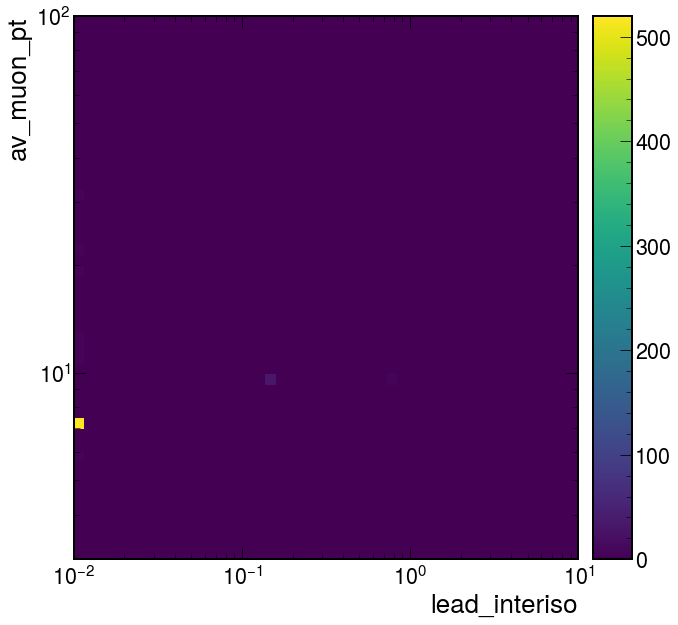

In [16]:
plots['QCD_Pt_MuEnriched_2018']['lead_interiso_vs_av_muon_pt'][:, :, ::sum, ::sum].plot2d()
plt.xscale('log')
plt.yscale('log')

## New cuts investigations

In [34]:
signals = [
    'QCD_Pt_MuEnriched_2018',
    'TTJets_2018',
    'SUEP-m125-darkPho_2018',
    'SUEP-m400-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
]

for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_vs_av_muon_pt'][1.45j::sum, ::sum, ::sum, ::sum]
    print(
        f"{s_tag}:\t{int(evts.value)}±{int(np.sqrt(evts.variance))}"
    )
print()
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_vs_av_muon_pt'][0.84j::sum, ::sum, ::sum, 7j::sum]
    print(
        f"{s_tag}:\t{int(evts.value)}±{int(np.sqrt(evts.variance))}"
    )
print()
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_vs_av_muon_pt'][::sum, ::sum, ::sum, 8j::sum]
    print(
        f"{s_tag}:\t{int(evts.value)}±{int(np.sqrt(evts.variance))}"
    )
######################################################################
print("\nlead_interiso_4")
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_4'][0.96j::sum, ::sum]
    print(
        f"\t{s_tag}:\t{evts.value:.1f}±{np.sqrt(evts.variance):.1f}"
    )
print("\nlead_interiso_8")
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_8'][1.26j::sum, ::sum]
    print(
        f"\t{s_tag}:\t{evts.value:.1f}±{np.sqrt(evts.variance):.1f}"
    )
print("\nlead_interiso_16")
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_16'][1.45j::sum, ::sum]
    print(
        f"\t{s_tag}:\t{evts.value:.1f}±{np.sqrt(evts.variance):.1f}"
    )
print("\nlead_interiso_32")
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_32'][2.52j::sum, ::sum]
    print(
        f"\t{s_tag}:\t{evts.value:.1f}±{np.sqrt(evts.variance):.1f}"
    )
print("\nlead_interiso_64")
for signal in signals:
    s_tag = signal.replace("SUEP_ggH-channel_","").replace("2018","")
    evts = plots[signal]['lead_interiso_64'][2.52j::sum, ::sum]
    print(
        f"\t{s_tag}:\t{evts.value:.1f}±{np.sqrt(evts.variance):.1f}"
    )

QCD_Pt_MuEnriched_:	0±0
TTJets_:	0±0
SUEP-m125-darkPho_:	48987±3490
SUEP-m400-darkPho_:	6353±332
mMed-125_mDark-2_temp-8_decay-darkPho_:	27363±2597
mMed-125_mDark-8_temp-8_decay-darkPho_:	22186±2338
mMed-125_mDark-4_temp-16_decay-darkPho_:	6791±1307
mMed-125_mDark-8_temp-16_decay-darkPho_:	6037±1232
mMed-125_mDark-8_temp-32_decay-darkPho_:	754±435
mMed-125_mDark-2_temp-8_decay-darkPhoHad_:	1972±697
mMed-125_mDark-8_temp-8_decay-darkPhoHad_:	1006±503
mMed-125_mDark-4_temp-16_decay-darkPhoHad_:	0±0
mMed-125_mDark-8_temp-16_decay-darkPhoHad_:	246±246
mMed-125_mDark-8_temp-32_decay-darkPhoHad_:	0±0

QCD_Pt_MuEnriched_:	0±0
TTJets_:	0±0
SUEP-m125-darkPho_:	64166±3994
SUEP-m400-darkPho_:	11157±440
mMed-125_mDark-2_temp-8_decay-darkPho_:	40182±3147
mMed-125_mDark-8_temp-8_decay-darkPho_:	26870±2573
mMed-125_mDark-4_temp-16_decay-darkPho_:	7798±1400
mMed-125_mDark-8_temp-16_decay-darkPho_:	7546±1377
mMed-125_mDark-8_temp-32_decay-darkPho_:	1006±503
mMed-125_mDark-2_temp-8_decay-darkPhoHad_:	14

In [54]:
plots['VV_2018'].keys()

dict_keys(['nPU_vs_nTrueInt', 'lead_interiso_vs_av_muon_pt', 'lead_interiso_4', 'lead_interiso_8', 'lead_interiso_16', 'lead_interiso_32', 'lead_interiso_64', 'Muon_miniPFRelIso_all_max', 'Muon_miniPFRelIso_all', 'Muon_jetPtRelv2', 'Muon_jetRelIso', 'Muon_Jet_btagDeepFlavB', 'nBtagJets_loose', 'nBtagJets_medium', 'nBtagJets_tight'])

In [71]:
points = {
    0.3j: [(0, 6), (1.3, 5)],
    0.6j: [(0, 6), (2.2, 5)],
    1j: [(0, 7), (2.1, 6), (5, 5)],
    1.5j: [(0, 7), (2.1, 6), (5, 5)],
    2j: [(0, 8), (2, 7), (2.1, 6), (5.5, 5)],
    3j: [(0, 8), (2, 7), (2.1, 6), (5, 5)],
    5j: [(0, 8), (2, 7), (2.1, 6), (9, 5)],
    7j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    10j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    15j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    20j: [(0, 8), (2, 7), (2.1, 6)],
    100j: [(0, 8), (2, 7), (2.1, 6)],
}
for iso_cut in points:
    x, y = [], []
    for i in range(len(points[iso_cut])):
        x.append(points[iso_cut][i][0])
        y.append(points[iso_cut][i][1])
        if i < len(points[iso_cut])-1:
            x.append(points[iso_cut][i+1][0])
            y.append(points[iso_cut][i][1]) 
    x.append(10)
    y.append(points[iso_cut][-1][1])
    print(x, y)

[0, 1.3, 1.3, 10] [6, 6, 5, 5]
[0, 2.2, 2.2, 10] [6, 6, 5, 5]
[0, 2.1, 2.1, 5, 5, 10] [7, 7, 6, 6, 5, 5]
[0, 2.1, 2.1, 5, 5, 10] [7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 5.5, 5.5, 10] [8, 8, 7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 5, 5, 10] [8, 8, 7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 9, 9, 10] [8, 8, 7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 9.5, 9.5, 10] [8, 8, 7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 9.5, 9.5, 10] [8, 8, 7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 9.5, 9.5, 10] [8, 8, 7, 7, 6, 6, 5, 5]
[0, 2, 2, 2.1, 2.1, 10] [8, 8, 7, 7, 6, 6]
[0, 2, 2, 2.1, 2.1, 10] [8, 8, 7, 7, 6, 6]


(0.0, 6), WeightedSum(value=0.317928, variance=0.000239061)
(1.3, 5), WeightedSum(value=0.30413, variance=0.175335)
(0.0, 6), WeightedSum(value=0.409676, variance=0.000313651)
(2.2, 5), WeightedSum(value=0.0179167, variance=1.56393e-05)
(0.0, 7), WeightedSum(value=0.00289828, variance=2.10039e-06)
(2.1, 6), WeightedSum(value=0.00879814, variance=6.48104e-06)
(5.0, 5), WeightedSum(value=0.00149743, variance=1.12114e-06)
(0.0, 7), WeightedSum(value=0.00144355, variance=3.1585e-06)
(2.1, 6), WeightedSum(value=0.00879814, variance=6.48104e-06)
(5.0, 5), WeightedSum(value=0.0428989, variance=0.000661532)
(0.0, 8), WeightedSum(value=0, variance=0)
(2.0, 7), WeightedSum(value=0, variance=0)
(2.1, 6), WeightedSum(value=0.00879814, variance=6.48104e-06)
(5.5, 5), WeightedSum(value=0.0428989, variance=0.000661532)
(0.0, 8), WeightedSum(value=0, variance=0)
(2.0, 7), WeightedSum(value=0, variance=0)
(2.1, 6), WeightedSum(value=0.00879814, variance=6.48104e-06)
(5.0, 5), WeightedSum(value=0.041746

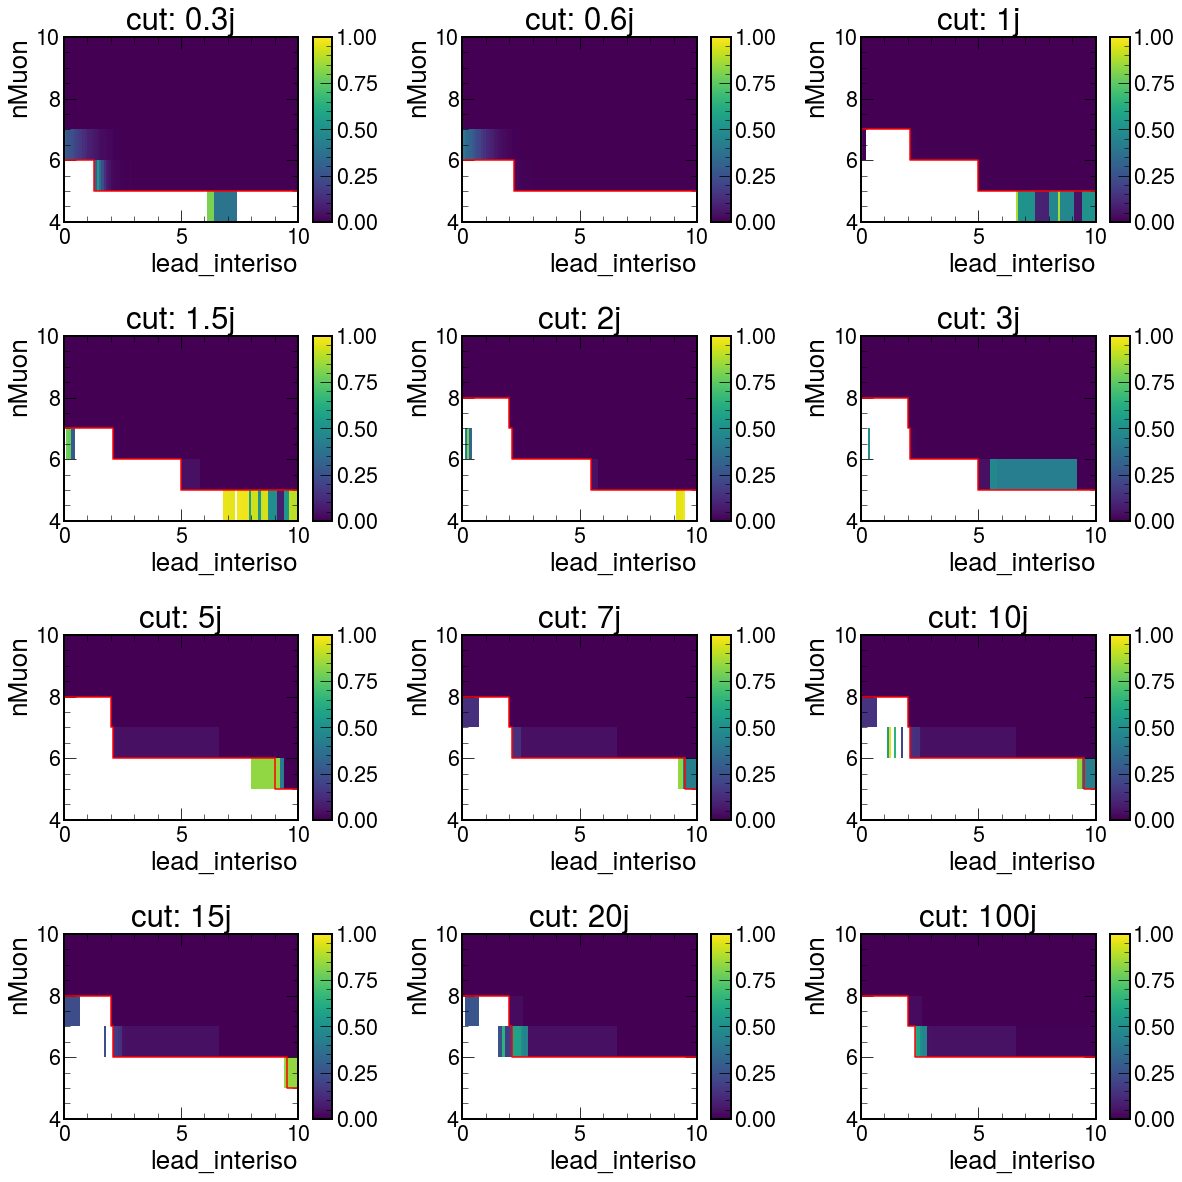

In [78]:
processes = [
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
histograms = ['lead_interiso_vs_muon_iso_cut_vs_nMuon']

h_bkg = {}
for p in processes:
    for h in histograms:
        if h not in h_bkg.keys():
            h_bkg[h] = plots[p][h].copy()
        h_bkg[h] += plots[p][h].copy()

muon_iso_cuts = [0.3j, 0.6j, 1j, 1.5j, 2j, 3j, 5j, 7j, 10j, 15j, 20j, 100j]
points = {
    0.3j: [(0, 6), (1.3, 5)],
    0.6j: [(0, 6), (2.2, 5)],
    1j: [(0, 7), (2.1, 6), (5, 5)],
    1.5j: [(0, 7), (2.1, 6), (5, 5)],
    2j: [(0, 8), (2, 7), (2.1, 6), (5.5, 5)],
    3j: [(0, 8), (2, 7), (2.1, 6), (5, 5)],
    5j: [(0, 8), (2, 7), (2.1, 6), (9, 5)],
    7j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    10j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    15j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    20j: [(0, 8), (2, 7), (2.1, 6)],
    100j: [(0, 8), (2, 7), (2.3, 6)],
}
    
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(17, 17))
ax_i, ax_j = 0, 0
for iso_cut in muon_iso_cuts:
    if ax_i == 3:
        ax_i = 0
        ax_j += 1
    h_bkg_cumsum = h_bkg['lead_interiso_vs_muon_iso_cut_vs_nMuon'][:, iso_cut, :].copy().reset()
    for x in range(100):
        for y in range(6):
            h_bkg_cumsum[x, y] = h_bkg['lead_interiso_vs_muon_iso_cut_vs_nMuon'][x::sum, iso_cut, y::sum]
    hep.hist2dplot(h_bkg_cumsum, ax=axs[ax_j, ax_i], cmin=0, cmax=1)
    axs[ax_j, ax_i].set_title(f"cut: {iso_cut}")
    line_x, line_y = [], []
    for i in range(len(points[iso_cut])):
        line_x.append(points[iso_cut][i][0])
        line_y.append(points[iso_cut][i][1])
        if i < len(points[iso_cut])-1:
            line_x.append(points[iso_cut][i+1][0])
            line_y.append(points[iso_cut][i][1]) 
    line_x.append(10)
    line_y.append(points[iso_cut][-1][1])
    axs[ax_j, ax_i].plot(line_x, line_y, color='r')
    for p in points[iso_cut]:
        print(f"({p[0]:.1f}, {p[1]}), {h_bkg_cumsum[p[0]*1j, p[1]*1j]}")
    ax_i += 1
fig.tight_layout()
plt.show()

signal is SUEP-m125-darkPho_2018


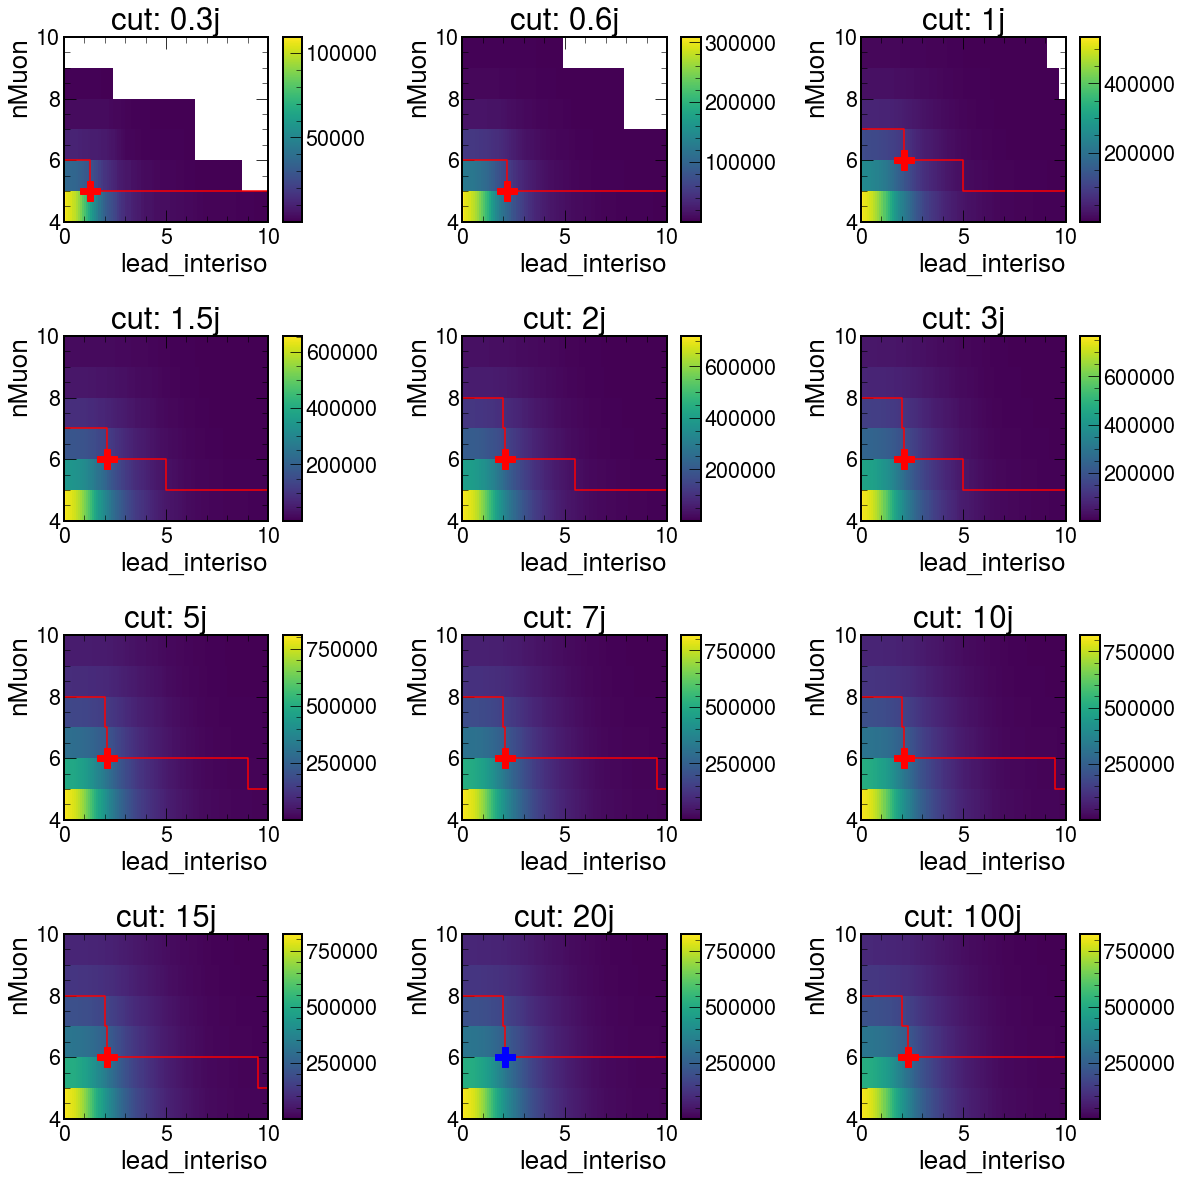

signal is SUEP-m125-darkPhoHad_2018


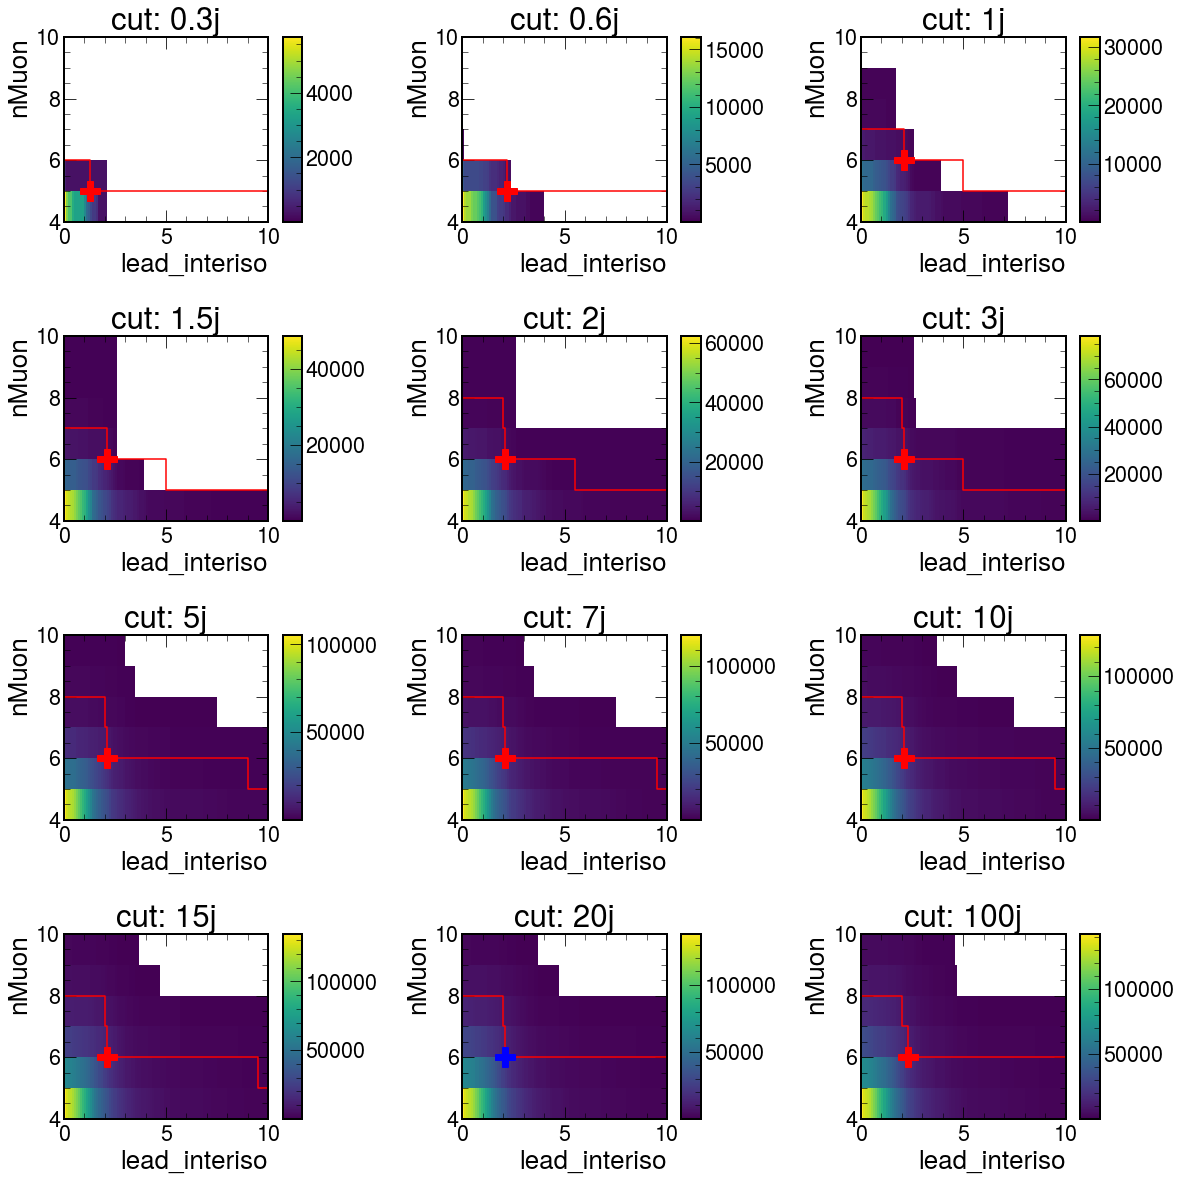

signal is SUEP-m400-darkPhoHad_2018


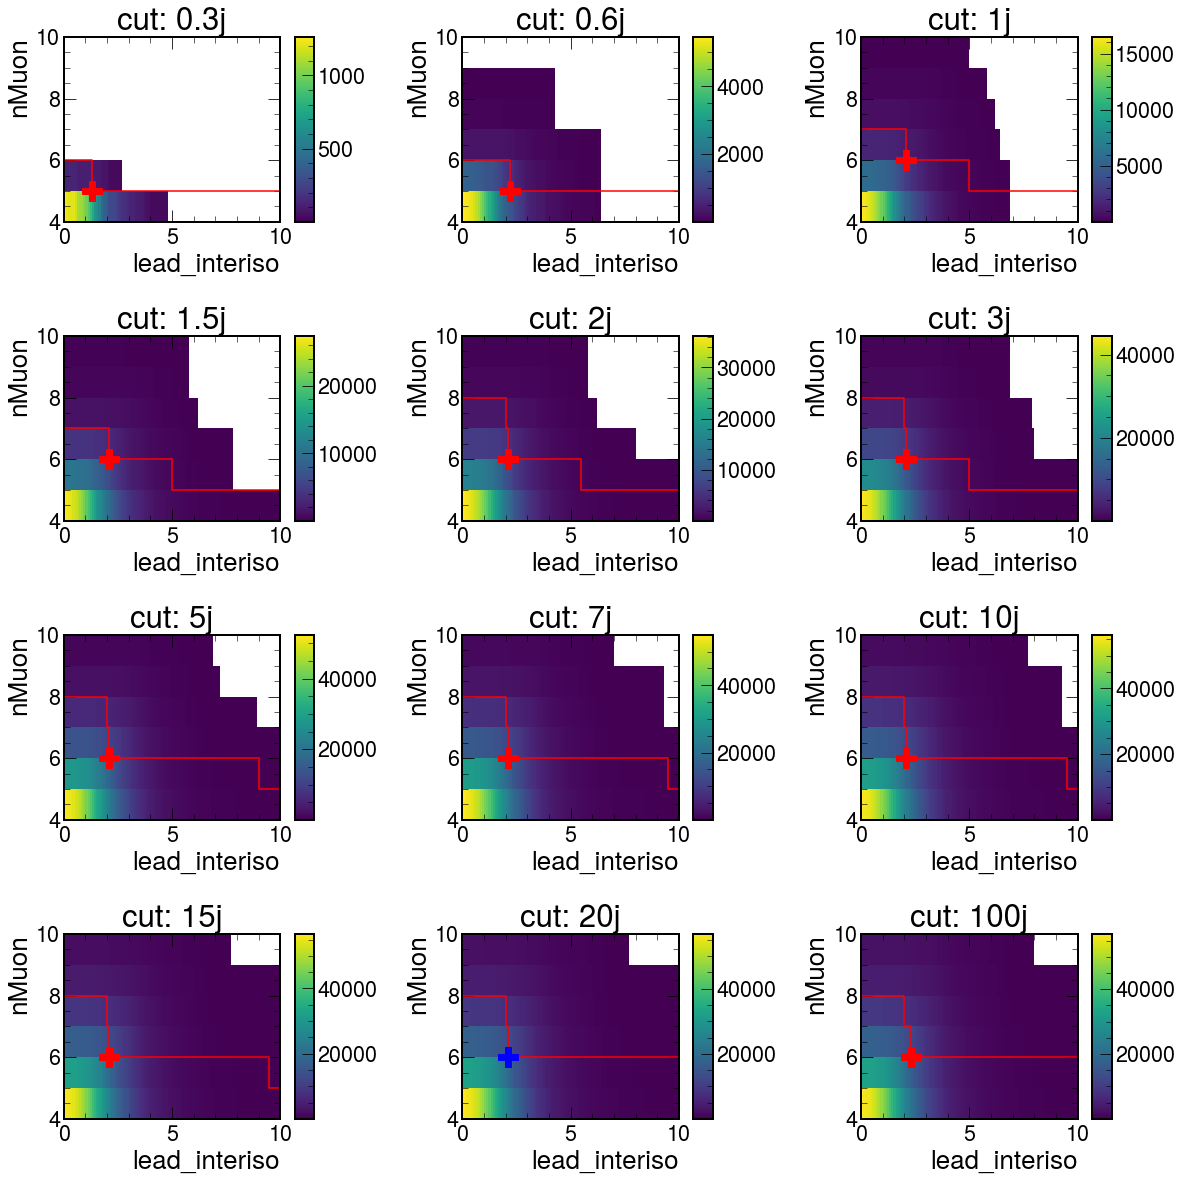

signal is SUEP-m1000-darkPhoHad_2018


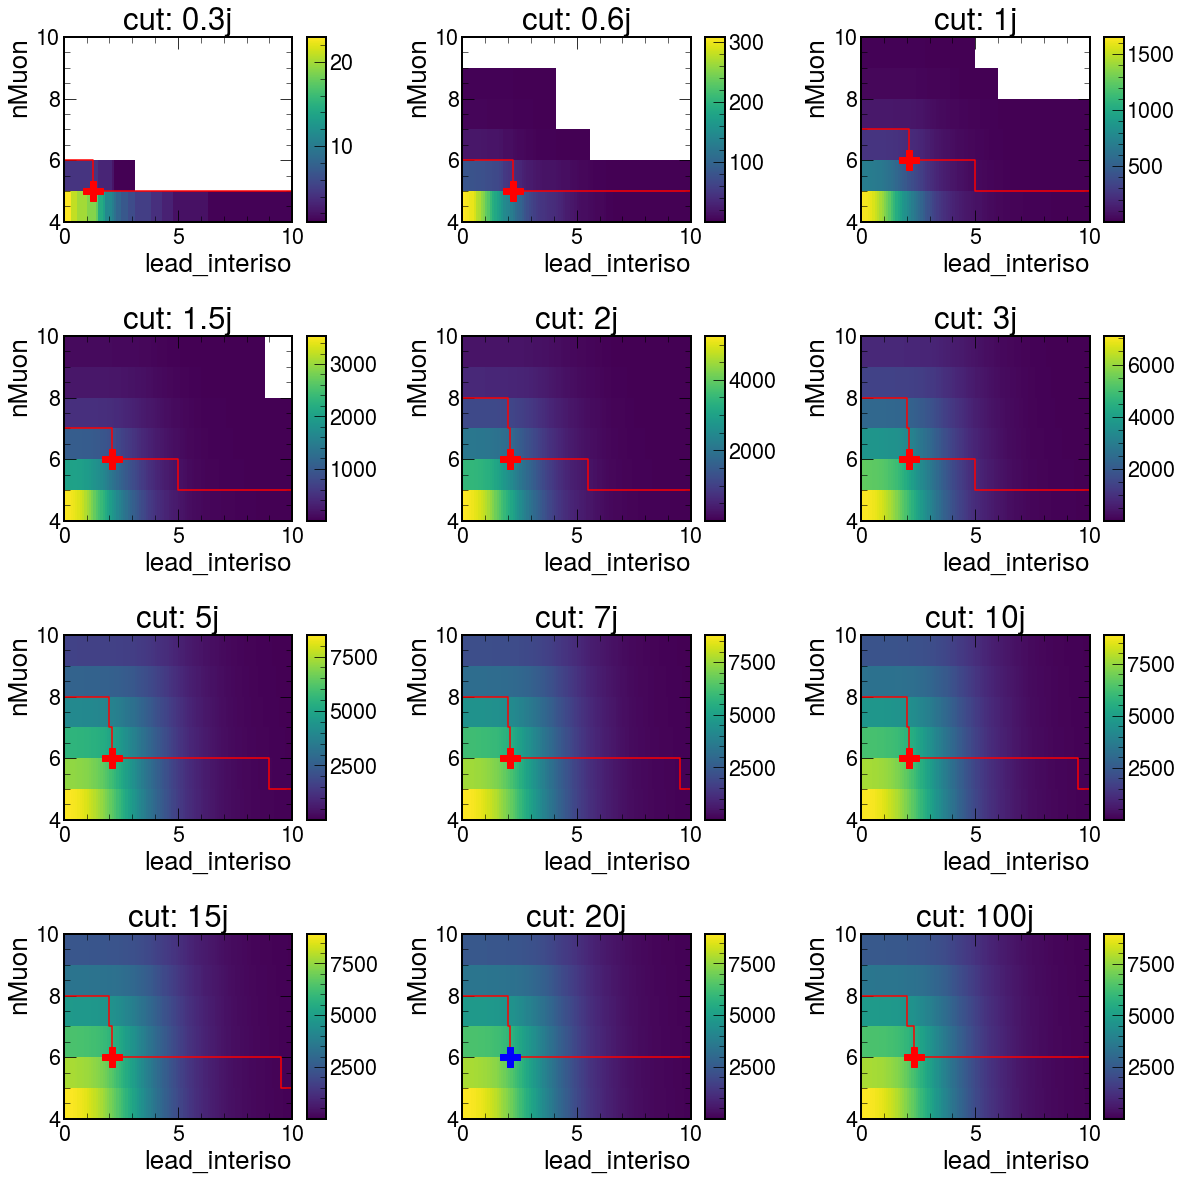

signal is SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.35_decay-darkPhoHad_2018


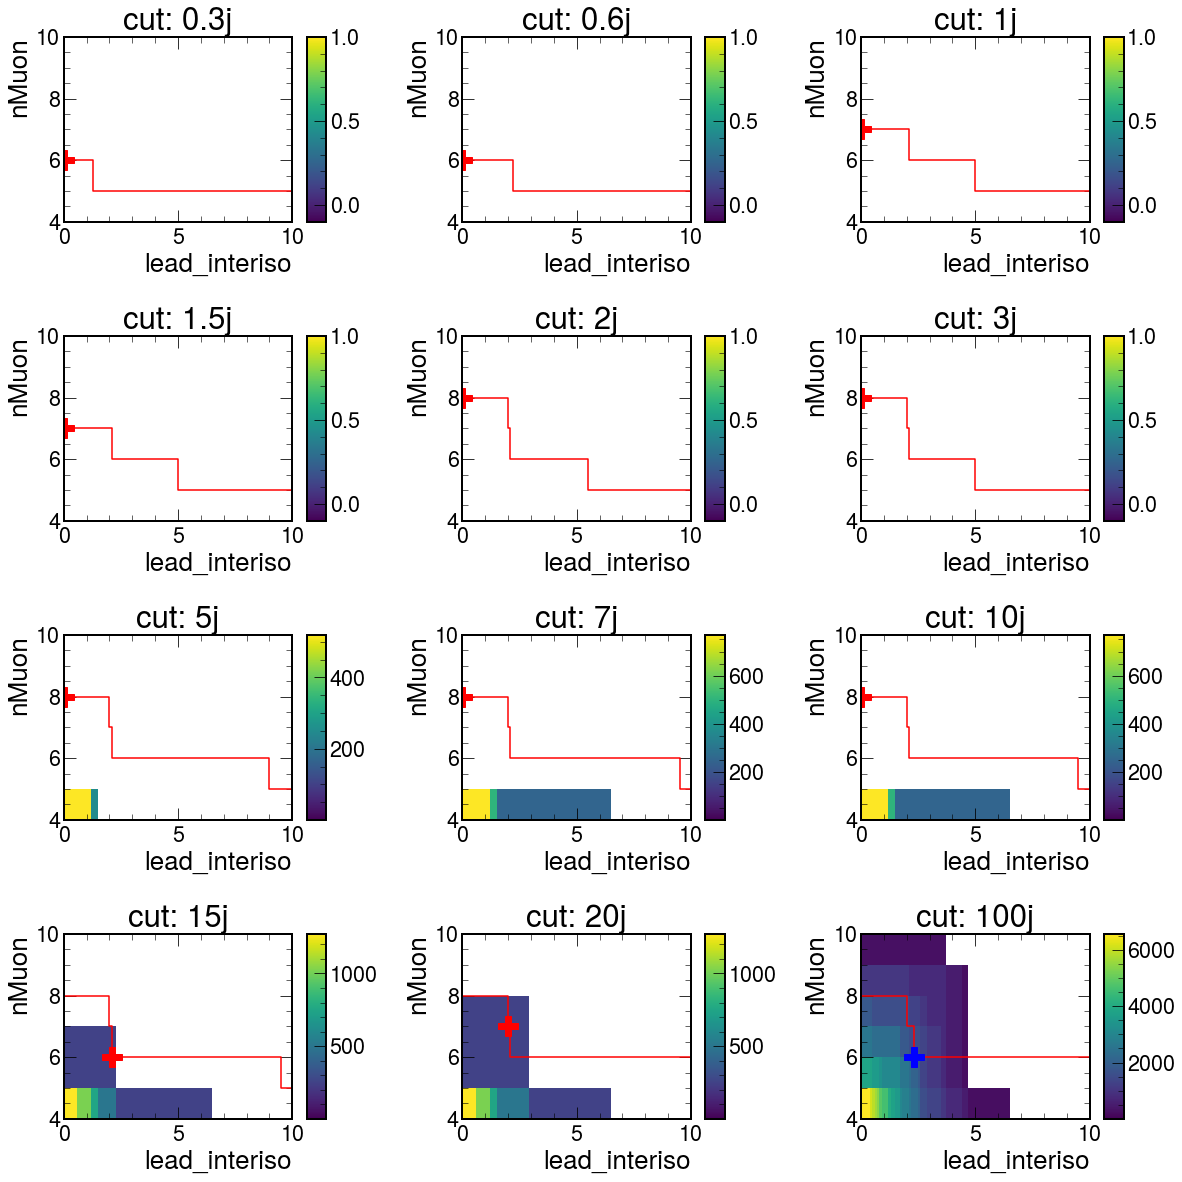

signal is SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.7_decay-darkPhoHad_2018


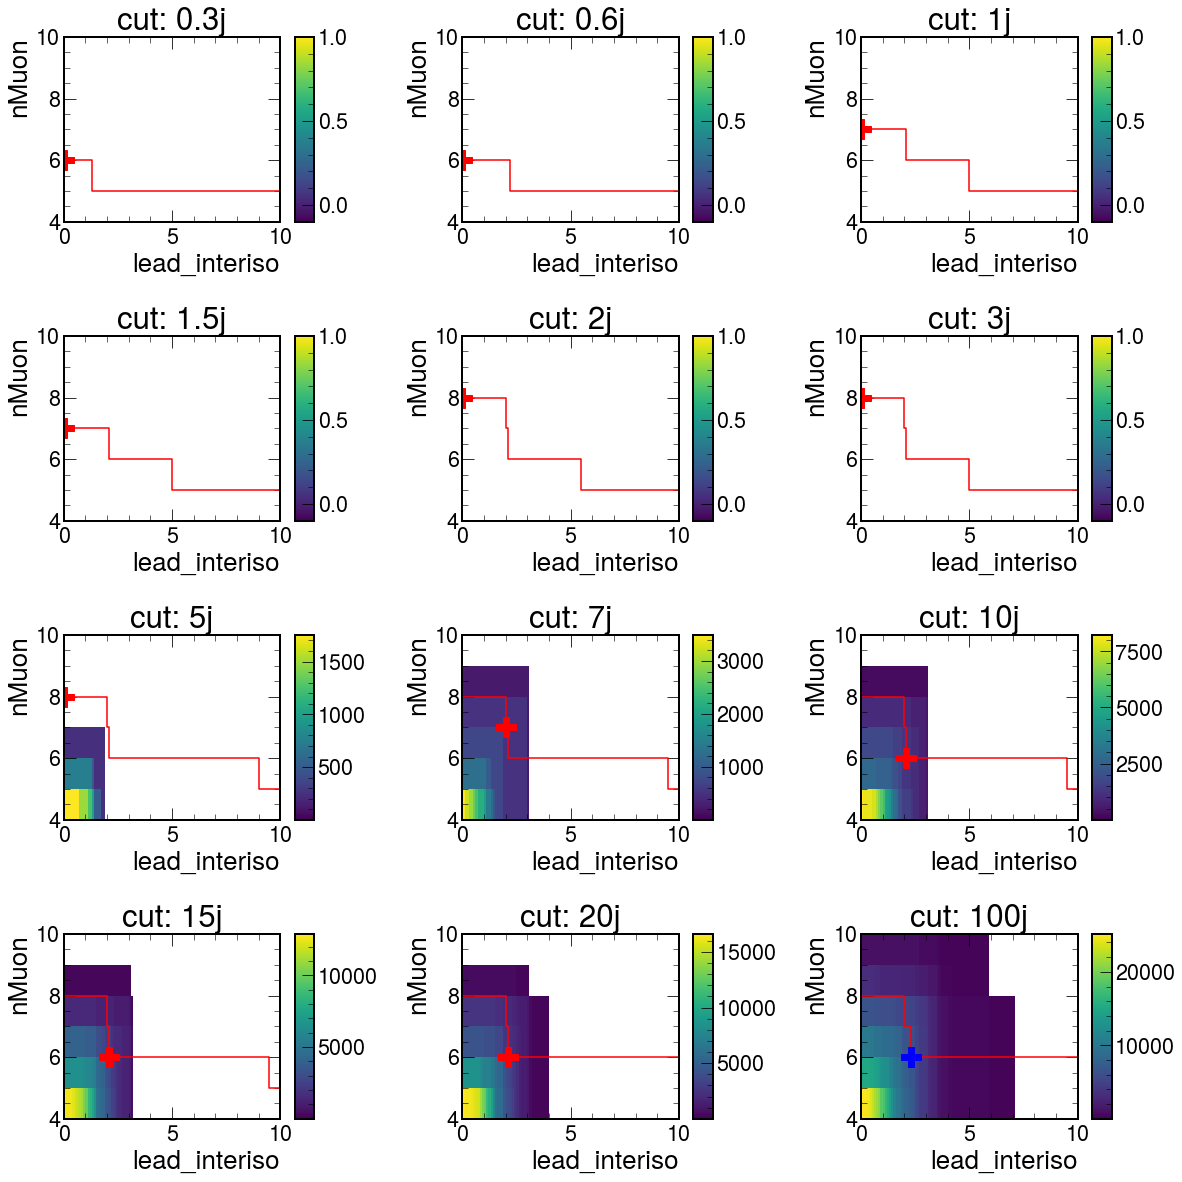

signal is SUEP_ggH-channel_mMed-125_mDark-1.4_temp-1.4_decay-darkPhoHad_2018


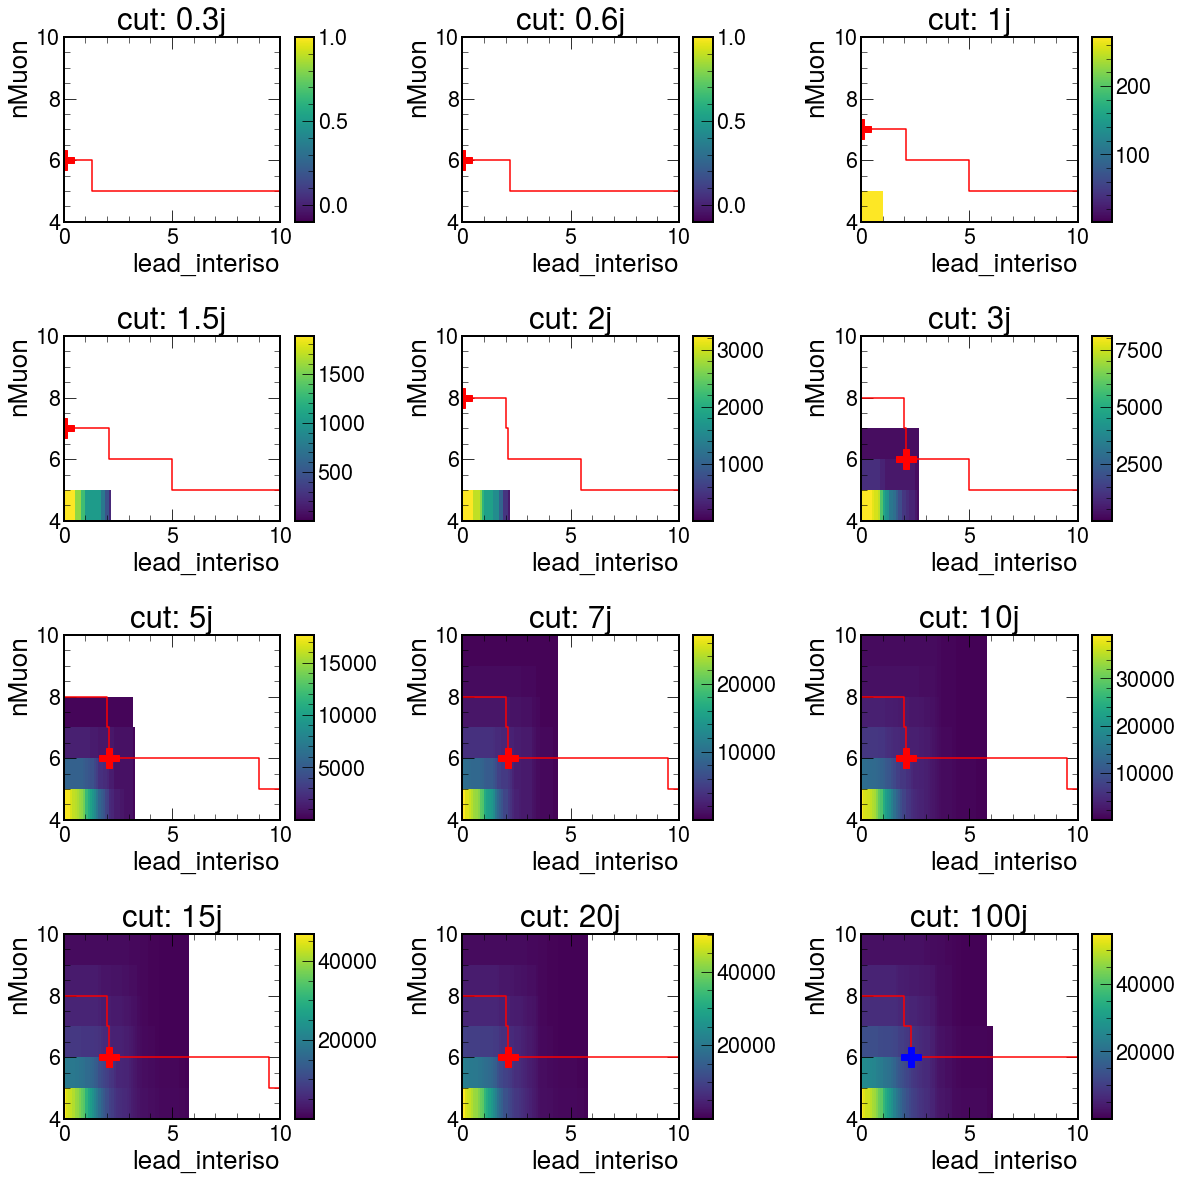

signal is SUEP_ggH-channel_mMed-125_mDark-2_temp-0.5_decay-darkPhoHad_2018


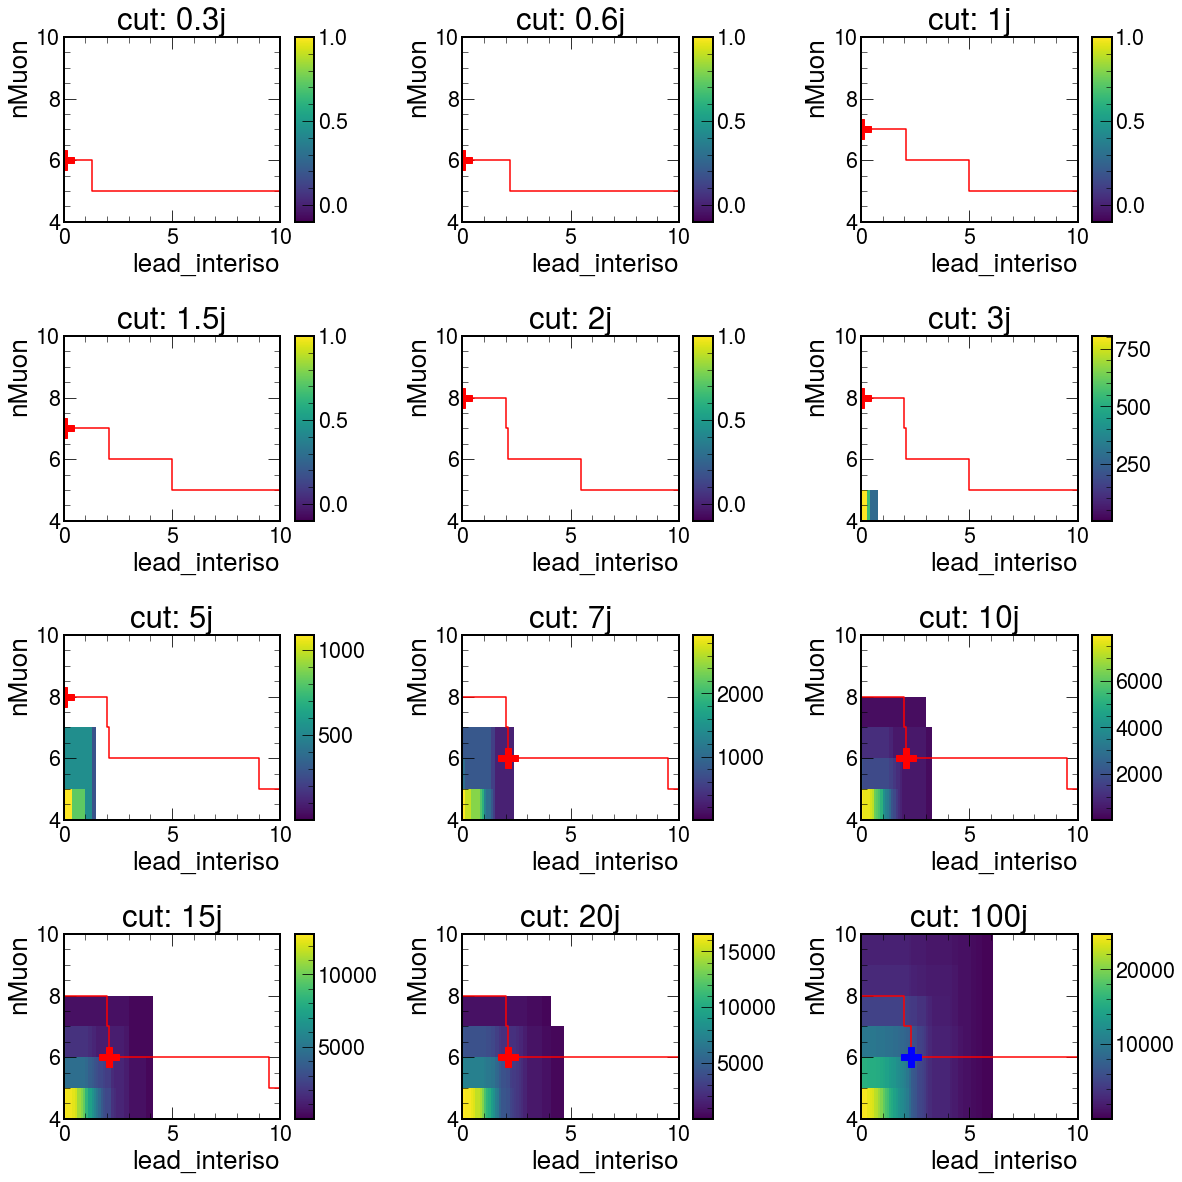

signal is SUEP_ggH-channel_mMed-125_mDark-2_temp-2_decay-darkPhoHad_2018


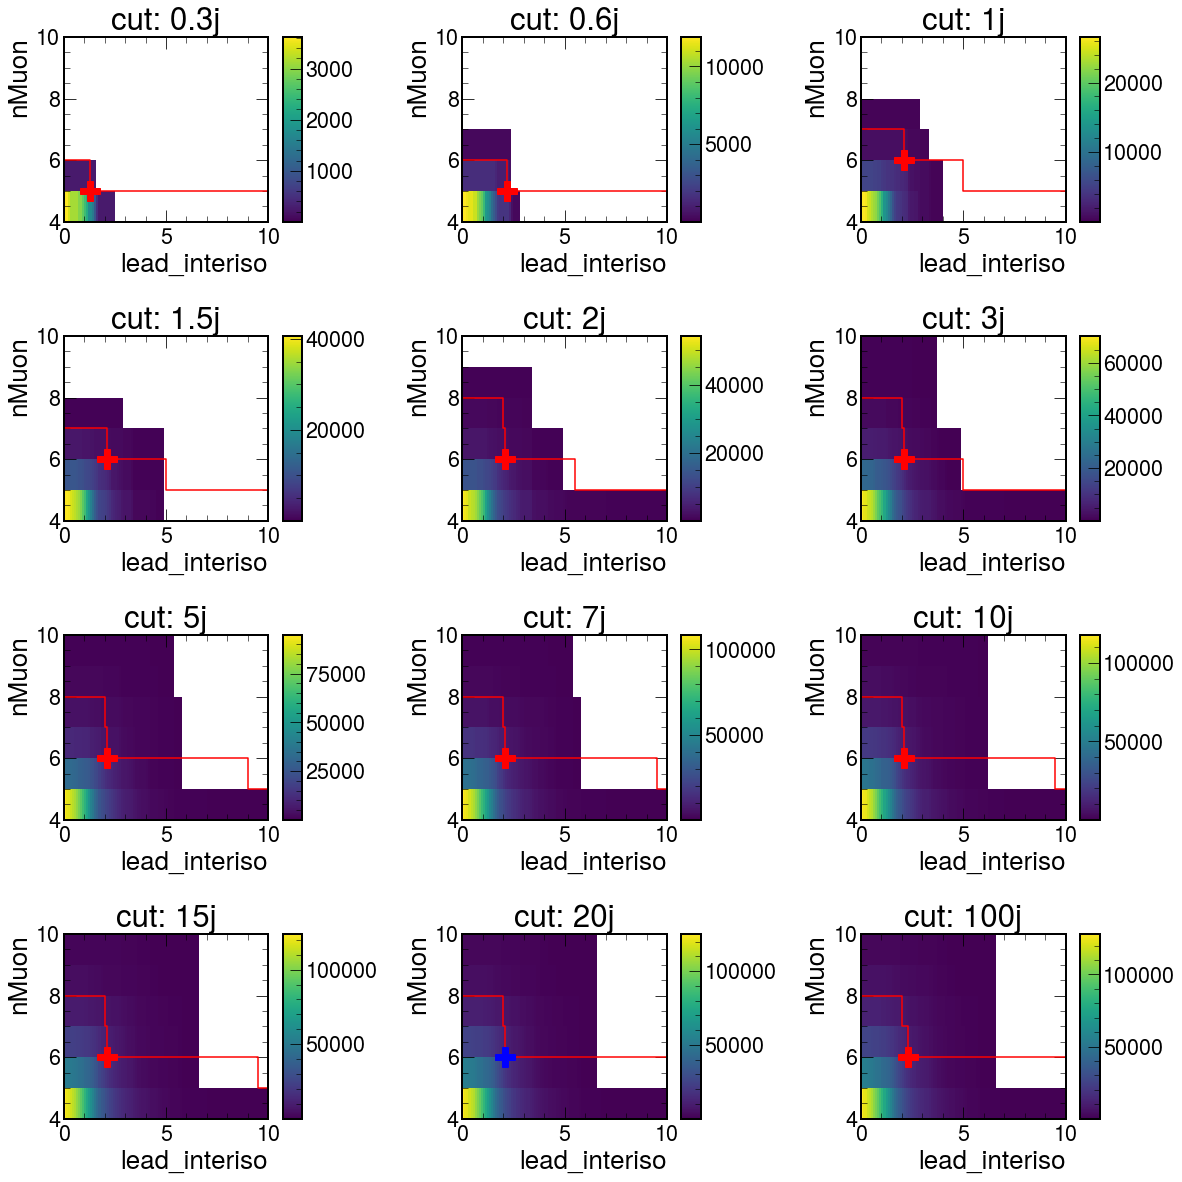

signal is SUEP_ggH-channel_mMed-125_mDark-2_temp-4_decay-darkPhoHad_2018


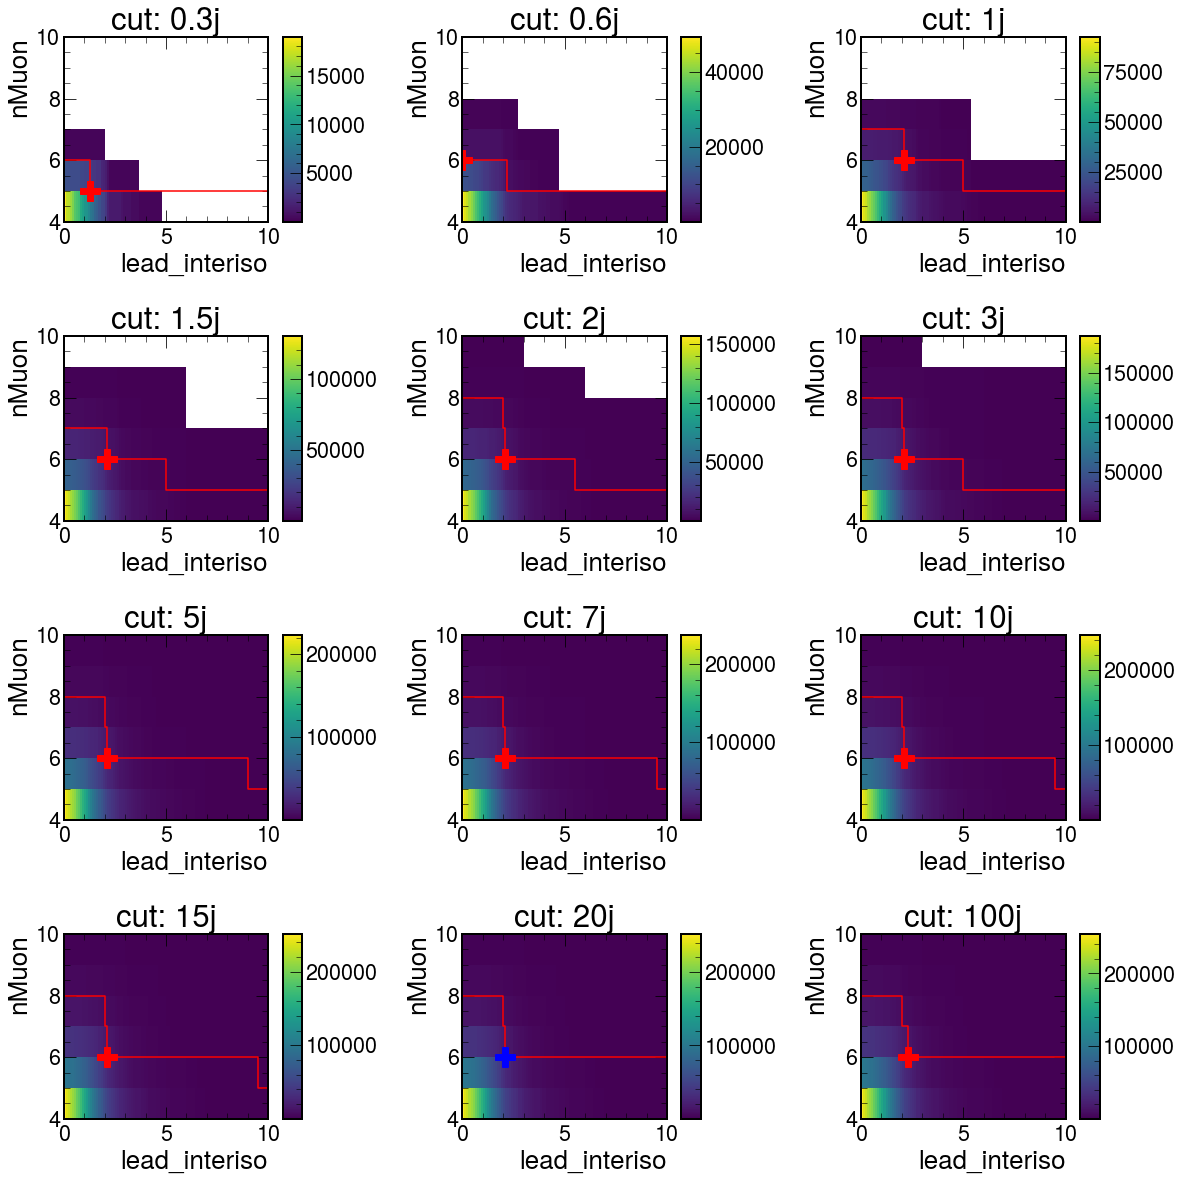

signal is SUEP_ggH-channel_mMed-125_mDark-4_temp-1_decay-darkPhoHad_2018


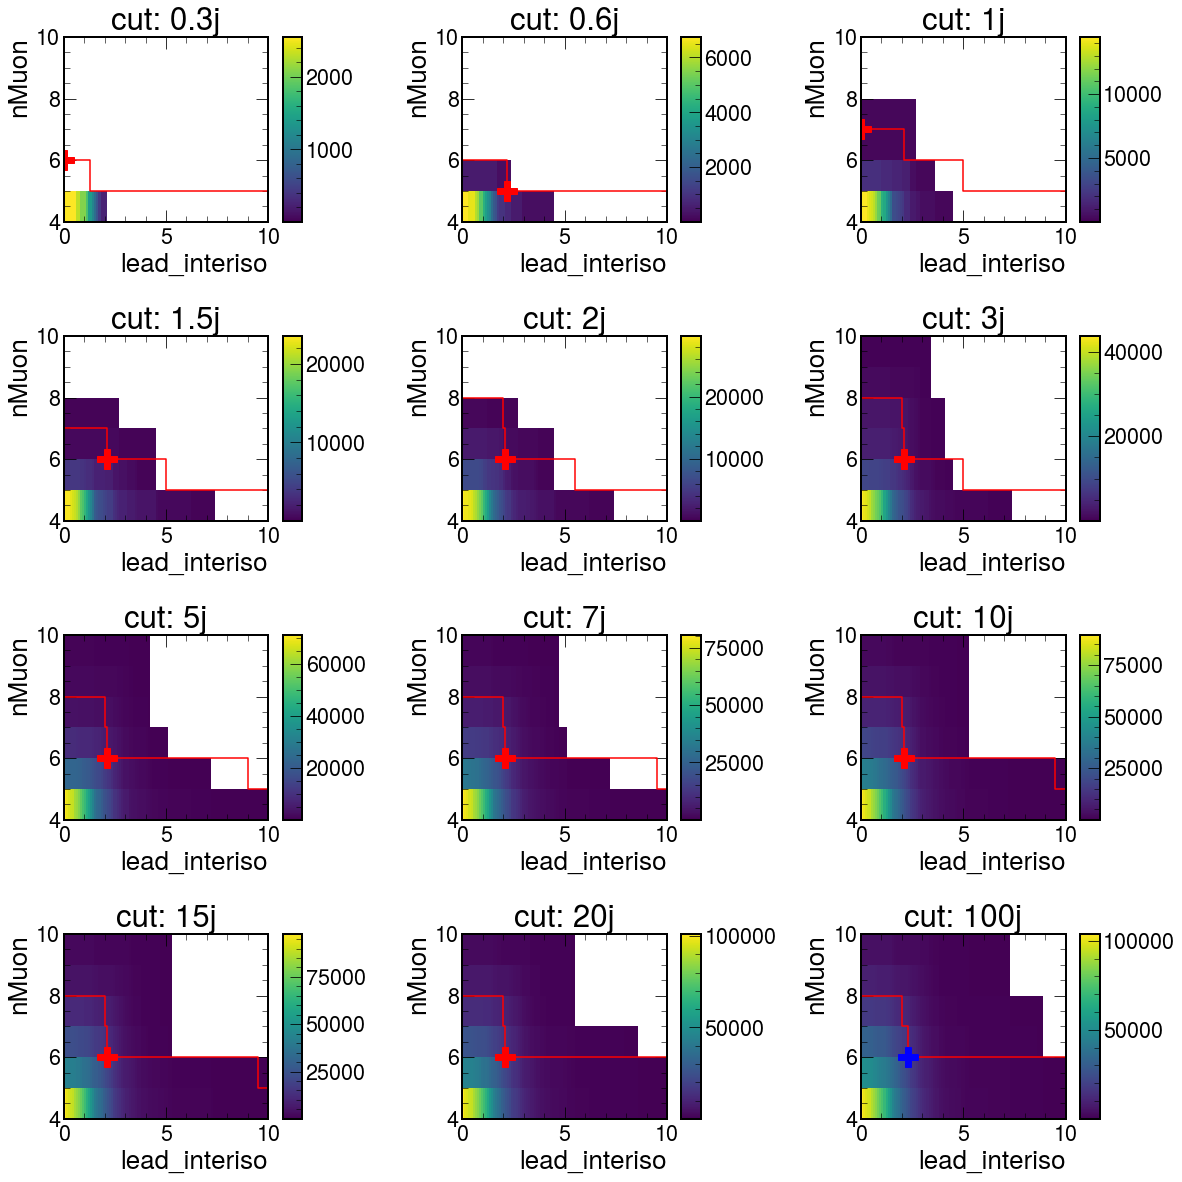

signal is SUEP_ggH-channel_mMed-125_mDark-4_temp-4_decay-darkPhoHad_2018


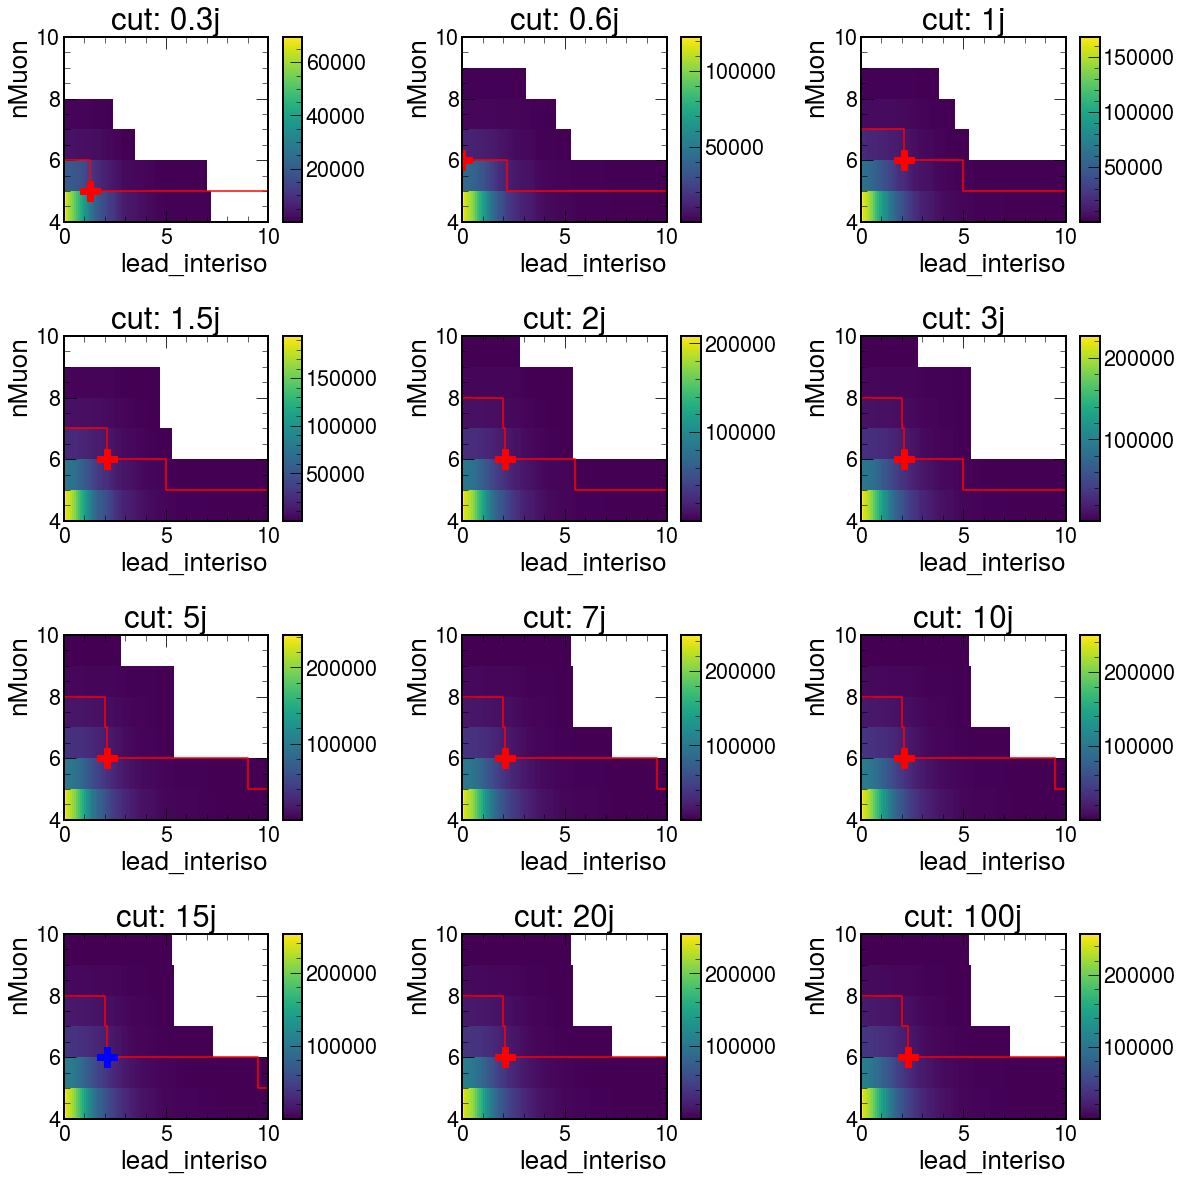

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-2_decay-darkPhoHad_2018


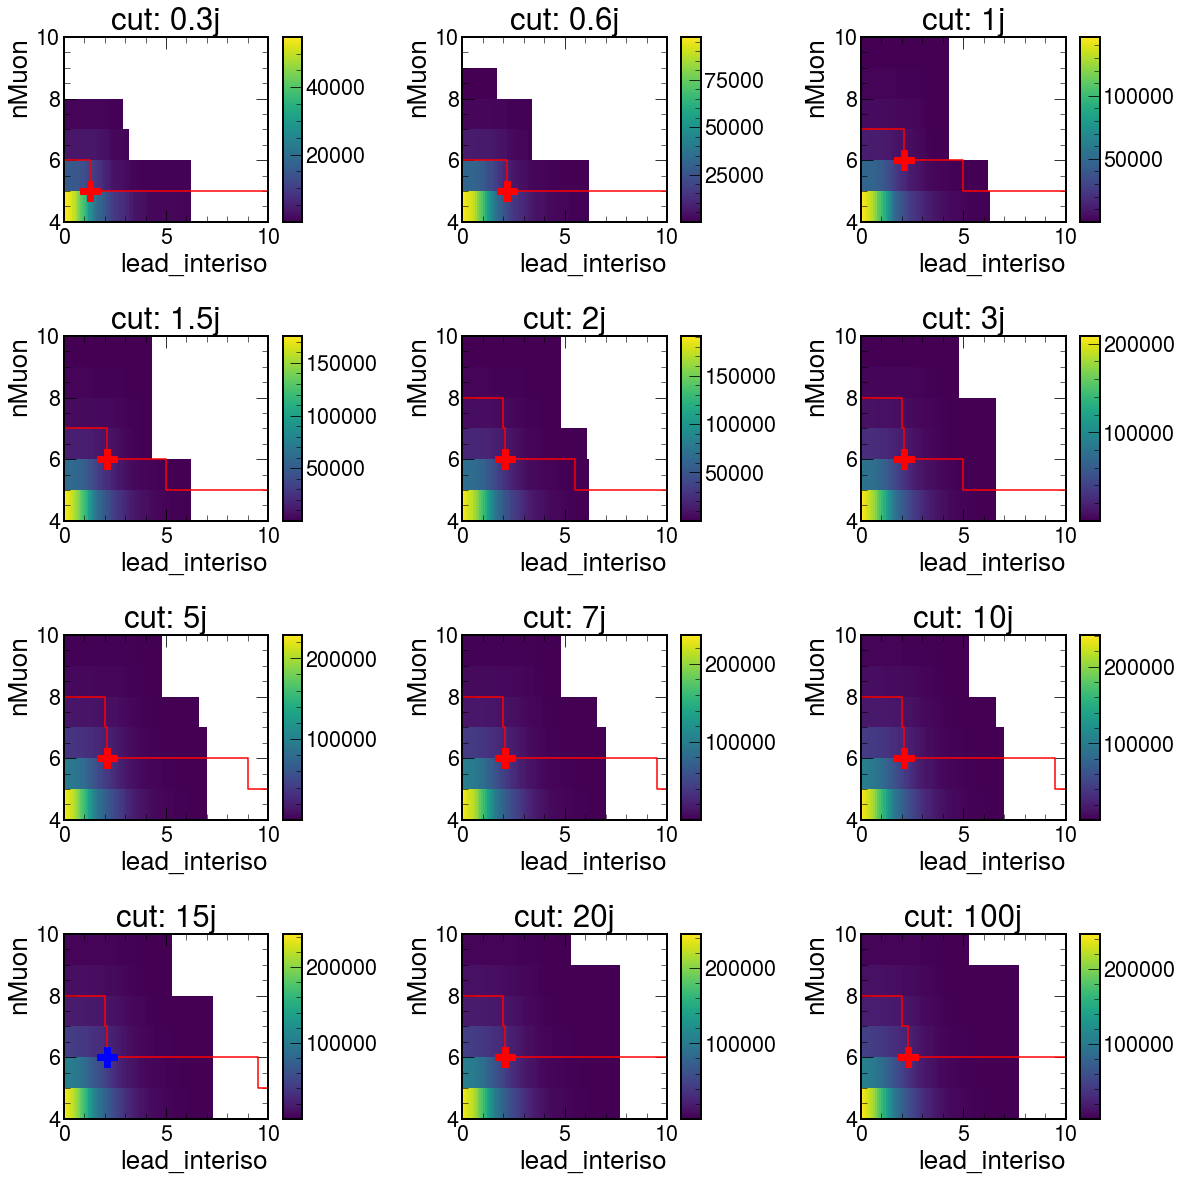

signal is SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018


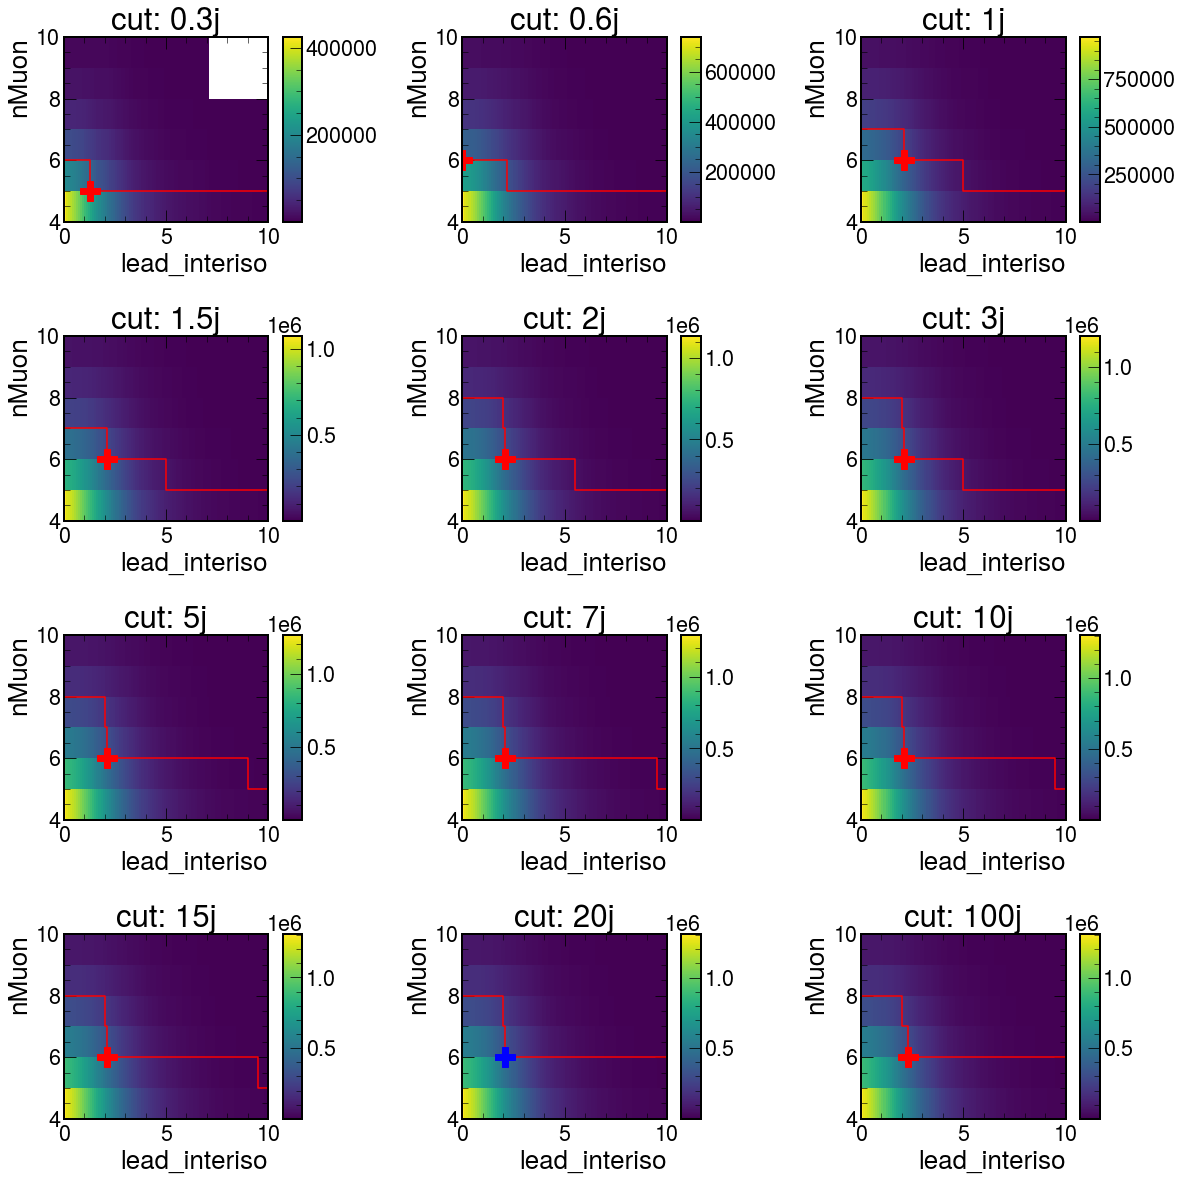

signal is SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018


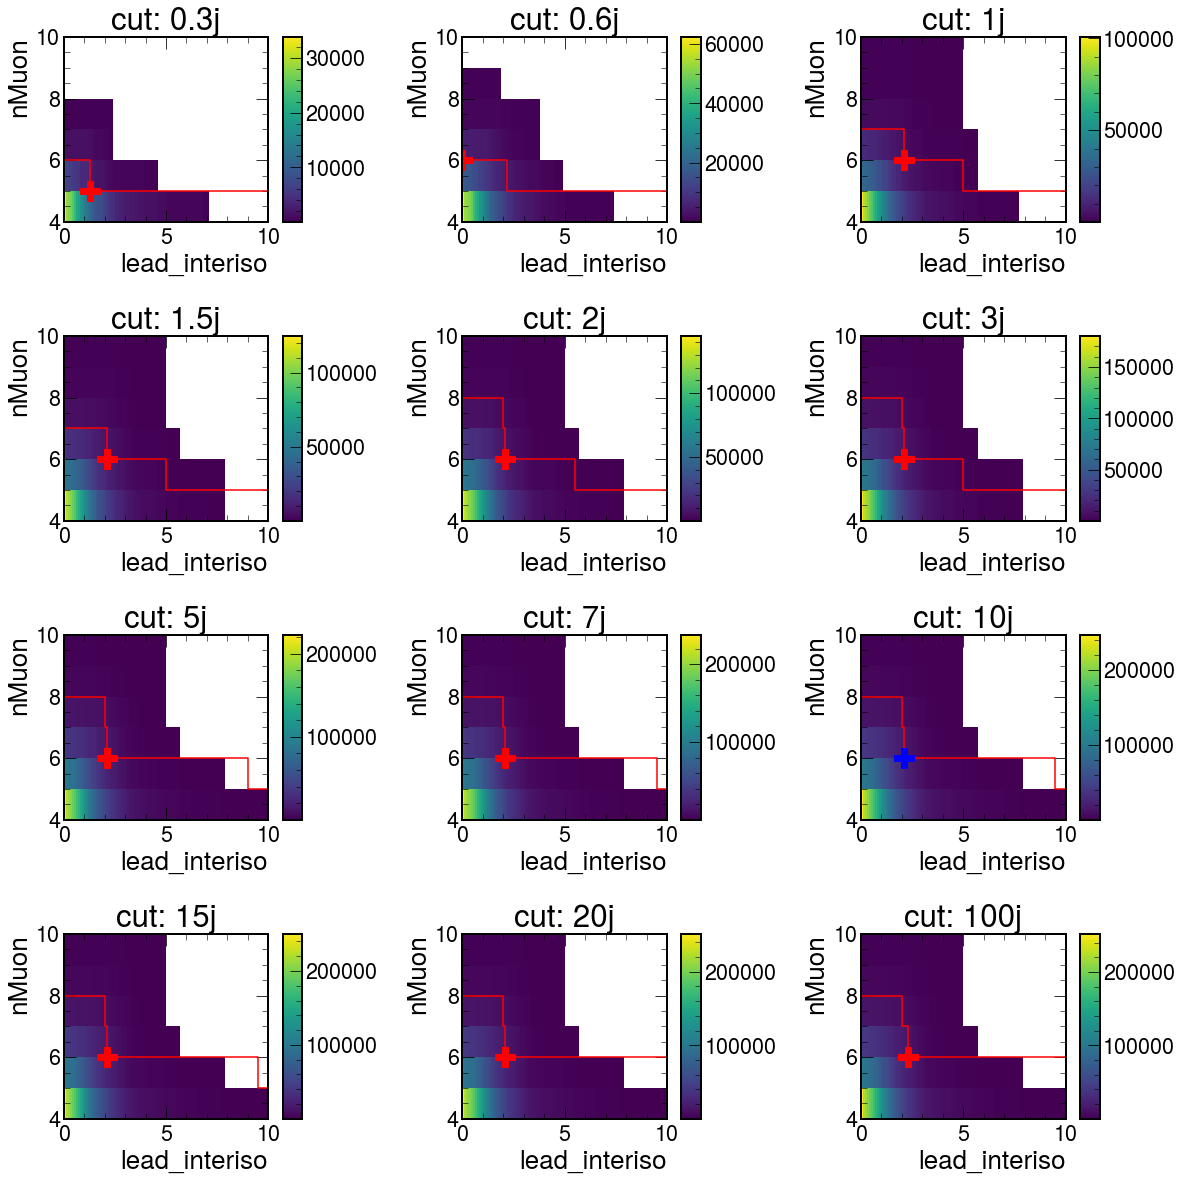

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018


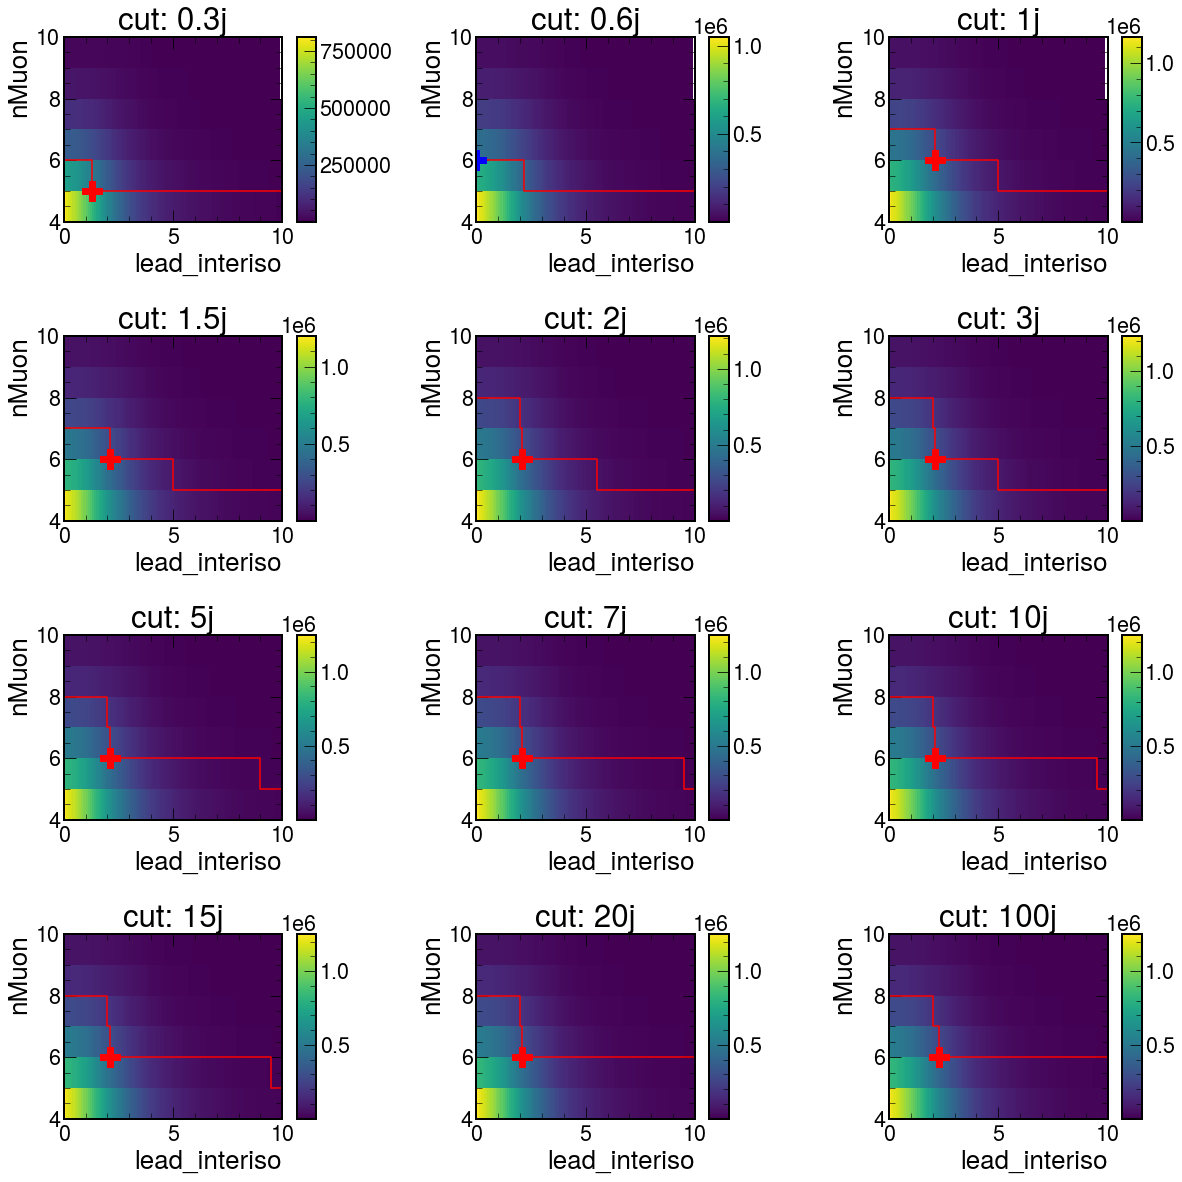

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018


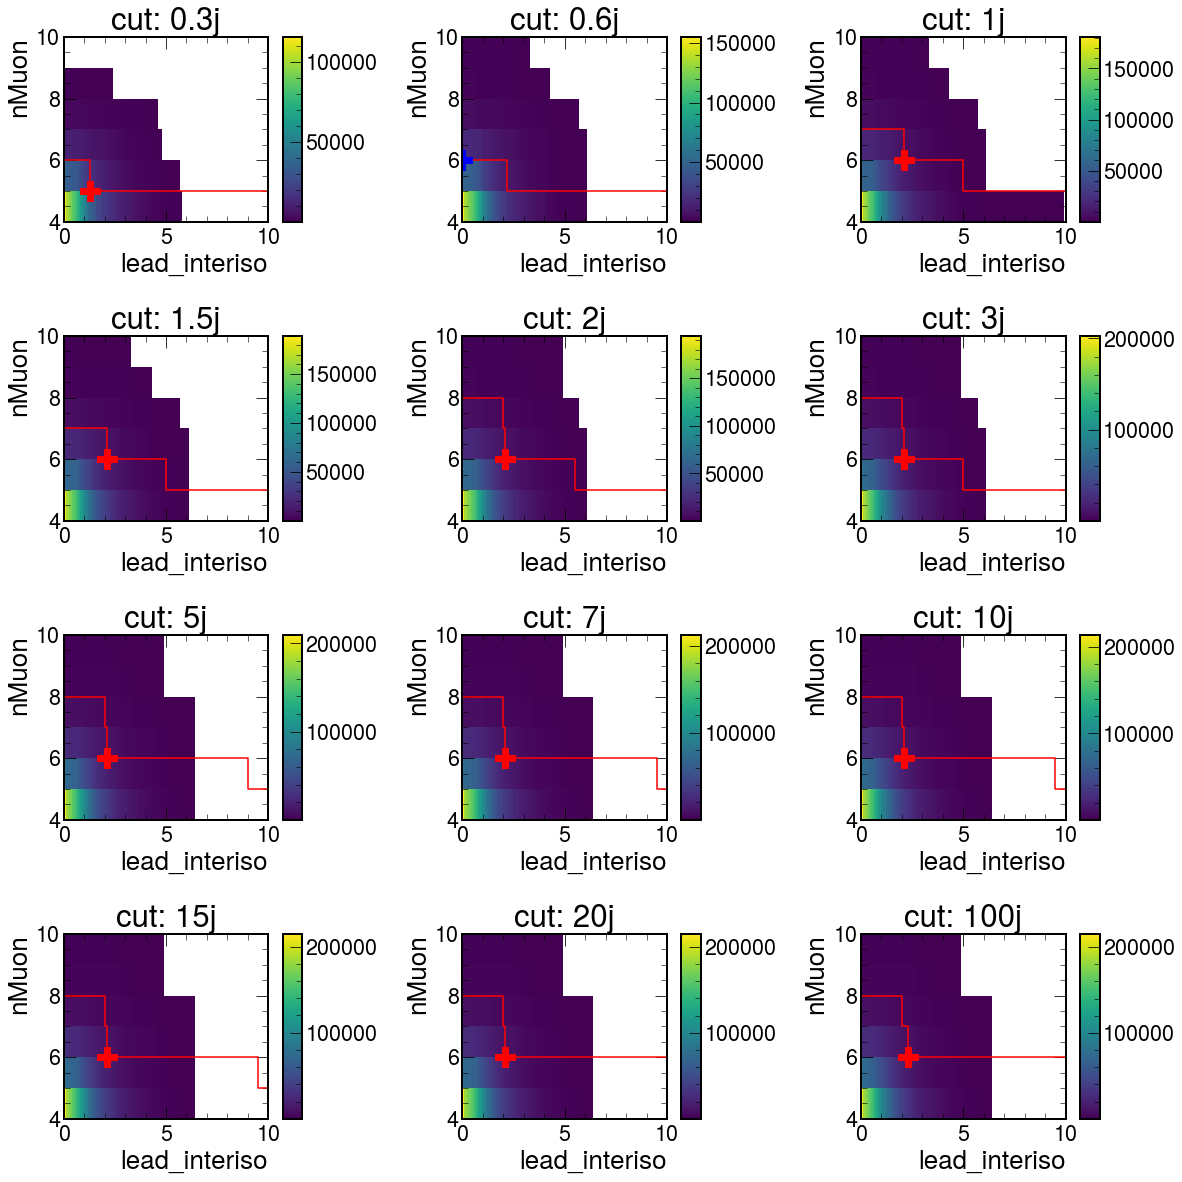

signal is SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018


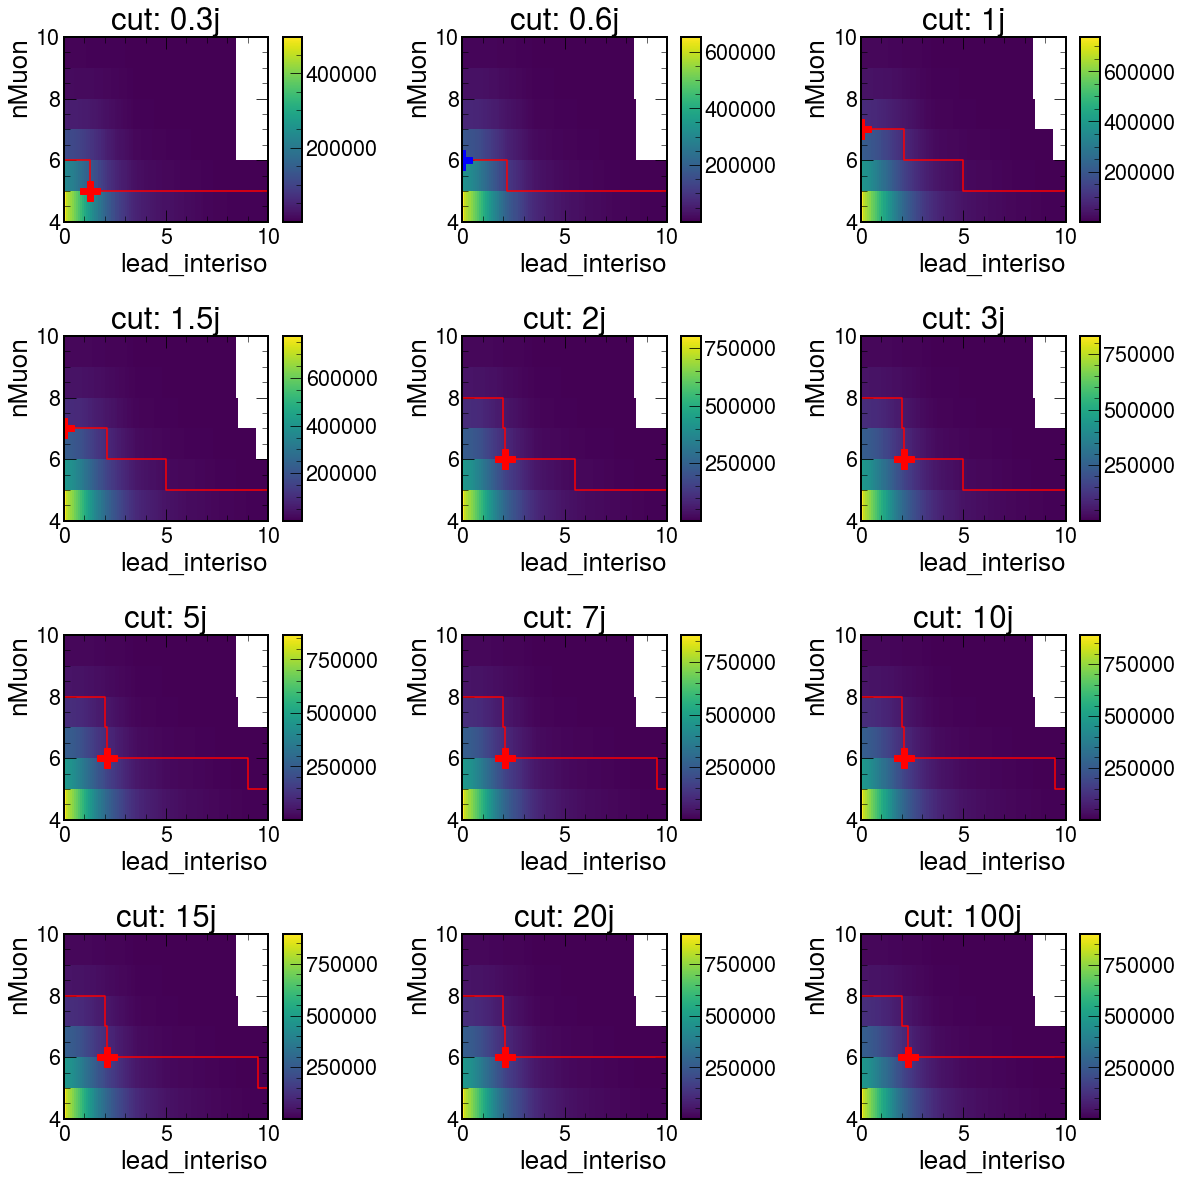

signal is SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018


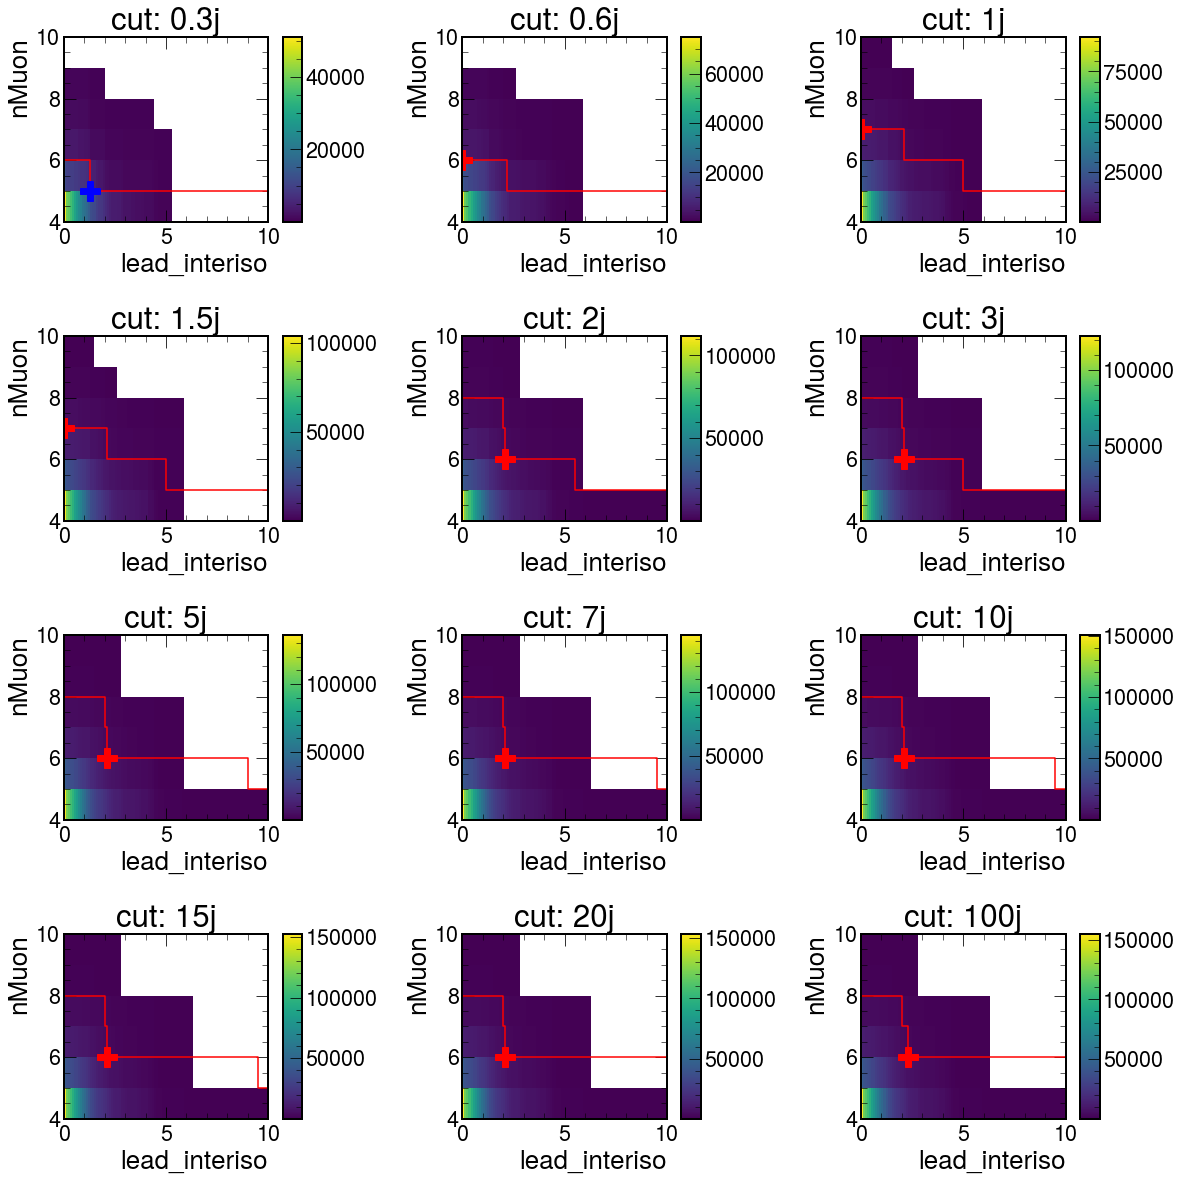

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018


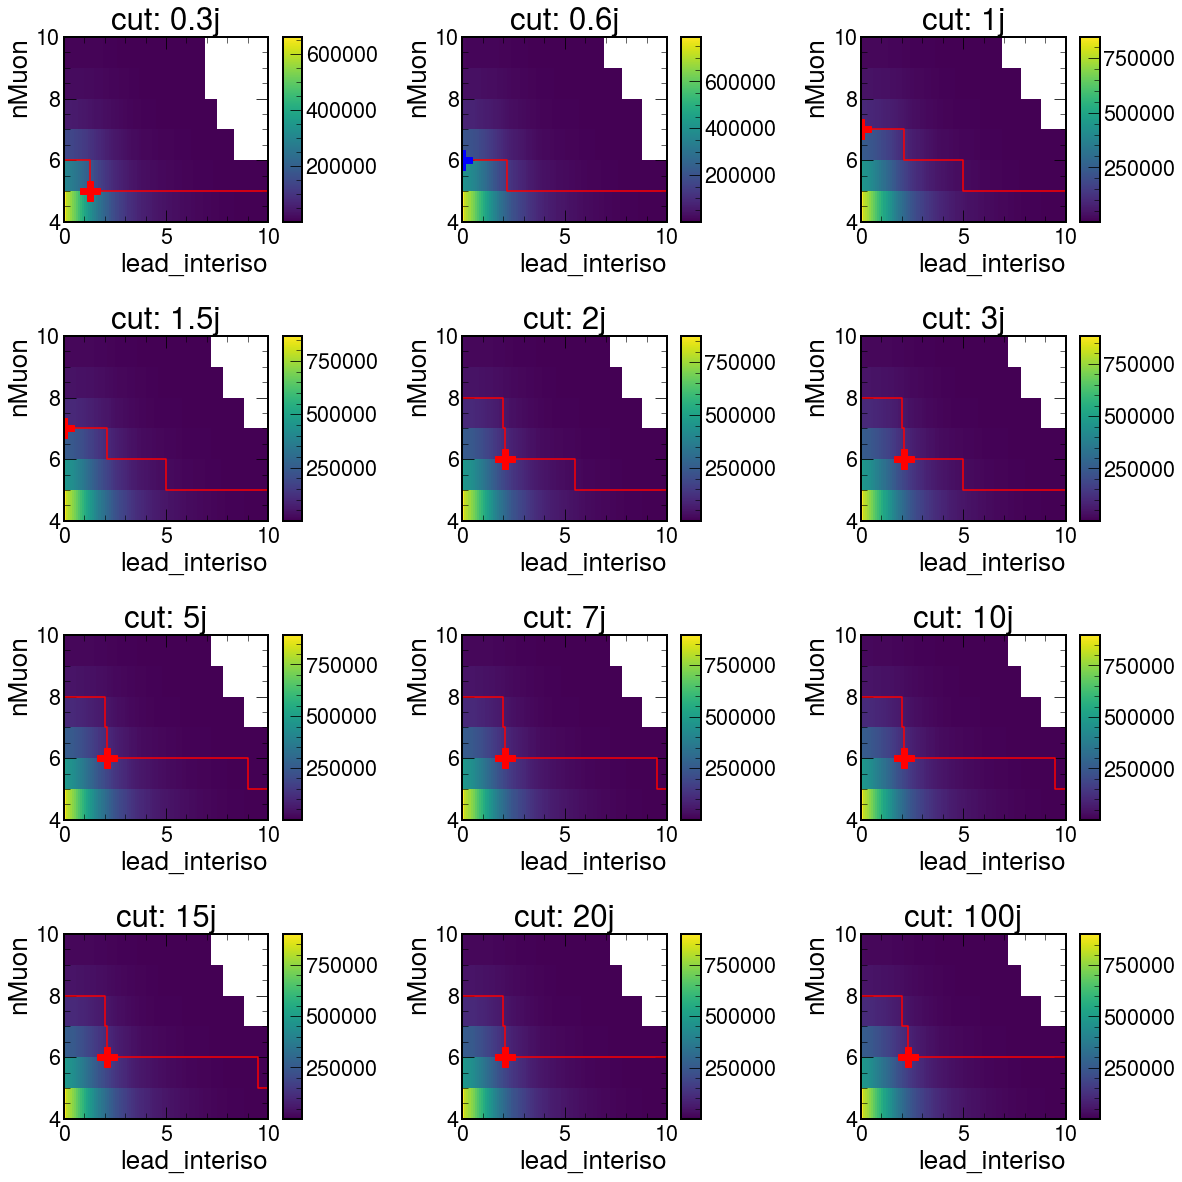

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018


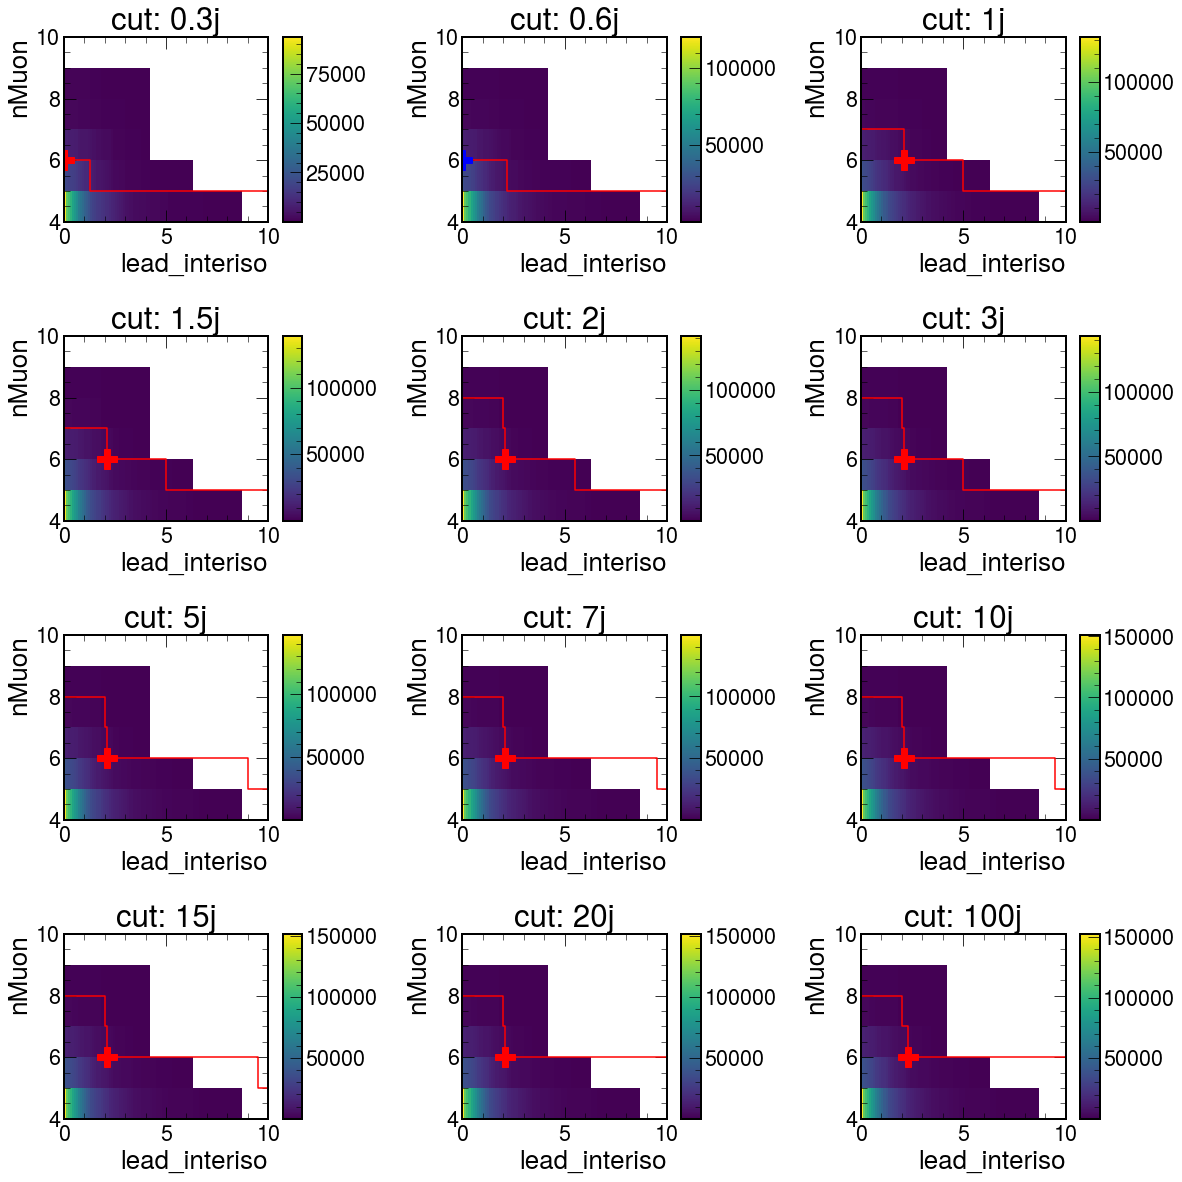

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018


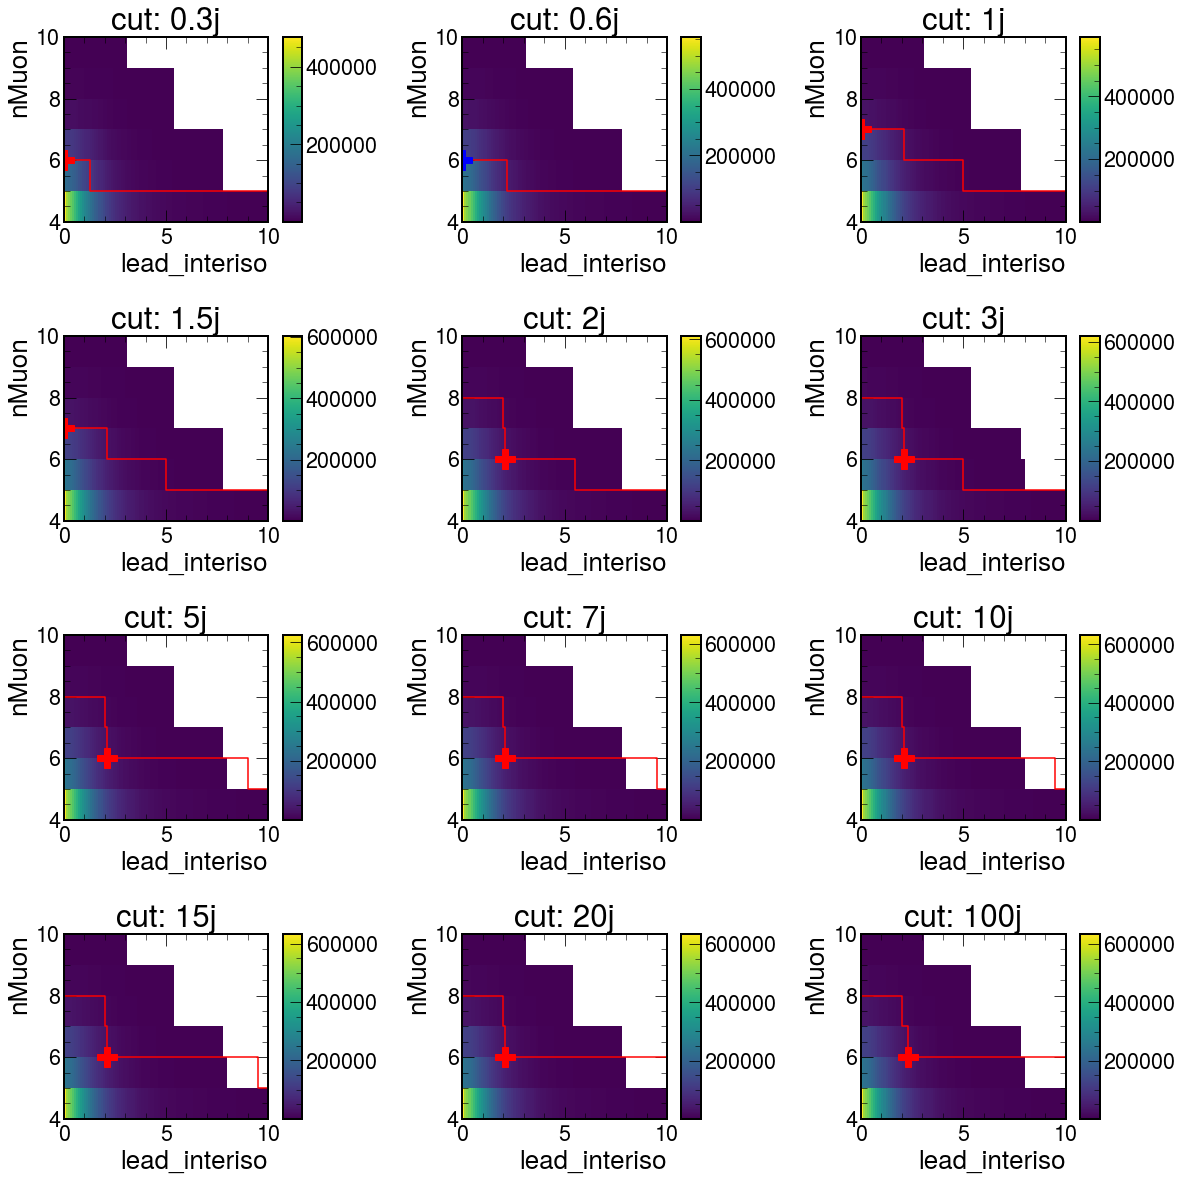

signal is SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018


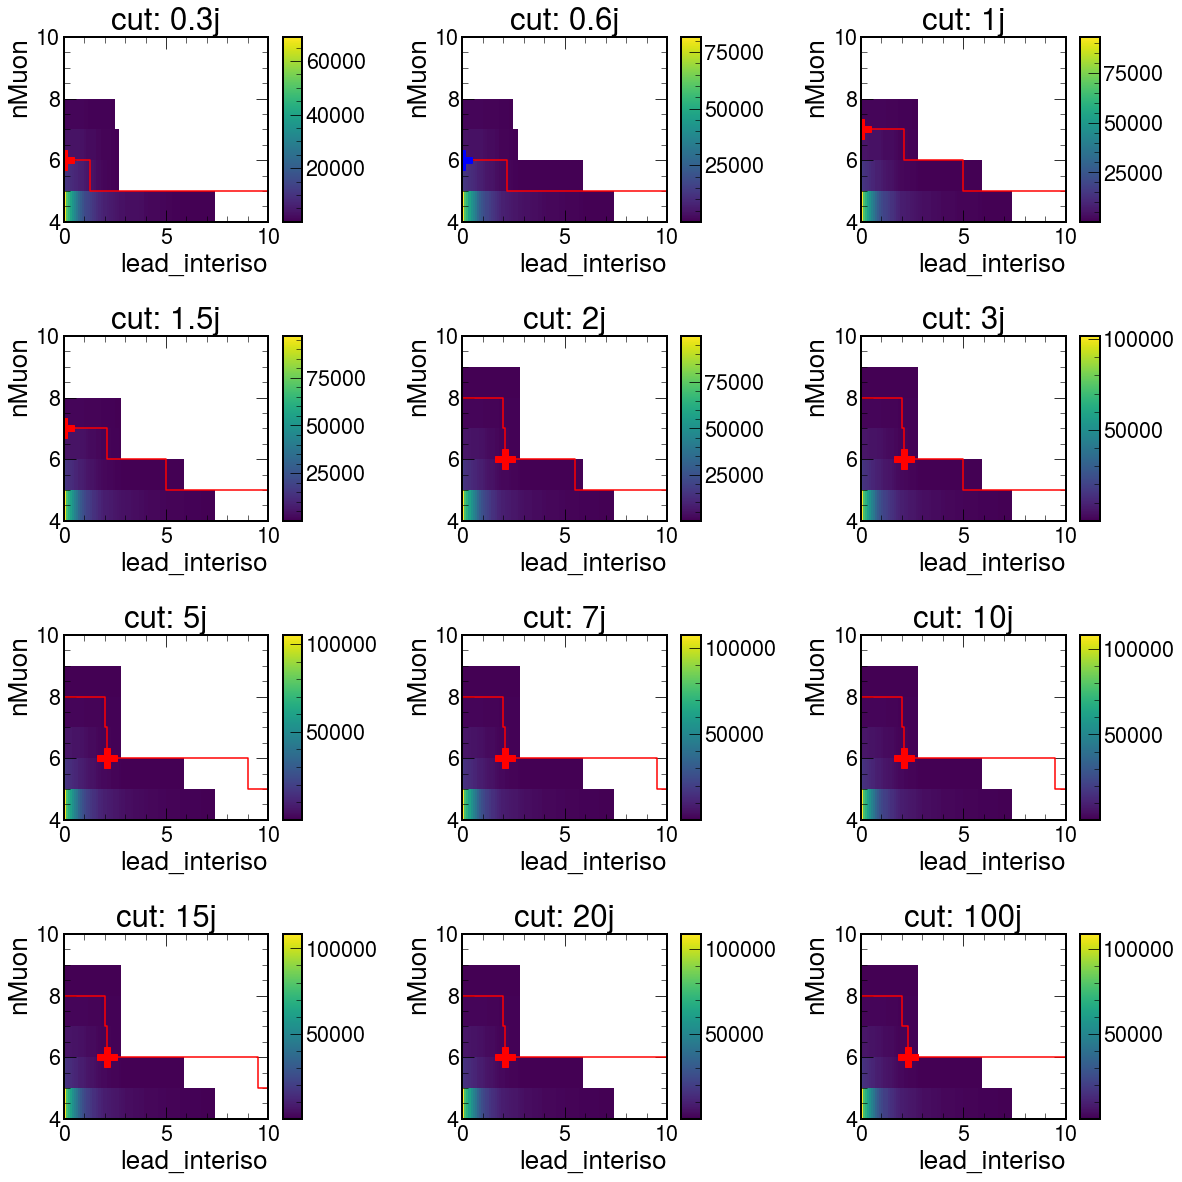

In [93]:
histograms = ['lead_interiso_vs_muon_iso_cut_vs_nMuon']
signals = [
    'SUEP-m125-darkPho_2018',
    'SUEP-m125-darkPhoHad_2018',
    'SUEP-m400-darkPhoHad_2018',
    'SUEP-m1000-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.35_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.7_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-1.4_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-0.5_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-2_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-4_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-1_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-4_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-2_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
]

muon_iso_cuts = [0.3j, 0.6j, 1j, 1.5j, 2j, 3j, 5j, 7j, 10j, 15j, 20j, 100j]
points = {
    0.3j: [(0, 6), (1.3, 5)],
    0.6j: [(0, 6), (2.2, 5)],
    1j: [(0, 7), (2.1, 6), (5, 5)],
    1.5j: [(0, 7), (2.1, 6), (5, 5)],
    2j: [(0, 8), (2, 7), (2.1, 6), (5.5, 5)],
    3j: [(0, 8), (2, 7), (2.1, 6), (5, 5)],
    5j: [(0, 8), (2, 7), (2.1, 6), (9, 5)],
    7j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    10j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    15j: [(0, 8), (2, 7), (2.1, 6), (9.5, 5)],
    20j: [(0, 8), (2, 7), (2.1, 6)],
    100j: [(0, 8), (2, 7), (2.3, 6)],
}

for signal in signals:
    h_s = plots[signal]['lead_interiso_vs_muon_iso_cut_vs_nMuon'].copy()
    fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(17, 17))
    print(f"signal is {signal}")
    ax_i, ax_j = 0, 0
    global_max = 0
    max_global_point = None
    max_global_axs = None
    for iso_cut in muon_iso_cuts:
        if ax_i == 3:
            ax_i = 0
            ax_j += 1
        h_s_cumsum = h_s[:, iso_cut, :].copy().reset()
        for x in range(100):
            for y in range(6):
                h_s_cumsum[x, y] = h_s[x::sum, iso_cut, y::sum]
        hep.hist2dplot(
            h_s_cumsum, 
            ax=axs[ax_j, ax_i],
            #norm=matplotlib.colors.LogNorm(),
            cmin=1
        )
        axs[ax_j, ax_i].set_title(f"cut: {iso_cut}")
        line_x, line_y = [], []
        for i in range(len(points[iso_cut])):
            line_x.append(points[iso_cut][i][0])
            line_y.append(points[iso_cut][i][1])
            if i < len(points[iso_cut])-1:
                line_x.append(points[iso_cut][i+1][0])
                line_y.append(points[iso_cut][i][1]) 
        line_x.append(10)
        line_y.append(points[iso_cut][-1][1])
        axs[ax_j, ax_i].plot(line_x, line_y, color='r')
        temp_max = 0
        max_point = points[iso_cut][0]
        #print(f"{iso_cut}: [", end="")
        for p in points[iso_cut]:
            #print(f"{h_s_cumsum[p[0]*1j, p[1]*1j].value:.2f}, ", end="")
            if h_s_cumsum[p[0]*1j, p[1]*1j].value > temp_max:
                temp_max = h_s_cumsum[p[0]*1j, p[1]*1j].value
                max_point = p
        #print("]")
        if temp_max > global_max:
            global_max = temp_max
            max_global_point = max_point
            max_global_axs = (ax_j, ax_i)
        axs[ax_j, ax_i].plot(
            *max_point, color='r', marker='P', markersize=20
        )
        ax_i += 1
    axs[max_global_axs[0], max_global_axs[1]].plot(
        *max_global_point, color='b', marker='P', markersize=20
    )
    fig.tight_layout()
    plt.show()

In [28]:
processes = [
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
signal = [
    'SUEP-m400-darkPhoHad_2018',
    'SUEP-m1000-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
]

for p in processes:
    print(p)
    vals_tot = plots[p]['nBtagJets_medium'][::sum, ::sum]
    vals_cut = plots[p]['nBtagJets_medium'][:2j:sum, ::sum]
    print(f"\tyield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
#     print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
#     hep.hist2dplot(
#         plots[p]['nBtagJets_medium'][::1j,::1j],
#         norm=matplotlib.colors.LogNorm(),
#     )
#     plt.show()

for s in signal:
    print(s)
    vals_tot = plots[s]['nBtagJets_medium'][::sum, ::sum]
    vals_cut = plots[s]['nBtagJets_medium'][:2j:sum, ::sum]
    print(f"\tyield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
#     print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
#     hep.hist2dplot(
#         plots[s]['nBtagJets_medium'][::1j,::1j],
#     )
#     plt.show()

VV_2018
	yield tot: 0.465 ± 0.133
TTJets_2018
	yield tot: 1.243 ± 1.708
DY_NLO_all_2018
	yield tot: 0.000 ± 0.000
QCD_Pt_MuEnriched_2018
	yield tot: 0.000 ± 0.000
SUEP-m400-darkPhoHad_2018
	yield tot: 4688.014 ± 284.253
SUEP-m1000-darkPhoHad_2018
	yield tot: 1766.637 ± 42.178
SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018
	yield tot: 20214.706 ± 2232.341
SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018
	yield tot: 21381.906 ± 2319.193
SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018
	yield tot: 9614.311 ± 1539.522
SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018
	yield tot: 12079.519 ± 1725.646
SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018
	yield tot: 5916.499 ± 1207.700


## Section with histograms for fitting

Will plot:
  - lead_interiso_vs_av_muon_pt
  
both as stacked & non-stacked plots.

## Show post-cut plots

Plotting:  ('lead_interiso_vs_av_muon_pt', 'nMuon')


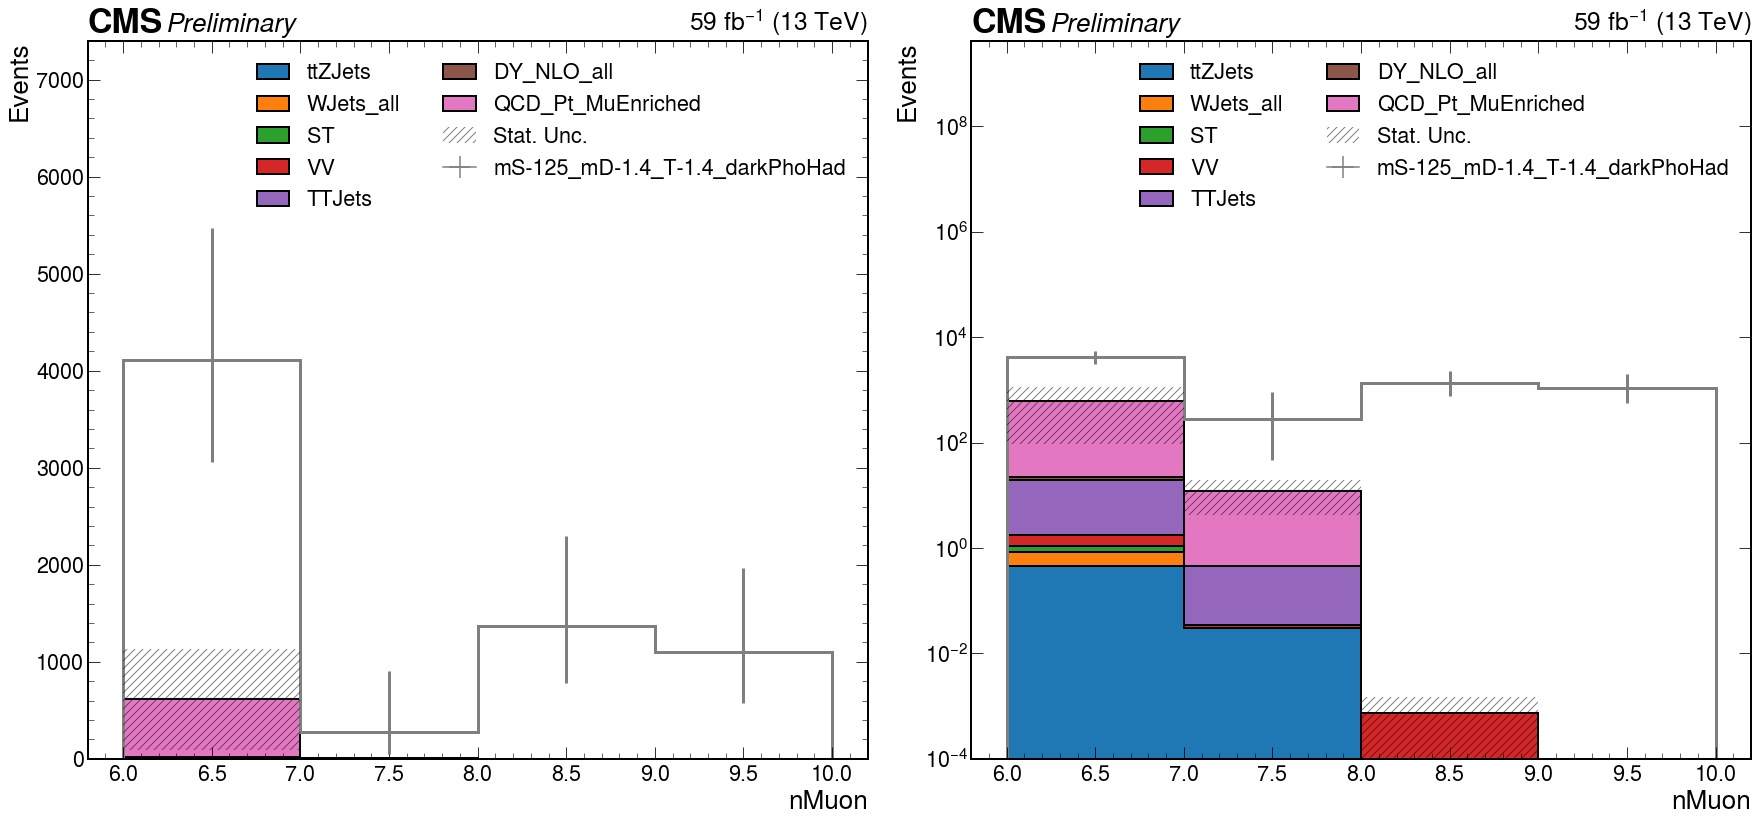

Plotting:  ('lead_interiso_64', 'lead_interiso')


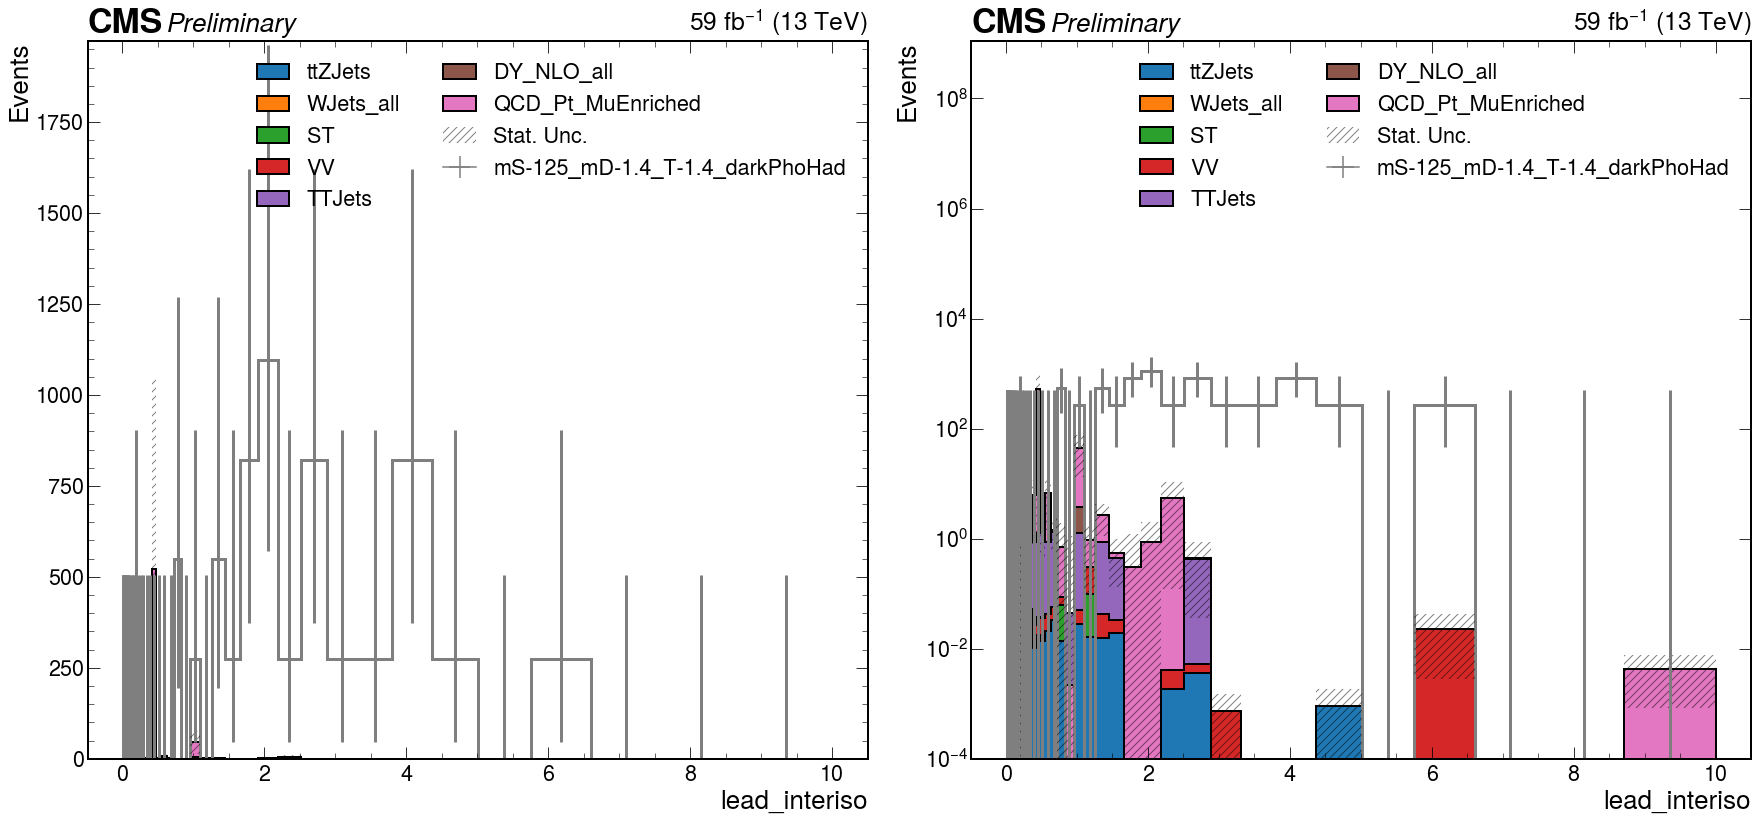

Plotting:  ('Muon_miniPFRelIso_all_max', 'Muon_miniPFRelIso_all_max')


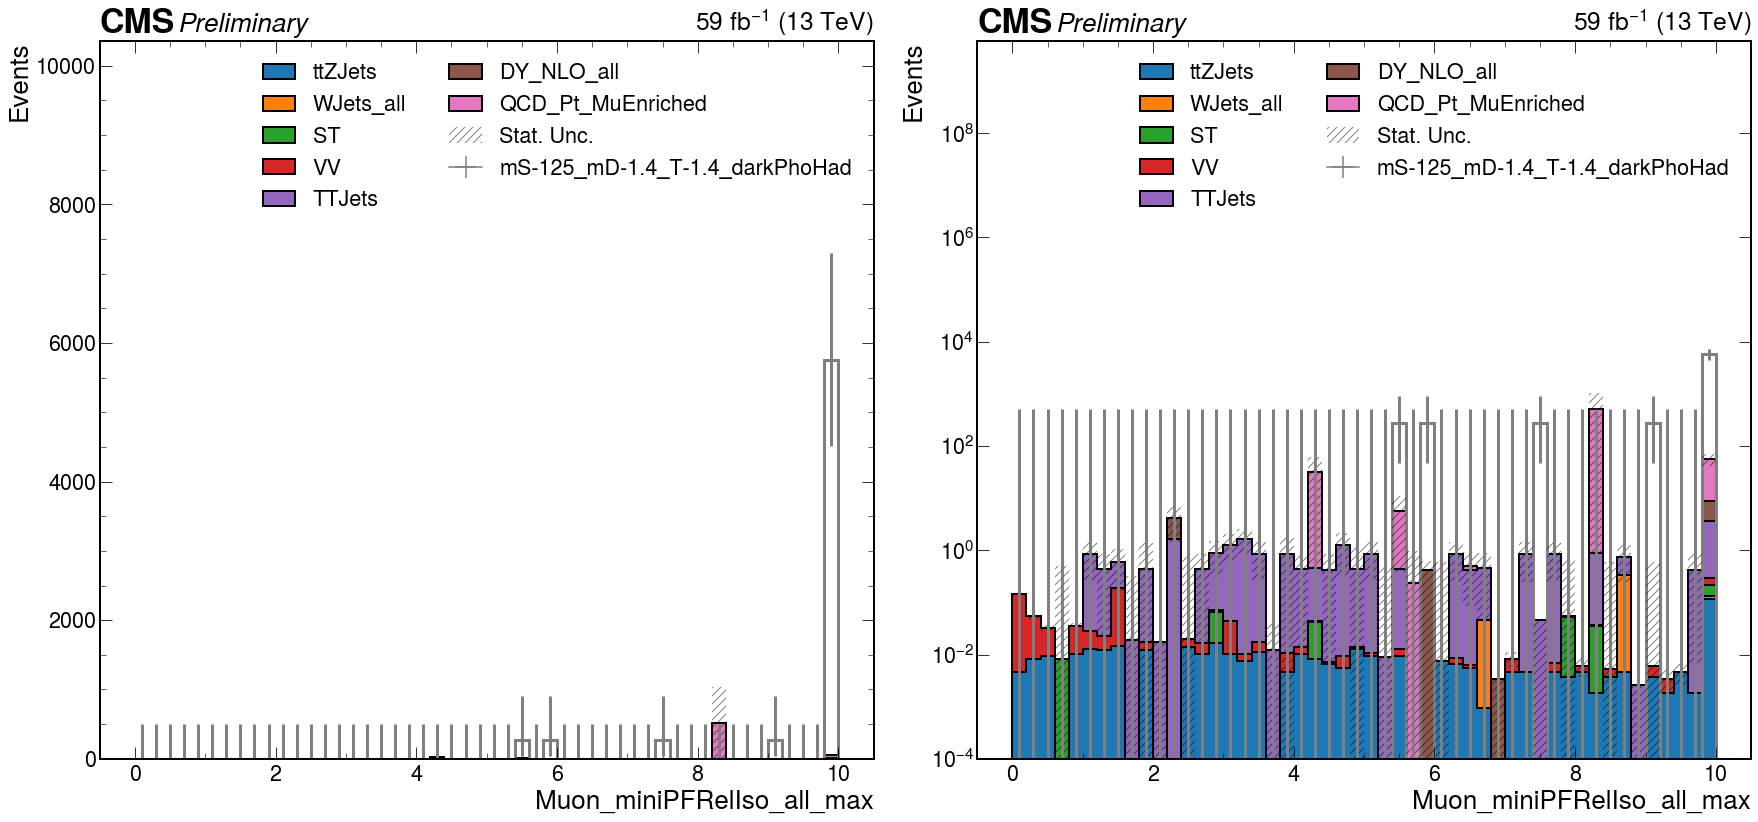

In [51]:
processes = [
    #'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
signals = [
    #'SUEP-m125-darkPho_2018',
    #'SUEP-m125-darkPhoHad_2018',
    #'SUEP-m400-darkPhoHad_2018',
    #'SUEP-m1000-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.35_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-0.7_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-1.4_temp-1.4_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-2_temp-0.5_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-2_temp-2_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-2_temp-4_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-4_temp-1_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-4_temp-4_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-2_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018',
    #'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
]
int_lumi = 59

plot_set = [
    #[
    #    ('lead_interiso_vs_av_muon_pt','lead_interiso'),
    #    {
    #        'xlog': True,
    #        'cut': (slice(None), slice(None, None, sum), slice(None, None, sum), slice(6j, None, sum)),
    #        #'slc': slice(1j, 10j)
    #    }
    #],
    #[
    #    ('lead_interiso_vs_av_muon_pt','av_muon_pt'),
    #    {
    #        'xlog': True,
    #        'cut': (slice(None, None, sum), slice(None), slice(None, None, sum), slice(6j, None, sum)),
    #    }
    #],
    [
        ('lead_interiso_vs_av_muon_pt','nMuon'),
        {
            'cut': (slice(None, None, sum), slice(None, None, sum), slice(None, None, sum), slice(None)),
        }
    ],
    #[('lead_interiso_4','lead_interiso'), {'xlog': True}],
    #[('lead_interiso_8','lead_interiso'), {'xlog': True}],
    #[('lead_interiso_16','lead_interiso'), {'xlog': True}],
    #[('lead_interiso_32','lead_interiso'), {'xlog': True}],
    [('lead_interiso_64','lead_interiso'), {'xlog': False}],
    [('Muon_miniPFRelIso_all_max','Muon_miniPFRelIso_all_max'), {'xlog': False}],
    #[('Muon_miniPFRelIso_all','Muon_miniPFRelIso_all'), {'xlog': False}],
    #[('Muon_jetPtRelv2','Muon_jetPtRelv2'), {'xlog': True}],
    #[('Muon_jetRelIso','Muon_jetRelIso'), {'xlog': True}],
    #[('Muon_Jet_btagDeepFlavB','Muon_Jet_btagDeepFlavB'), {'xlog': False}],
    #[('nBtagJets_loose','nBtagJets_loose'), {}],
    #[('nBtagJets_medium','nBtagJets_medium'), {}],
    #[('nBtagJets_tight','nBtagJets_tight'), {}],
]


for plot_i in plot_set:
    if plot_i[0][0] not in plots[processes[0]].keys():
        continue
    print("Plotting: ", plot_i[0])

    # Stack with ratio for processes
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25, 12))
    plot_utils_extras.plot_stack(
        plots=plots, 
        bkg_list=processes, 
        sig_list=signals,
        label=plot_i[0],
        ylog=False,
        override_slice=False,
        fig=fig,
        ax=ax[0],
        int_lumi=int_lumi,
        #ylim= (0, 1e5),
        **plot_i[1]
    )
    plot_utils_extras.plot_stack(
        plots=plots, 
        bkg_list=processes, 
        sig_list=signals,
        label=plot_i[0],
        ylog=True,
        override_slice=False,
        fig=fig,
        ax=ax[1],
        int_lumi=int_lumi,
        #ylim= (1e-4, 1e8),
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()

    # Overlay for processes
#     fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 11))
#     plot_utils_extras.plot_overlay(
#         plots=plots, 
#         bkg_list=processes, 
#         label=plot_i[0], 
#         override_slice=True,
#         fig=fig,
#         ax=ax[0],
#         per_muon=True,
#         int_lumi=int_lumi,
#         **plot_i[1]
#     )
#     plot_utils_extras.plot_overlay(
#         plots=plots, 
#         bkg_list=processes, 
#         label=plot_i[0], 
#         override_slice=True,
#         fig=fig,
#         ax=ax[1],
#         ylog=True,
#         per_muon=True,
#         int_lumi=int_lumi,
#         **plot_i[1]
#     )
#     plt.tight_layout()
#     plt.show()

## 2D plots per process

VVV_2018
yield tot: 0.027 ± 0.003
yield cut: 0.000 ± 0.000


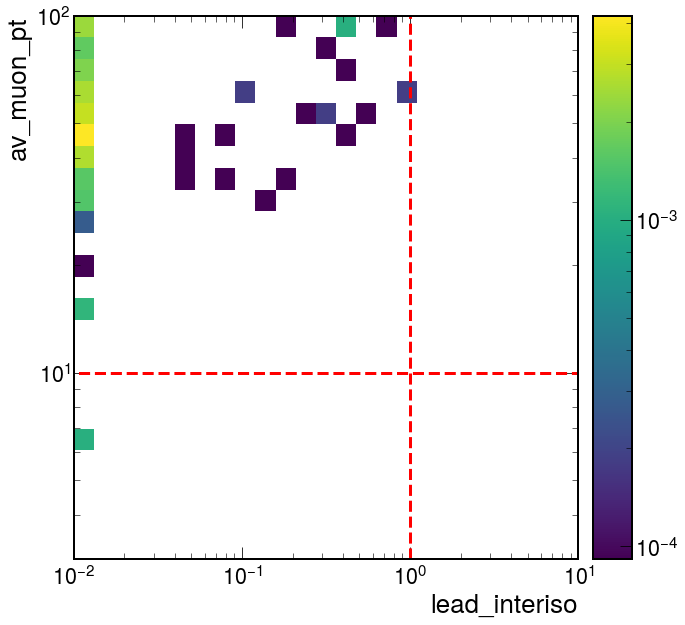

ttZJets_2018
yield tot: 0.478 ± 0.021
yield cut: 0.000 ± 0.000


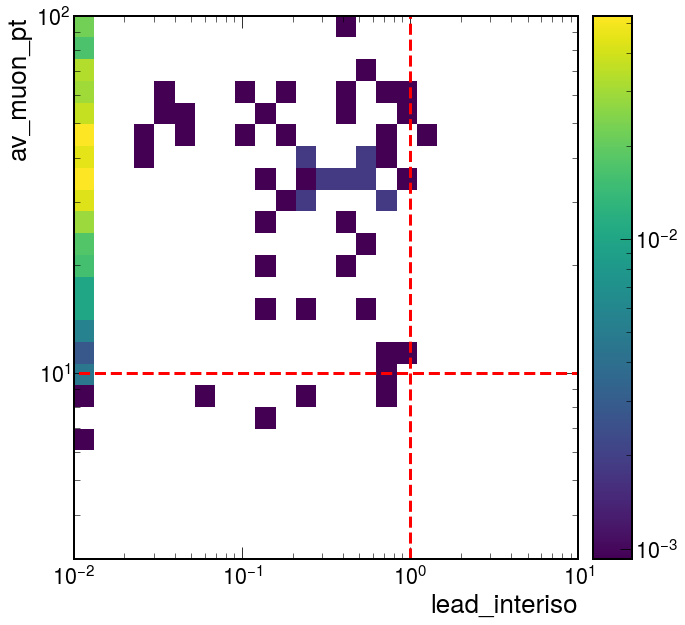

WJets_all_2018
yield tot: 0.395 ± 0.334
yield cut: 0.000 ± 0.000


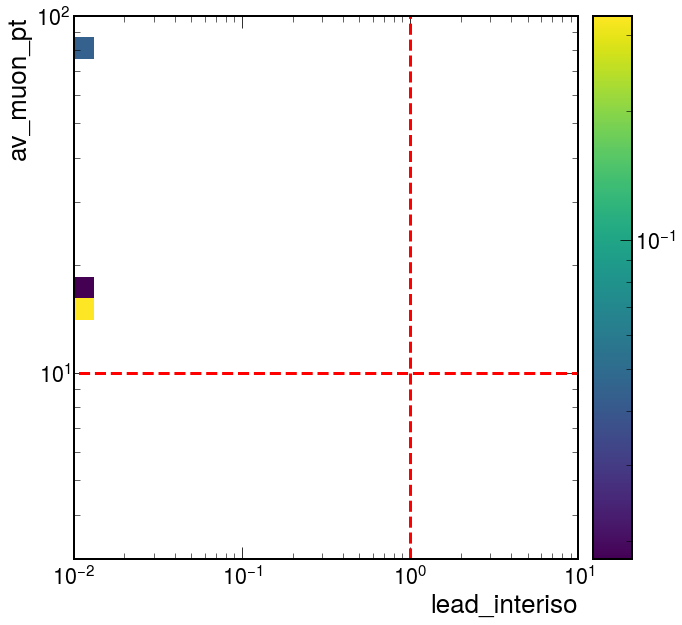

ST_2018
yield tot: 0.240 ± 0.139
yield cut: 0.034 ± 0.034


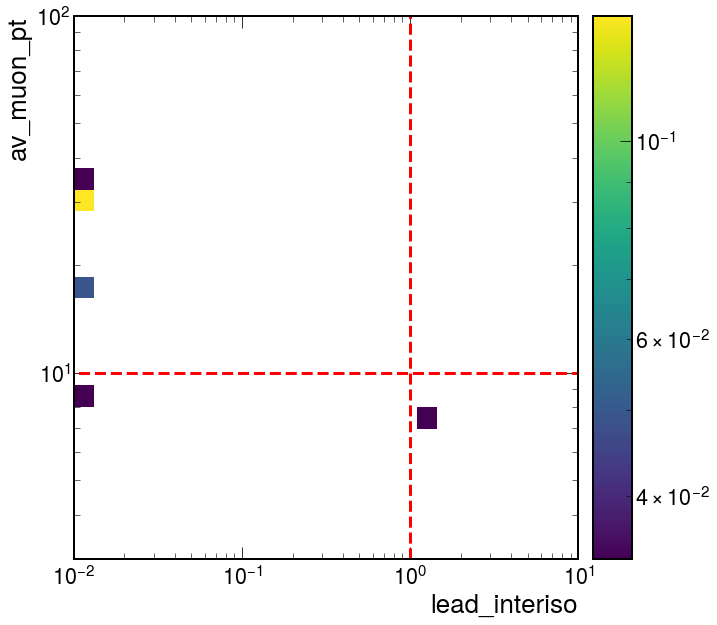

VV_2018
yield tot: 0.662 ± 0.137
yield cut: 0.000 ± 0.000


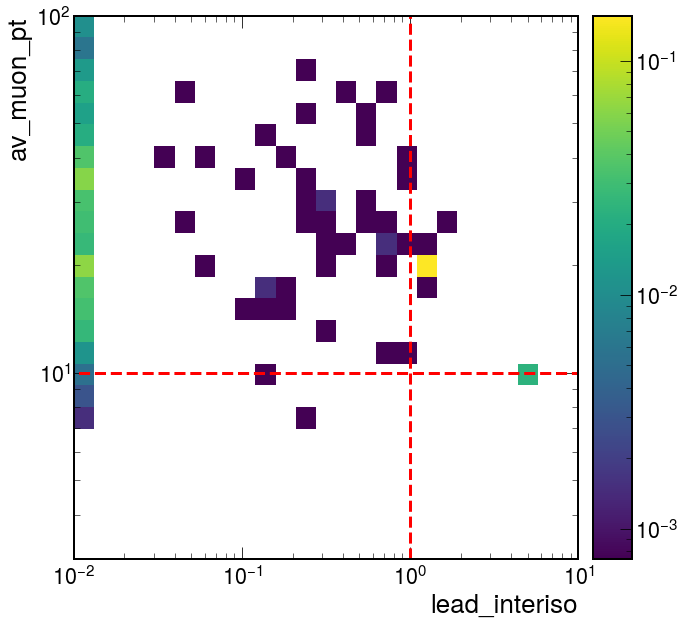

TTJets_2018
yield tot: 18.228 ± 5.006
yield cut: 0.000 ± 0.000


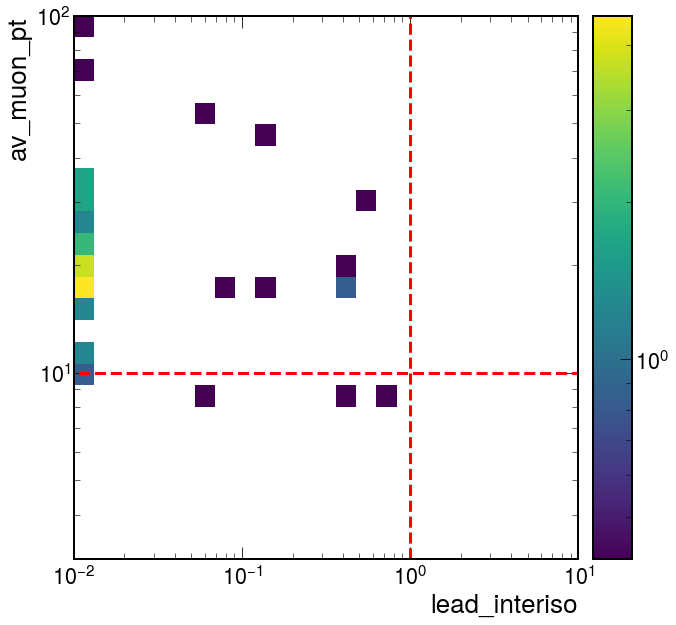

DY_NLO_all_2018
yield tot: 2.519 ± 5.633
yield cut: 0.000 ± 0.000


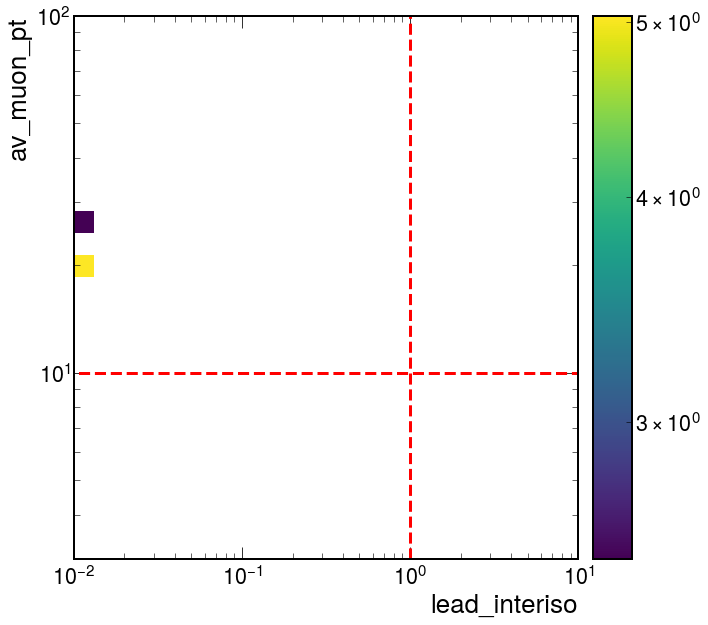

QCD_Pt_MuEnriched_2018
yield tot: 604.434 ± 521.272
yield cut: 31.730 ± 30.535


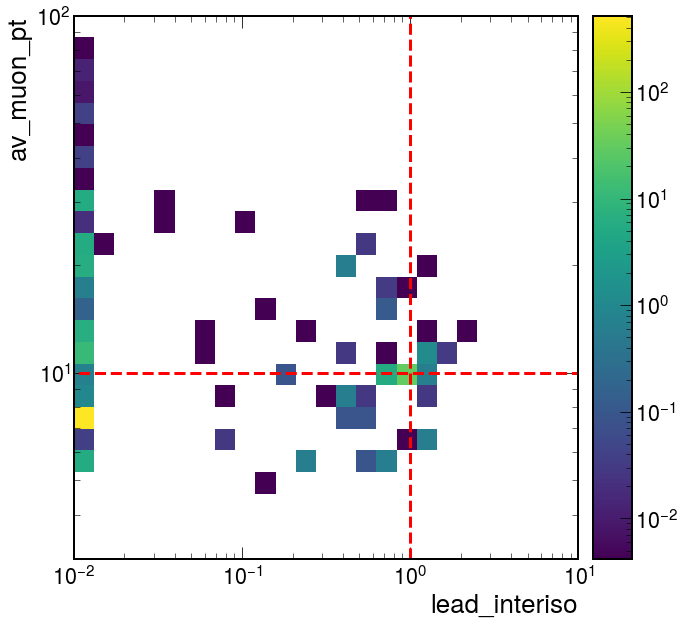

SUEP-m125-darkPho_2018
yield tot: 241024.101 ± 7742.819
yield cut: 186050.593 ± 6802.692


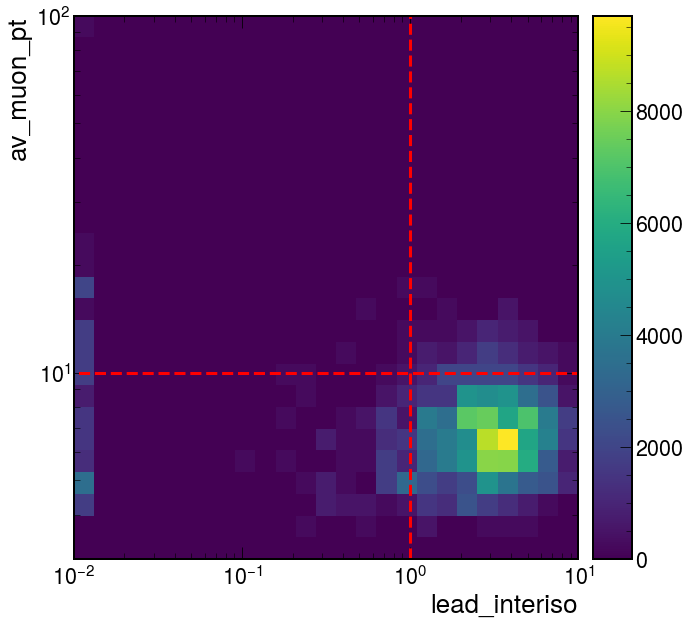

SUEP-m125-darkPhoHad_2018
yield tot: 23634.371 ± 2450.771
yield cut: 10418.033 ± 1627.025


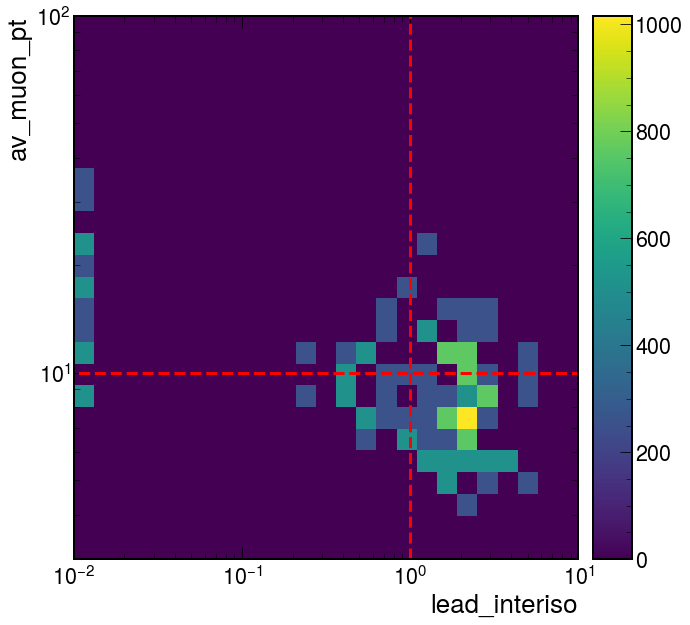

SUEP-m400-darkPho_2018
yield tot: 104571.863 ± 1349.231
yield cut: 80878.823 ± 1186.576


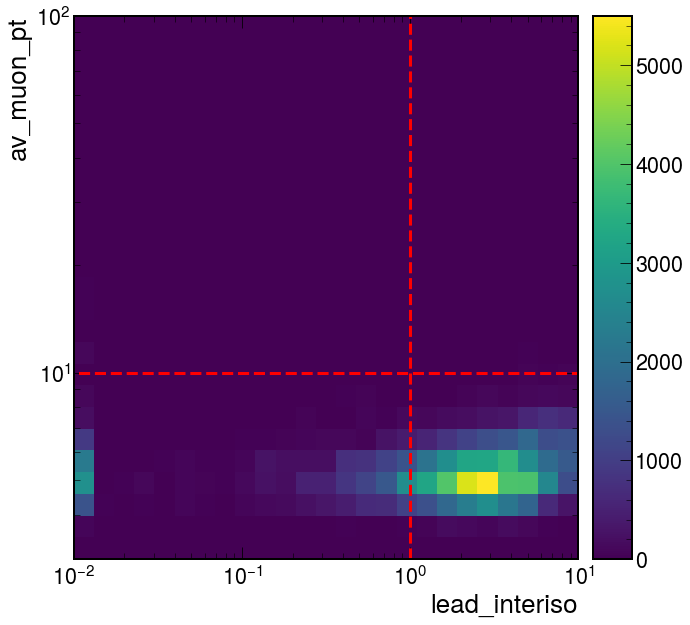

SUEP-m400-darkPhoHad_2018
yield tot: 11943.421 ± 453.693
yield cut: 8151.711 ± 374.816


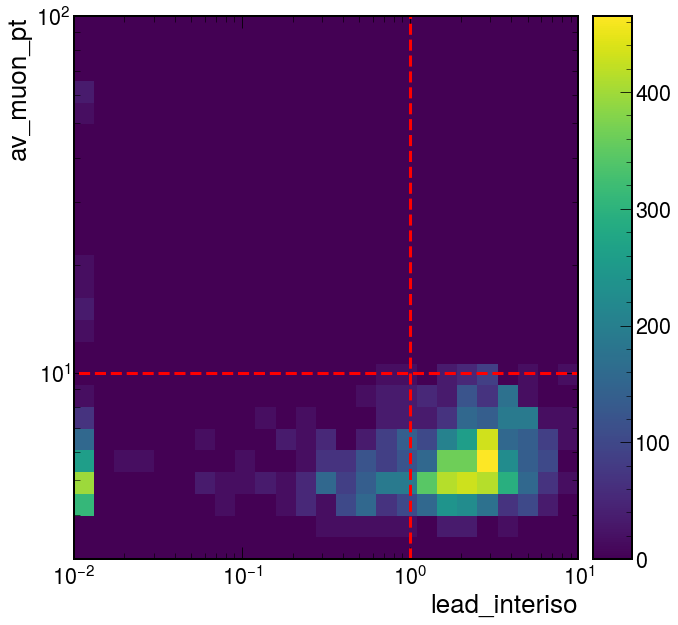

SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018
yield tot: 532238.407 ± 11454.599
yield cut: 151117.250 ± 6103.568


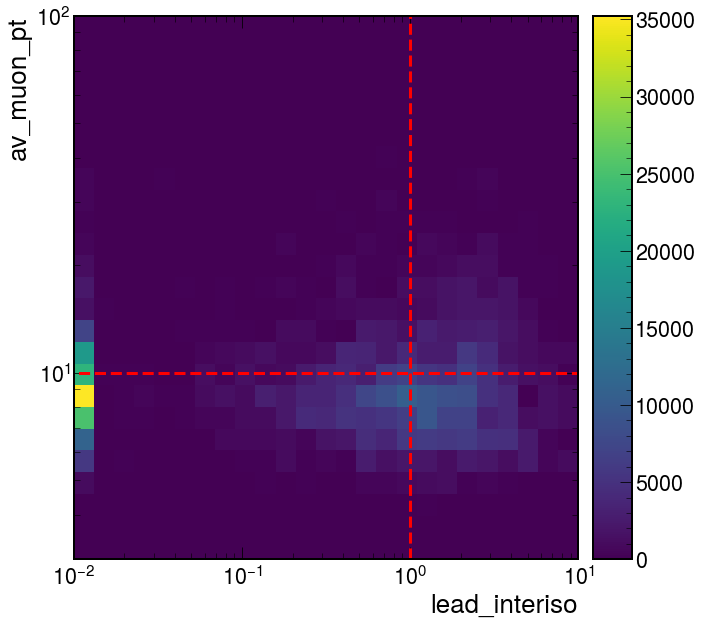

SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018
yield tot: 39196.807 ± 3108.509
yield cut: 9121.270 ± 1499.527


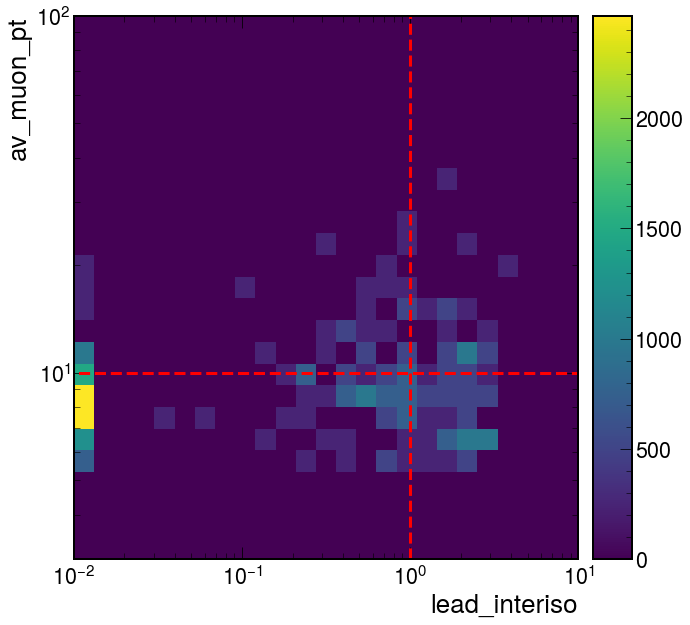

SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018
yield tot: 510298.056 ± 11216.019
yield cut: 131888.628 ± 5702.043


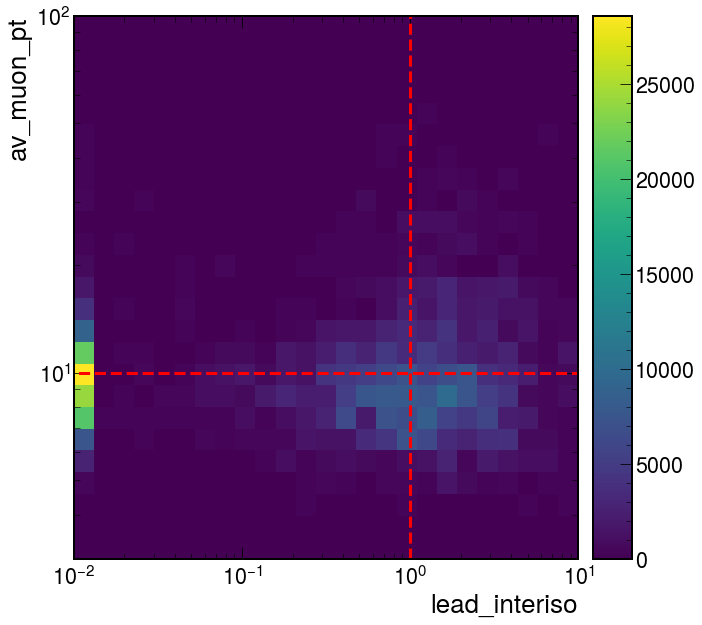

SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018
yield tot: 27167.598 ± 2614.203
yield cut: 6288.796 ± 1257.759


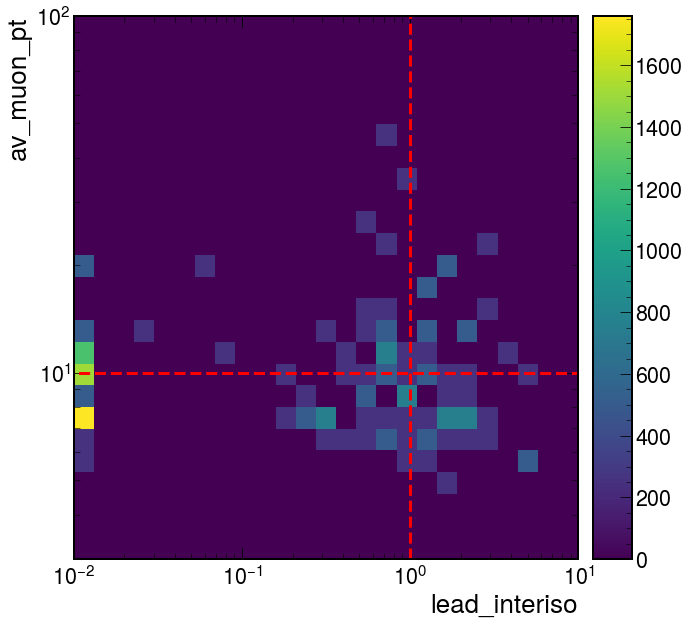

SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018
yield tot: 266896.499 ± 8193.797
yield cut: 21381.906 ± 2319.193


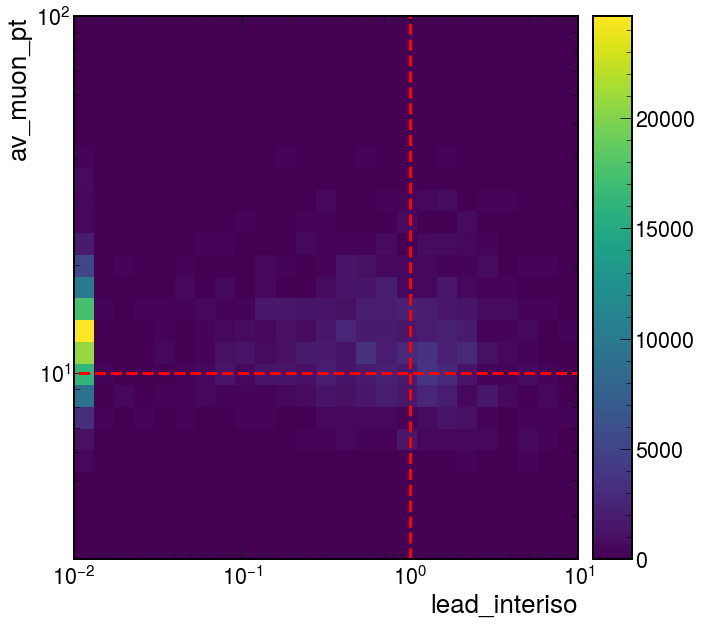

SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018
yield tot: 12819.082 ± 1777.687
yield cut: 1725.646 ± 652.233


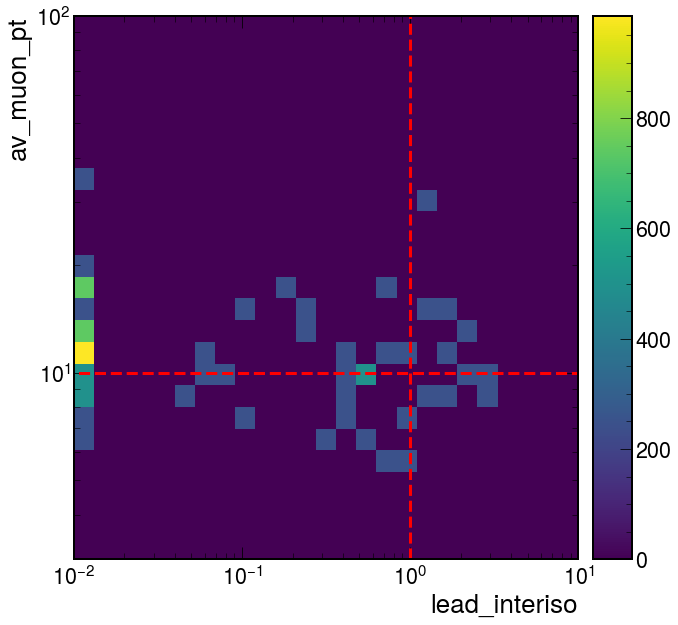

SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018
yield tot: 264129.429 ± 8151.211
yield cut: 28173.806 ± 2662.174


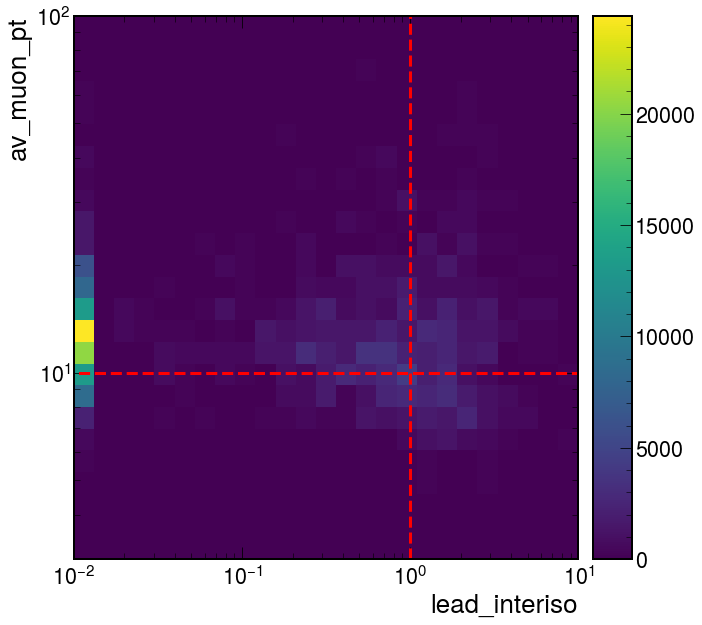

SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018
yield tot: 13805.165 ± 1844.793
yield cut: 1479.125 ± 603.850


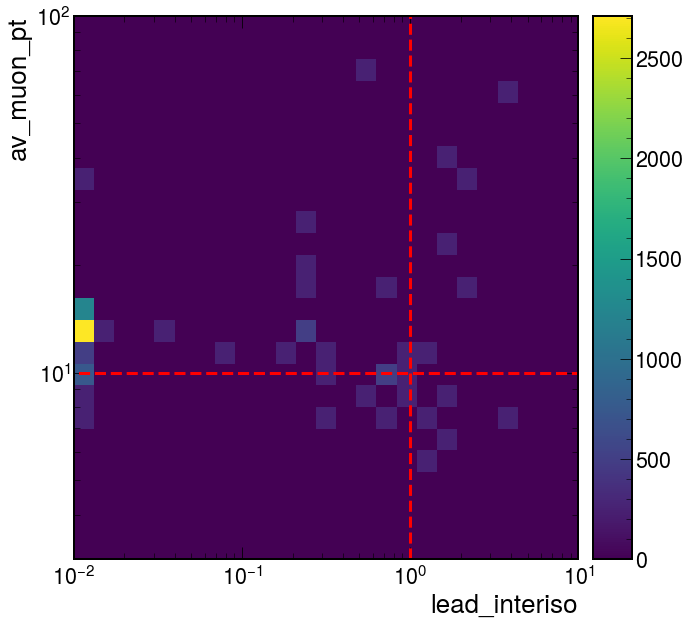

SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018
yield tot: 125775.918 ± 5624.870
yield cut: 1509.311 ± 616.174


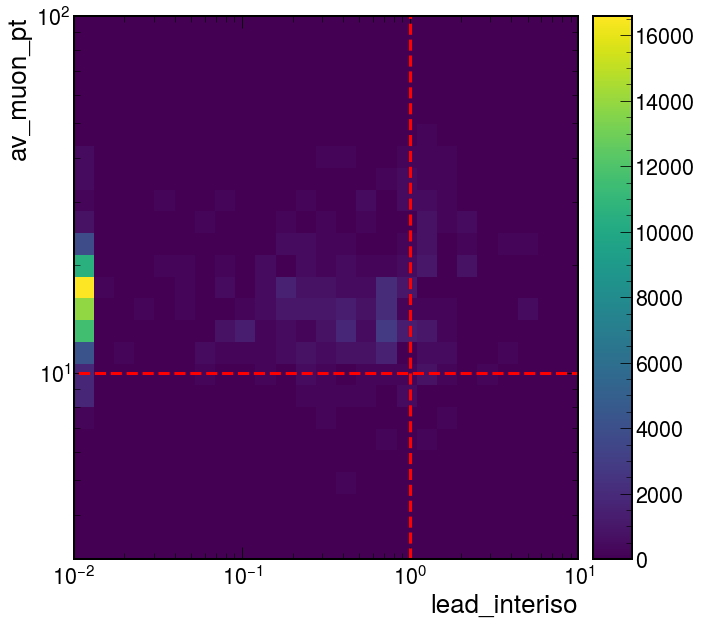

SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018
yield tot: 6409.541 ± 1257.014
yield cut: 246.521 ± 246.521


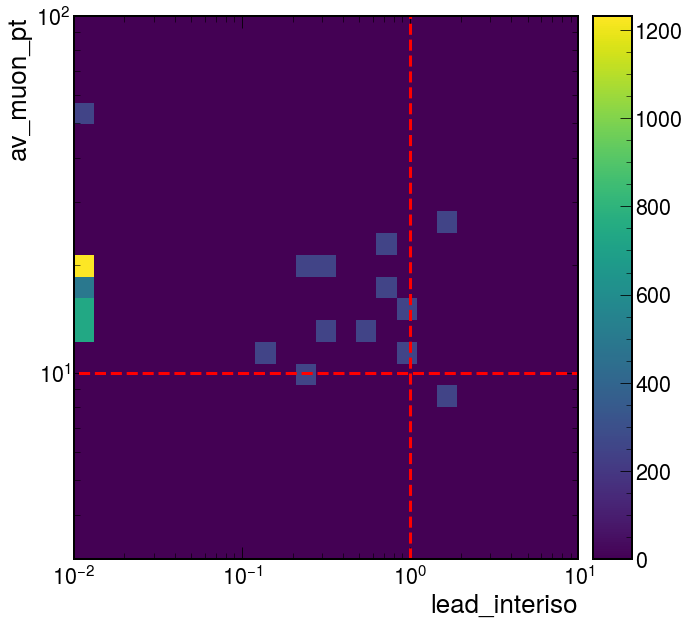

In [39]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]
signal = [
    'SUEP-m125-darkPho_2018',
    'SUEP-m125-darkPhoHad_2018',
    'SUEP-m400-darkPho_2018',
    'SUEP-m400-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-2_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-8_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-4_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-16_decay-darkPhoHad_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPho_2018',
    'SUEP_ggH-channel_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
]

for p in processes:
    print(p)
    vals_tot = plots[p]['lead_interiso_ele_vs_av_muon_pt'][::sum, ::sum, ::sum, ::sum]
    vals_cut = plots[p]['lead_interiso_ele_vs_av_muon_pt'][1j:10j:sum, 3j:10j:sum, ::sum, ::sum]
    print(f"yield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
    print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
    hep.hist2dplot(
        plots[p]['lead_interiso_ele_vs_av_muon_pt'][::2j,::2j,::sum,::sum],
        norm=matplotlib.colors.LogNorm(),
    )
    plt.plot([1e-3, 10], [10, 10], c='r', lw=3, ls='--')
    plt.plot([1, 1], [3, 500], c='r', lw=3, ls='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

for s in signal:
    print(s)
    vals_tot = plots[s]['lead_interiso_ele_vs_av_muon_pt'][::sum, ::sum, ::sum, ::sum]
    vals_cut = plots[s]['lead_interiso_ele_vs_av_muon_pt'][1j:10j:sum, 3j:10j:sum, ::sum, ::sum]
    print(f"yield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
    print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
    hep.hist2dplot(
        plots[s]['lead_interiso_ele_vs_av_muon_pt'][::2j,::2j,::sum,::sum],
    )
    plt.plot([1e-3, 10], [10, 10], c='r', lw=3, ls='--')
    plt.plot([1, 1], [3, 500], c='r', lw=3, ls='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

## 2D plots for signal per nMuon

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 3
yield tot: 6656.062 ± 1280.960
yield cut: 0.000 ± 0.000


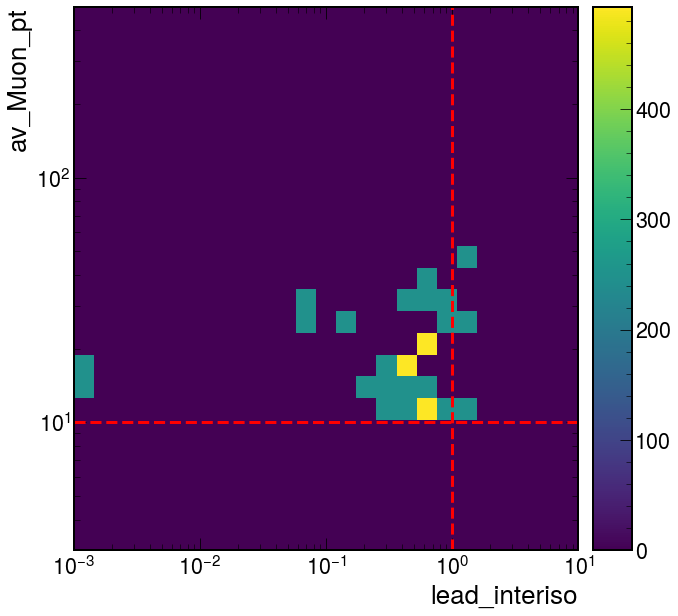

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 4
yield tot: 36238.558 ± 2988.906
yield cut: 493.042 ± 348.633


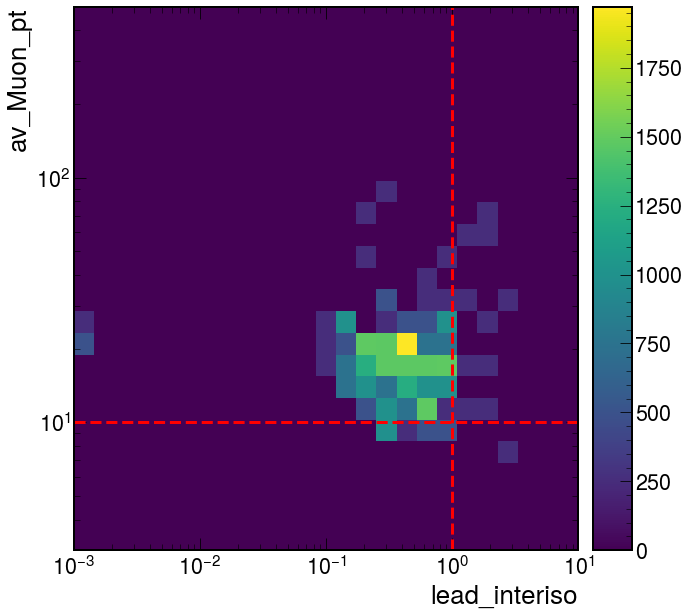

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 5
yield tot: 11339.957 ± 1671.985
yield cut: 739.562 ± 426.987


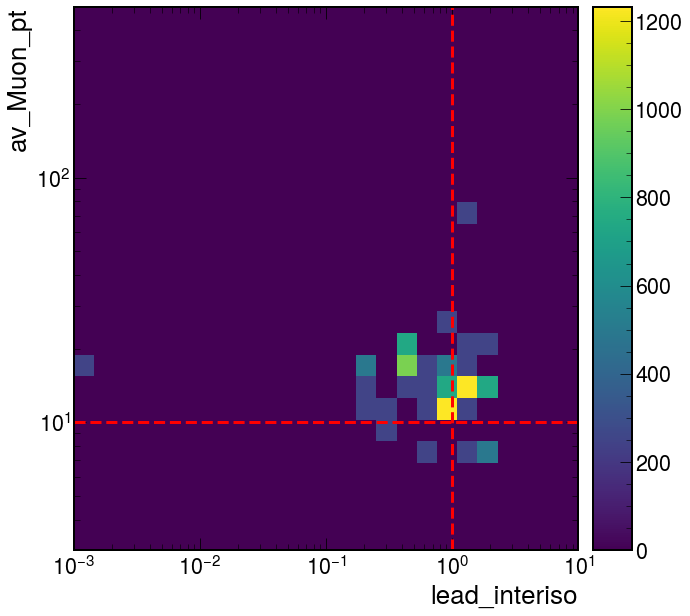

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 6
yield tot: 5423.458 ± 1156.285
yield cut: 0.000 ± 0.000


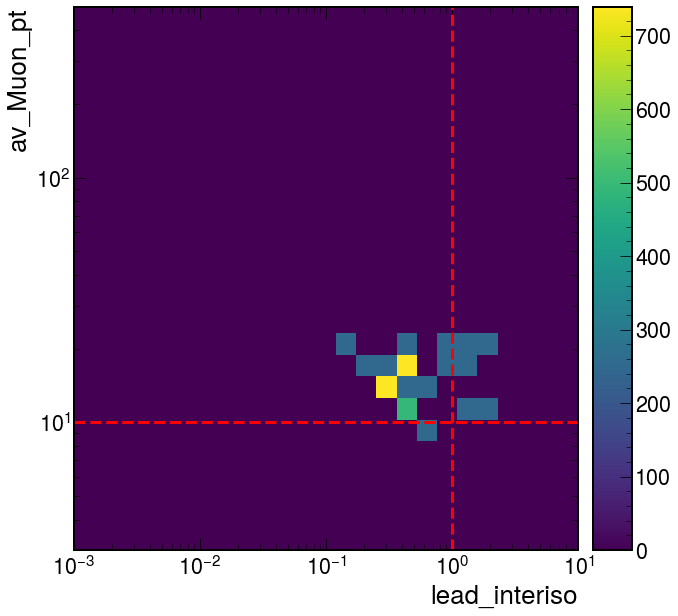

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 7
yield tot: 0.000 ± 0.000
yield cut: 0.000 ± 0.000


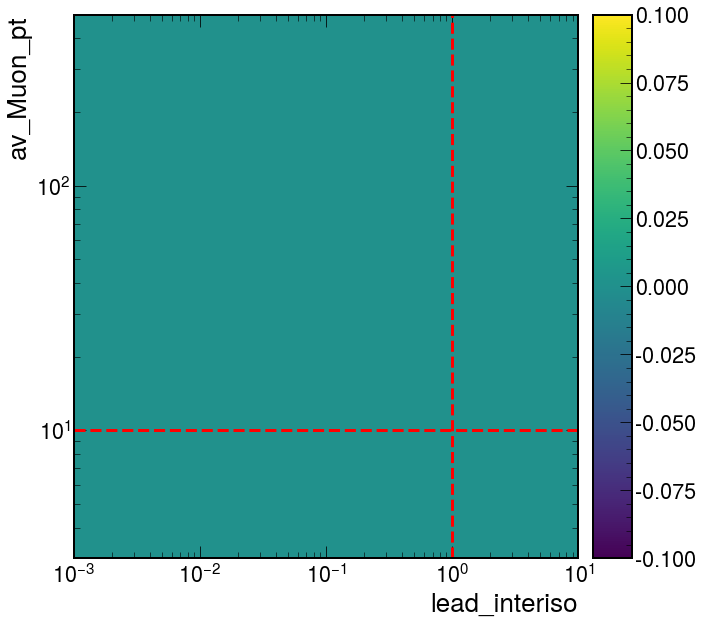

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 8
yield tot: 0.000 ± 0.000
yield cut: 0.000 ± 0.000


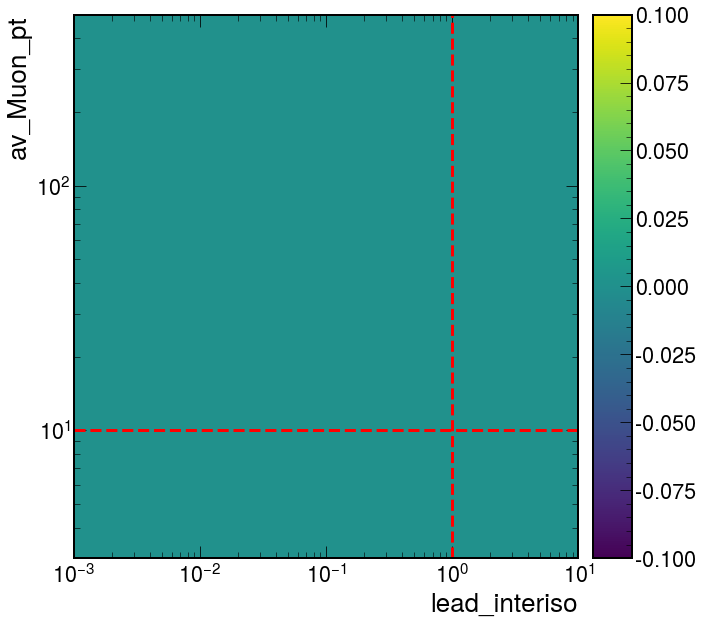

SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018 nMuon = 9
yield tot: 0.000 ± 0.000
yield cut: 0.000 ± 0.000


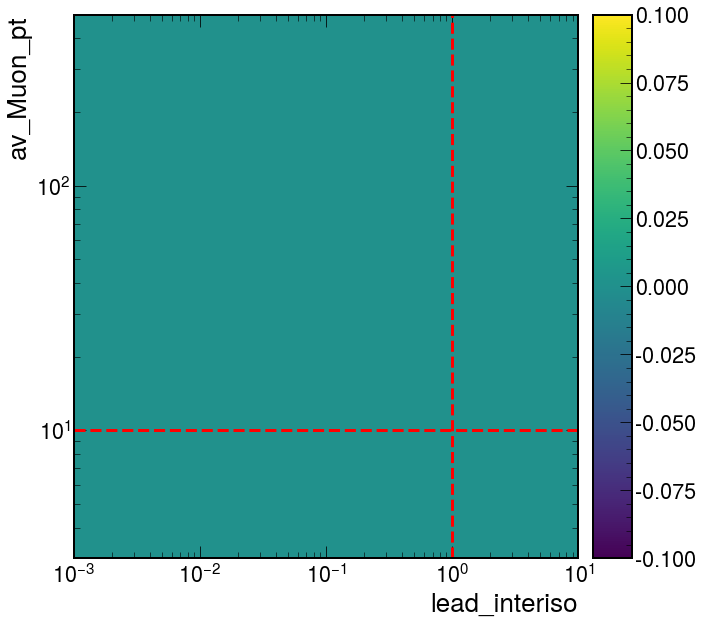

In [36]:
signal = 'SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018'
# signal = 'SUEP-m400-darkPho_2018'
for n in range(3, 10):
    print(signal, "nMuon =", n)
    vals_tot = plots[signal]['lead_interiso_vs_av_muon_pt'][::sum, ::sum, ::sum, n*1j]
    vals_cut = plots[signal]['lead_interiso_vs_av_muon_pt'][1j:10j:sum, 3j:10j:sum, ::sum, n*1j]
    print(f"yield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
    print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
    hep.hist2dplot(
        plots[signal]['lead_interiso_vs_av_muon_pt'][::2j, ::2j, ::sum, n*1j],
    )
    plt.plot([1e-3, 10], [10, 10], c='r', lw=3, ls='--')
    plt.plot([1, 1], [3, 500], c='r', lw=3, ls='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

## Calculate total bkg

In [230]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]

h_tot = None
for p in processes:
    if h_tot is None:
        h_tot = plots[p]['lead_interiso_vs_av_muon_pt'].copy()
    else:
        h_tot += plots[p]['lead_interiso_vs_av_muon_pt'].copy()

### Other vars distributions per nMuon

nMuon = 3
yield tot: 599353.834 ± 2550.598
yield cut: 3107.745 ± 245.949


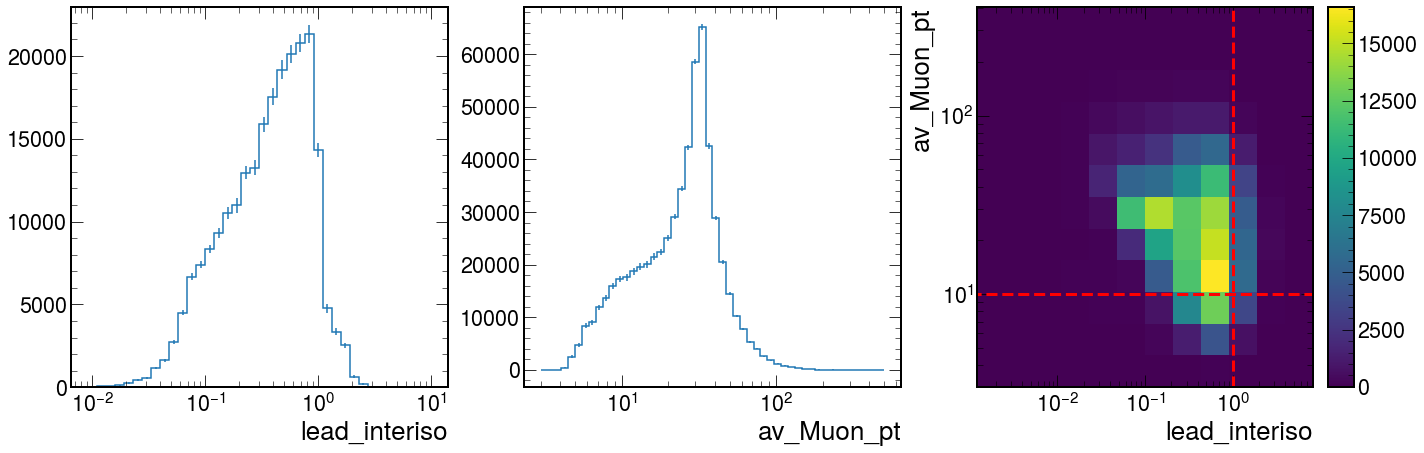

nMuon = 4
yield tot: 26917.255 ± 401.792
yield cut: 372.989 ± 66.986


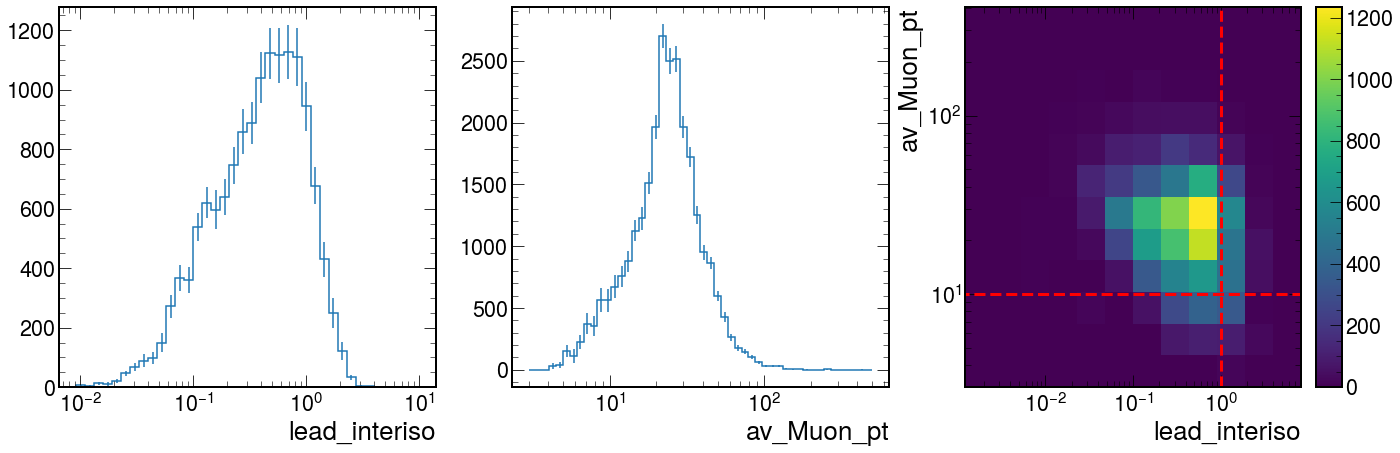

nMuon = 5
yield tot: 860.960 ± 63.714
yield cut: 9.894 ± 3.029


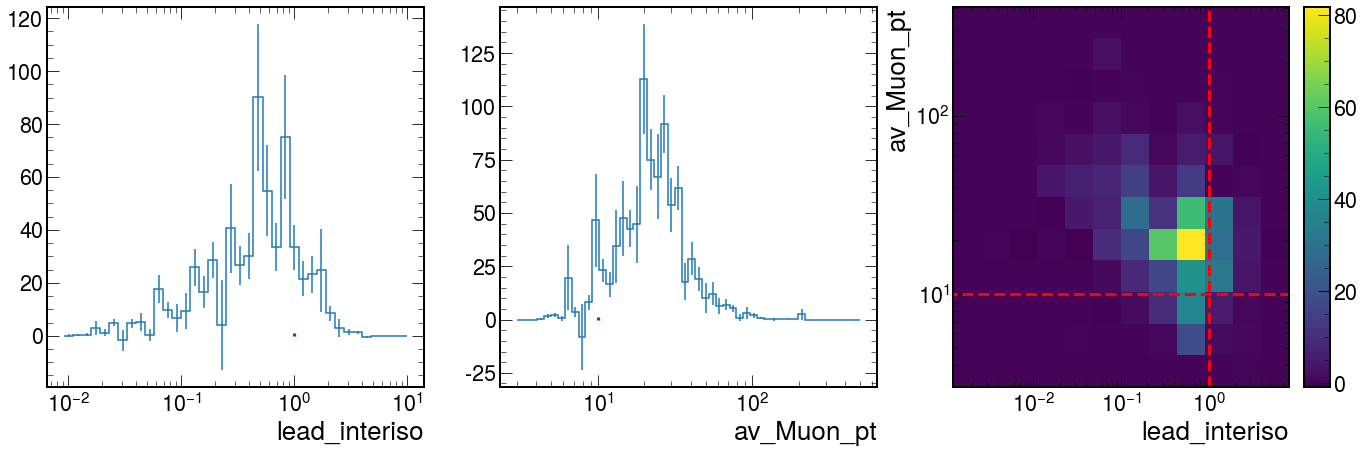

nMuon = 6
yield tot: 20.043 ± 7.468
yield cut: 0.435 ± 0.913


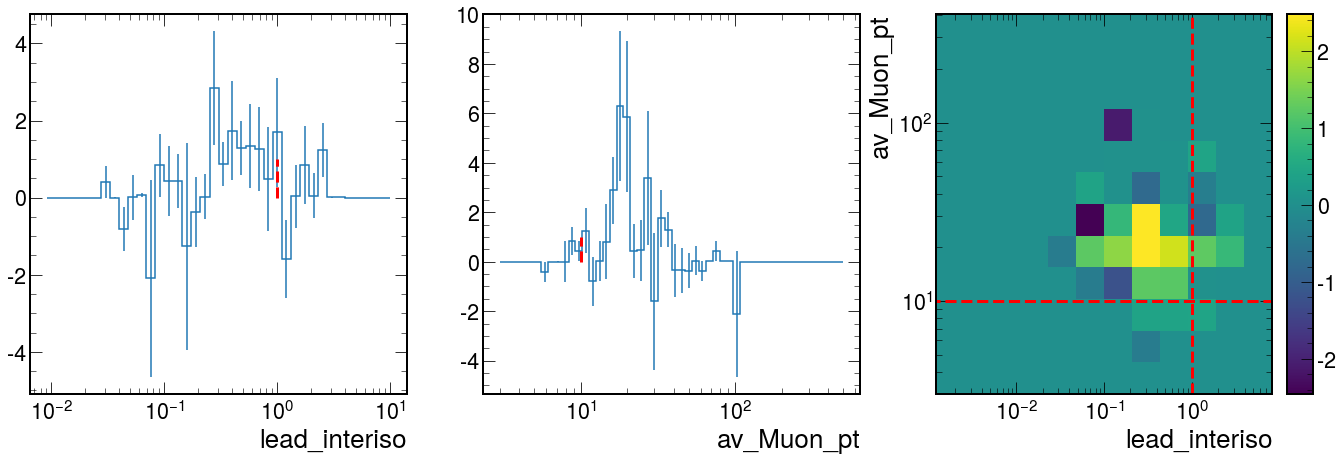

nMuon = 7
yield tot: 0.457 ± 0.707
yield cut: 0.002 ± 0.002


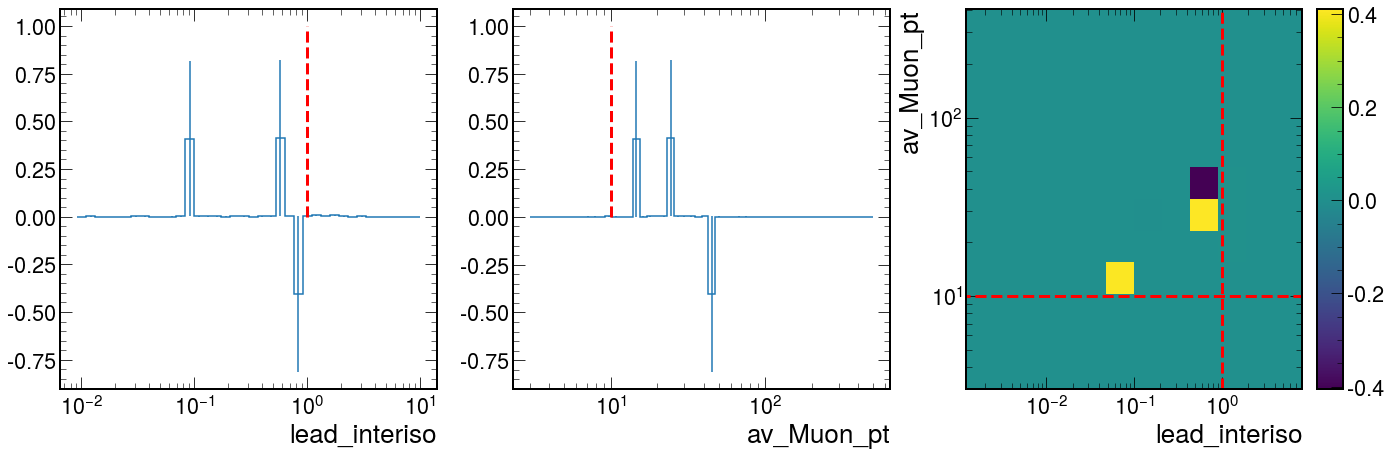

nMuon = 8
yield tot: 0.001 ± 0.001
yield cut: 0.000 ± 0.000


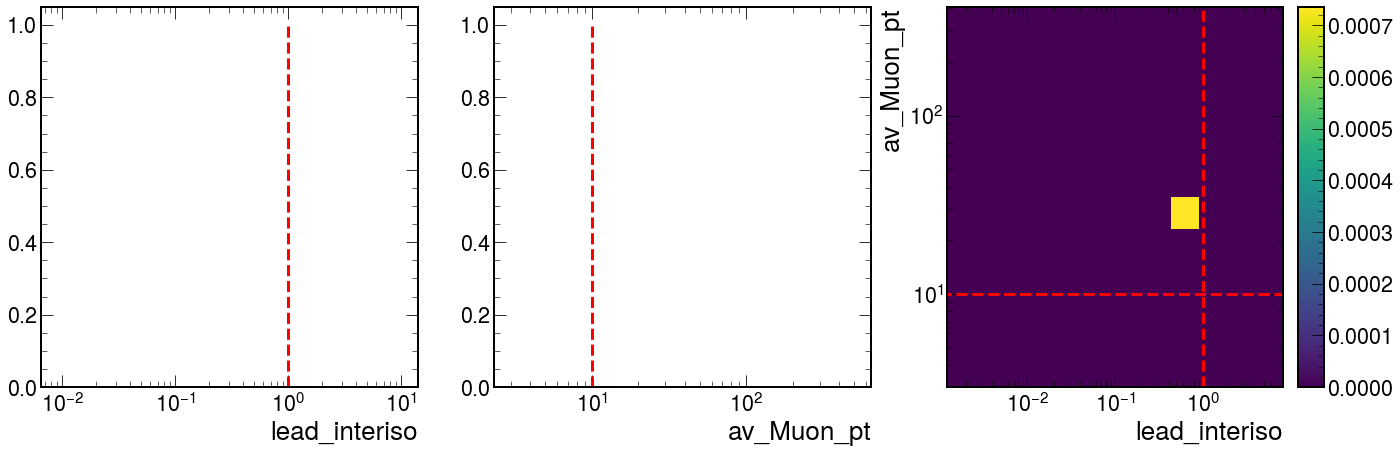

nMuon = 9
yield tot: 0.000 ± 0.000
yield cut: 0.000 ± 0.000


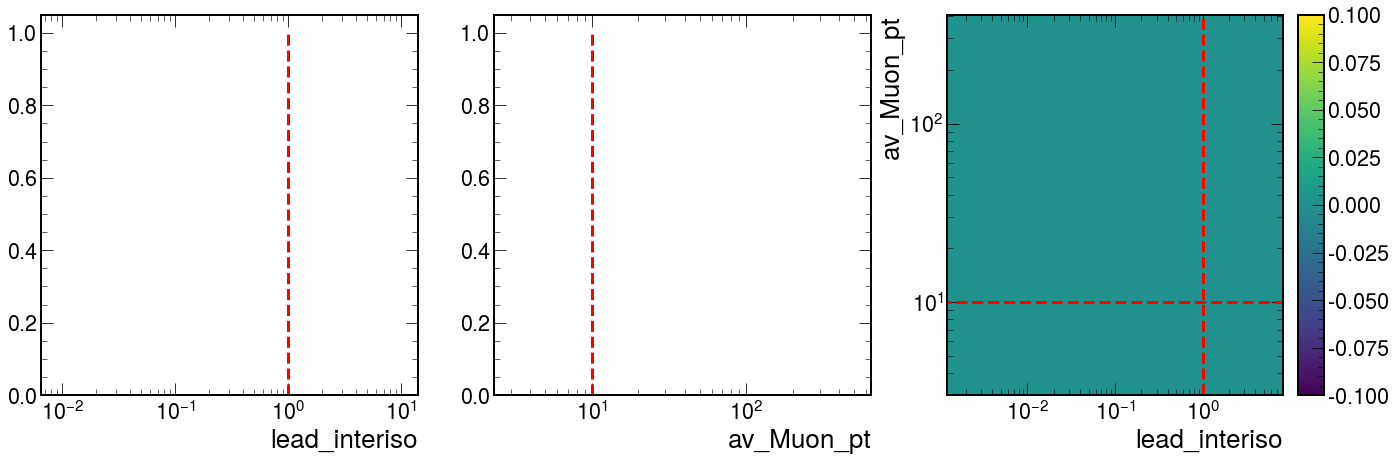

In [74]:
for n in range(3, 10):
    print('nMuon =', n)
    vals_tot = h_tot[::sum, ::sum, ::sum, n*1j]
    vals_cut = h_tot[1j:10j:sum, 3j:10j:sum, ::sum, n*1j]
    print(f"yield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
    print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
    fig, ax = plt.subplots(ncols=3, figsize=(23,7))
    hep.histplot(h_tot[1e-2j:10j, ::sum, ::sum, n*1j], ax=ax[0])
    ax[0].plot([1, 1], plt.gca().get_ylim(), c='r', lw=3, ls='--')
    ax[0].set_xscale('log')
    hep.histplot(h_tot[::sum, :, ::sum, n*1j], ax=ax[1])
    ax[1].plot([10, 10], plt.gca().get_ylim(), c='r', lw=3, ls='--')
    ax[1].set_xscale('log')
    hep.hist2dplot(
        h_tot[1::4j, ::4j, ::sum, n*1j],
        ax=ax[2]
    )
    ax[2].plot([1e-3, 10], [10, 10], c='r', lw=3, ls='--')
    ax[2].plot([1, 1], [3, 500], c='r', lw=3, ls='--')
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    plt.show()

### nMuon distribution

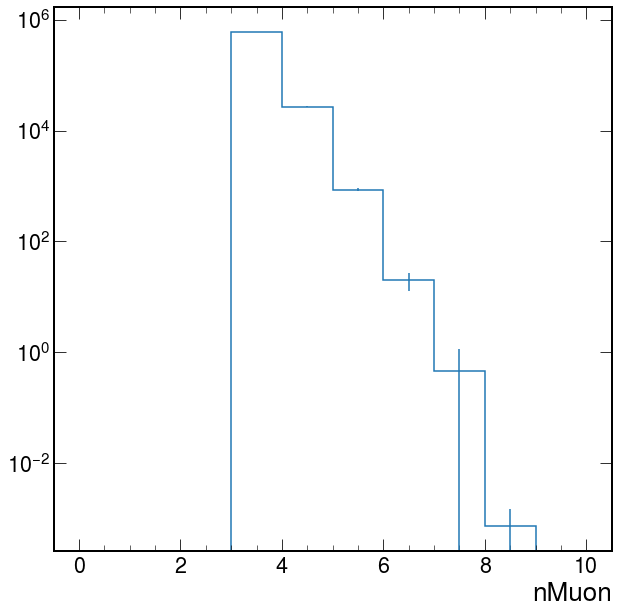

In [75]:
hep.histplot(h_tot[::sum, ::sum, ::sum, :])
plt.yscale('log')
plt.show()

In [19]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from jacobi import propagate

In [11]:
def muon_func(x, a, b, c):
    return a*np.exp(b*x)+c

In [12]:
def muon_func(x, a, b, c, d):
    return a*b**(x**c)+d

In [13]:
h0 = plots['QCD_Pt_MuEnriched_2018']['lead_interiso_vs_av_muon_pt'][::sum, ::sum, ::sum, :]
data_x = h0.axes[0].edges[3:7]
data_y = h0.values()[3:7]
data_yerr = np.sqrt(h0.variances())[3:7]
least_squares = LeastSquares(data_x, data_y, data_yerr, muon_func)
m = Minuit(least_squares, a=1e5, b=0.5, c=1, d=0)
m.fixto("d", 0)
m.migrad(ncall=10000)
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.009 (χ²/ndof = 5.0)      │              Nfcn = 591              │
│ EDM = 0.000116 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  2.33e3   │  0.13e3   │            │            │         │         │       │
│ 1 │ b    │   0.807   │   0.011   │            │            │         │         │       │
│ 2 │ c    │   2.14    │   0.04    │            │            │         │         │       │
│ 3 │ d    │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────┐
│   │        a        b        c        d │
├───┼─────────────────────────────────────┤
│ a │ 1.79e+04 -1.51816  -4.9175        0 │
│ b │ -1.51816  0.00013  0.42e-3        0 │
│ c │  -4.9175  0.42e-3  0.00137   0.0000 │
│ d │        0        0   0.0000        0 │
└───┴─────────────────────────────────────┘

In [67]:
x = np.arange(3,10)
y, ycov = propagate(lambda p: muon_func(x, *p), m.values, m.covariance)
yerr_prop = np.diag(ycov) ** 0.5
x_hatch = np.vstack(
    (np.arange(3,10), np.arange(4,11))
).reshape((-1,), order="F")
y_hatch = np.vstack(
    (y, y)
).reshape((-1,), order="F")
y_hatch_unc = np.vstack(
    (yerr_prop, yerr_prop)
).reshape((-1,), order="F")

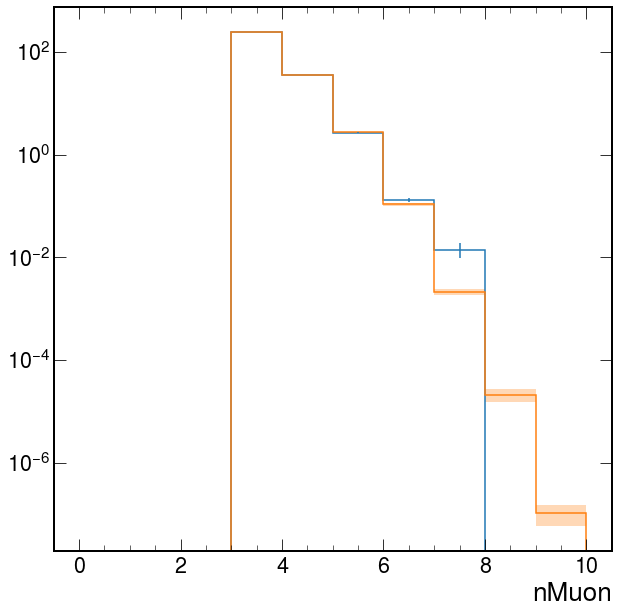

In [79]:
hep.histplot(h0)
#plt.plot(data_x, muon_func(data_x, *(m.values)))
hep.histplot(y, bins=np.arange(3,11))
#plt.plot(x, y, lw=3, label="fit")
plt.fill_between(
    x=x_hatch,
    y1=y_hatch - y_hatch_unc,
    y2=y_hatch + y_hatch_unc,
    label="Stat. Unc.",
    step="pre",
    facecolor="C1", 
    alpha=0.3,
    #facecolor="none",
    #edgecolor=(0, 0, 0, 0.5),
    linewidth=0,
    #hatch="///",
)
#plt.fill_between(x, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)
plt.yscale('log')
plt.show()

In [16]:
np.arange(3,10)

array([3, 4, 5, 6, 7, 8, 9])

VVV_2018
data_x=array([3., 4., 5., 6.])
data_y=array([5.66802382e+01, 6.66056990e+00, 2.35559694e-01, 2.66957446e-02])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.555e+04 (χ²/ndof = 55547.8)│              Nfcn = 182              │
│ EDM = 1.59e+05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴───────

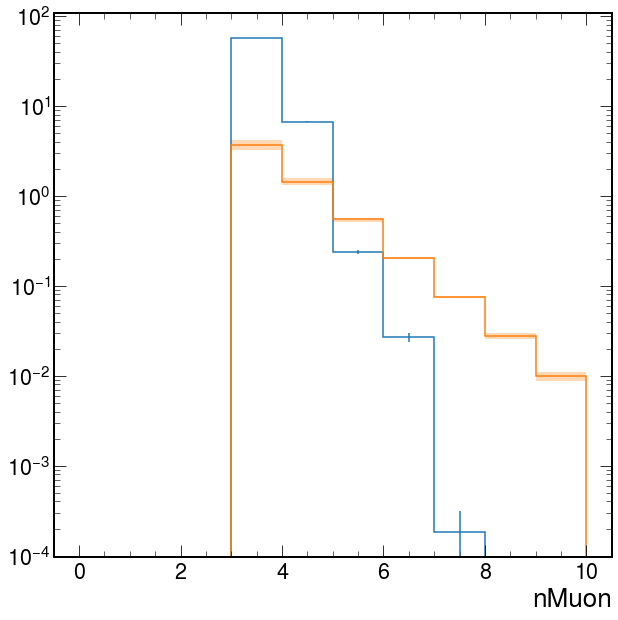

ttZJets_2018
data_x=array([3., 4., 5., 6.])
data_y=array([418.36801532,  77.88028668,   7.37923045,   0.44692634])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.47 (χ²/ndof = 20.5)     │              Nfcn = 523              │
│ EDM = 2.78e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴─────────────

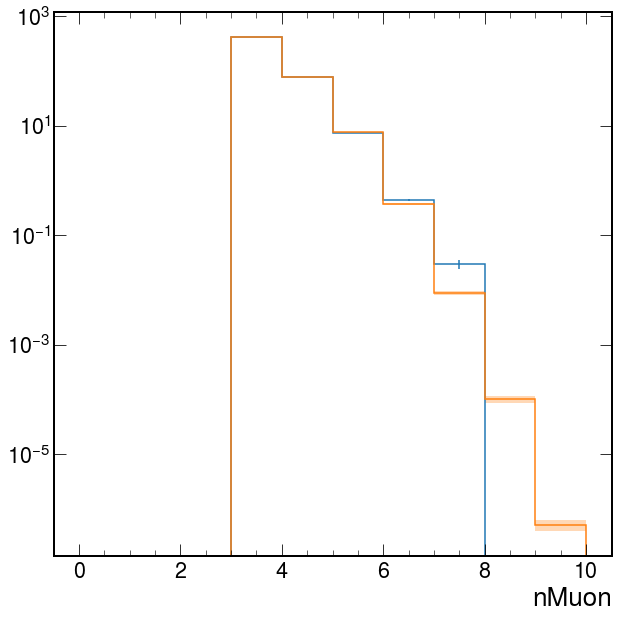

WJets_all_2018
data_x=array([3., 4., 5., 6.])
data_y=array([2.50182004e+03, 1.36476375e+01, 9.34334070e-01, 1.68163024e-02])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 954.8 (χ²/ndof = 954.8)    │              Nfcn = 182              │
│ EDM = 994 (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴───

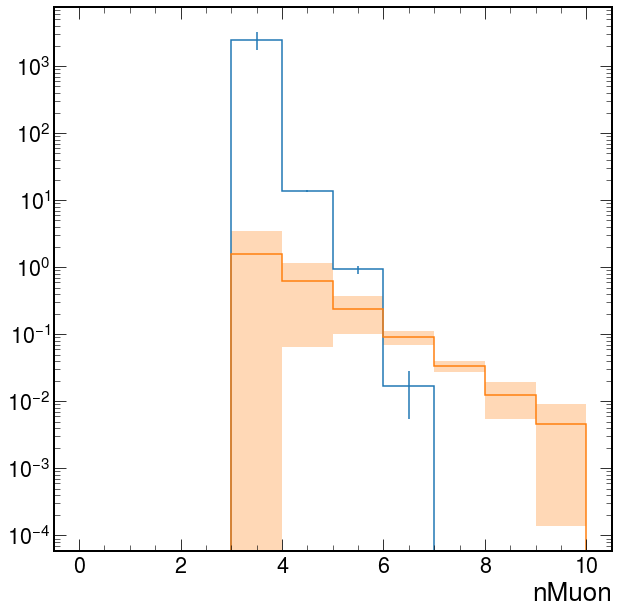

ST_2018
data_x=array([3., 4., 5., 6.])
data_y=array([3.01652830e+03, 1.88241124e+02, 6.04402248e+00, 9.93513890e-02])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.000532 (χ²/ndof = 0.0)   │              Nfcn = 296              │
│ EDM = 8.68e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────

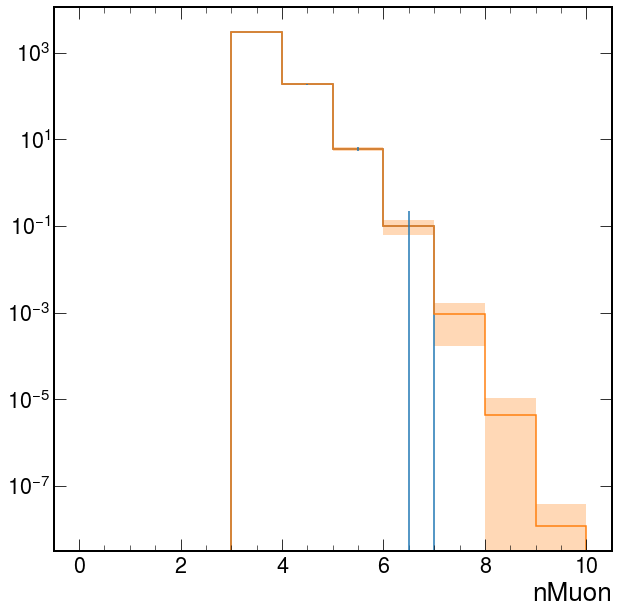

VV_2018
data_x=array([3., 4., 5., 6.])
data_y=array([3.88029999e+03, 1.46004235e+03, 1.62457485e+01, 4.65863413e-01])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 203.2 (χ²/ndof = 203.2)    │             Nfcn = 1178              │
│ EDM = 2.14 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────

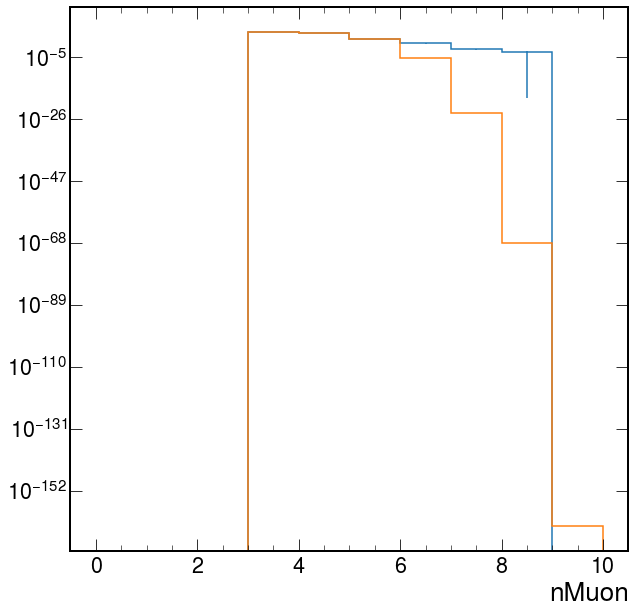

TTJets_2018
data_x=array([3., 4., 5., 6.])
data_y=array([1.39048468e+05, 1.21905630e+04, 5.65682639e+02, 1.63374047e+01])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1821 (χ²/ndof = 0.2)     │              Nfcn = 270              │
│ EDM = 2.9e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────

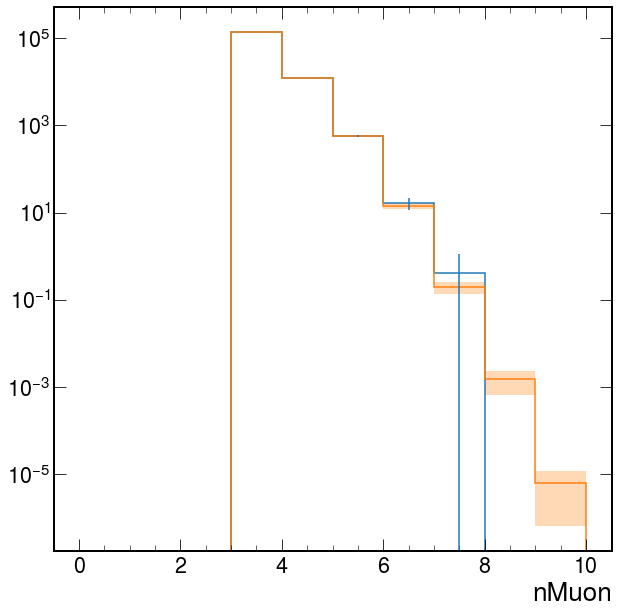

DY_NLO_all_2018
data_x=array([3., 4., 5., 6.])
data_y=array([4.50188458e+05, 1.29447996e+04, 2.61802010e+02, 2.51915630e+00])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.0509 (χ²/ndof = 0.1)     │             Nfcn = 1753              │
│ EDM = 0.000192 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──

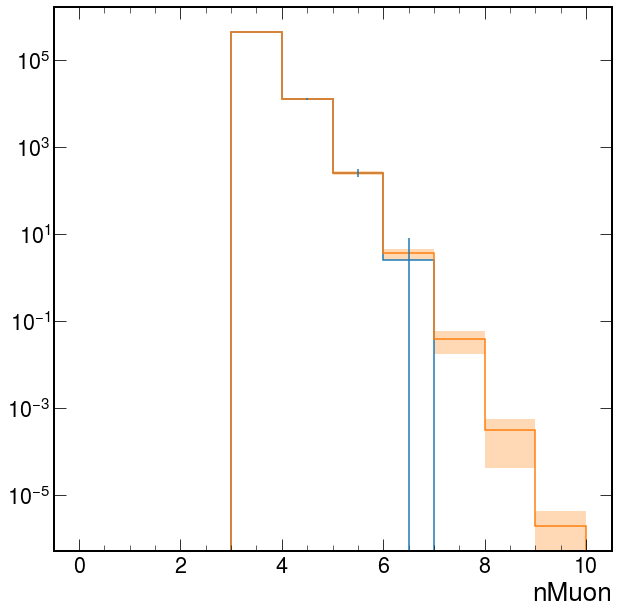

QCD_Pt_MuEnriched_2018
data_x=array([3., 4., 5., 6.])
data_y=array([2.43210694e+02, 3.54202586e+01, 2.63636436e+00, 1.30825121e-01])
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.009 (χ²/ndof = 5.0)      │              Nfcn = 591              │
│ EDM = 0.000116 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────

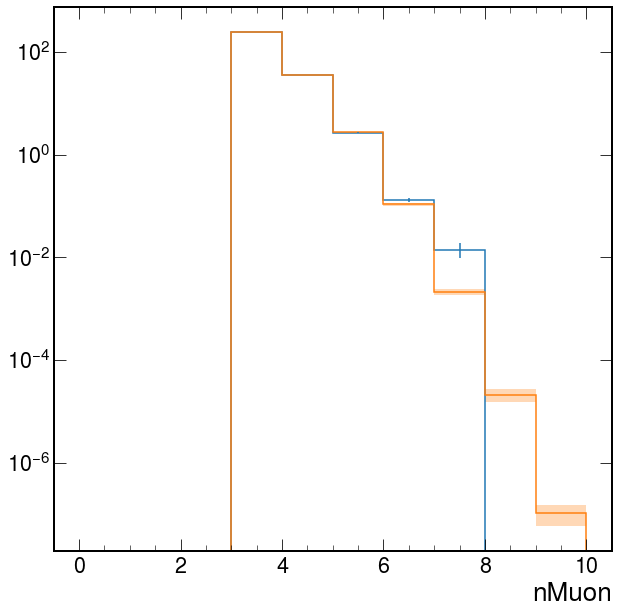

In [82]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]

for p in processes:
    print(p)
    h0 = plots[p]['lead_interiso_vs_av_muon_pt'][::sum, ::sum, ::sum, :]
    data_x = h0.axes[0].edges[3:7]
    data_y = h0.values()[3:7]
    print(f"{data_x=}")
    print(f"{data_y=}")
    data_yerr = np.sqrt(h0.variances())[3:7]
    least_squares = LeastSquares(data_x, data_y, data_yerr, muon_func)
    m = Minuit(least_squares, a=1e5, b=0.5, c=1, d=0)
    m.fixto("d", 0)
    m.migrad(ncall=10000)
    m.hesse()
    print(m)
    x = np.arange(3,10)
    y, ycov = propagate(lambda p: muon_func(x, *p), m.values, m.covariance)
    yerr_prop = np.diag(ycov) ** 0.5
    x_hatch = np.vstack(
        (np.arange(3,10), np.arange(4,11))
    ).reshape((-1,), order="F")
    y_hatch = np.vstack(
        (y, y)
    ).reshape((-1,), order="F")
    y_hatch_unc = np.vstack(
        (yerr_prop, yerr_prop)
    ).reshape((-1,), order="F")
    vals_tot = plots[p]['lead_interiso_vs_av_muon_pt'][::sum, ::sum, ::sum, 6j::sum]
    vals_cut = plots[p]['lead_interiso_vs_av_muon_pt'][1j:10j:sum, 3j:10j:sum, ::sum, 6j::sum]
    print(f"yield tot: {vals_tot.value:.3f} ± {np.sqrt(vals_tot.variance):.3f}")
    print(f"yield cut: {vals_cut.value:.3f} ± {np.sqrt(vals_cut.variance):.3f}")
    hep.histplot(plots[p]['lead_interiso_vs_av_muon_pt'][::sum, ::sum, ::sum, :])
    #hep.histplot(plots[p]['lead_interiso_vs_av_muon_pt'][1j:10j:sum, 3j:10j:sum, ::sum, :])
    hep.histplot(y, bins=np.arange(3,11))
    plt.fill_between(
        x=x_hatch,
        y1=y_hatch - y_hatch_unc,
        y2=y_hatch + y_hatch_unc,
        label="Stat. Unc.",
        step="pre",
        facecolor="C1", 
        alpha=0.3,
        linewidth=0,
    )
    plt.yscale('log')
    plt.show()

In [27]:
print(*(m.values))

2131.5334042696313 1.1576795499589272 -1.3093930666116385 2.2089998224250524 0.037529279039633205


## Significance scans

In [14]:
def enumerated_product(*args):
    for e in zip(itertools.product(*(range(len(x)) for x in args)), itertools.product(*args)):
        yield e

In [25]:
def asimov_sig(S, B):
    B[np.isclose(B, 0)] = 1e-8
    B[B < 0] = 1e-8
    return np.sqrt(2*((S + B)*np.log(1 + S/B) - S))

def S_12(S, B):
    B[B < 0] = 0
    return 2*(np.sqrt(S + B) - np.sqrt(B))

def S_over_SB(S, B):
    B[B < 0] = 0
    return S/np.sqrt(S + B)

def S_over_BdB(S, B, deltaB2):
    B[B < 0] = 0
    return S/np.sqrt(B + deltaB2)

def punzi(S_eff, B, a=2, b=2):
    B[B < 0] = 0
    return S_eff/(b**2 + 2*a*np.sqrt(B) + b*np.sqrt(b**2 + 4*a*np.sqrt(B) + 4*B))
    
def punzi_imp(S_eff, B, a=2, b=2):
    B[B < 0] = 0
    return S_eff/(a**2/4 + 18*b**2/13 + 2*a*np.sqrt(B) + b*np.sqrt(b**2 + 4*a*np.sqrt(B) + 4*B))

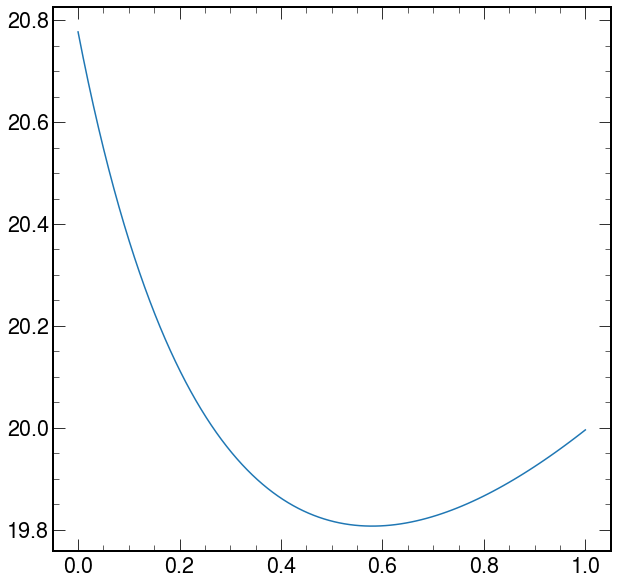

In [46]:
B_space = np.linspace(0, 1, 100)
S_space = np.linspace(310, 400, 100)
plt.plot(B_space, punzi_imp(S_space, B_space*1.1+0.3))

In [16]:
def muon_scaling(x, A, B):
    return A*np.exp(-B*x)

In [156]:
[p.shape for p in plots['QCD_Pt_MuEnriched_2018']['lead_interiso_vs_av_muon_pt'][0.5j:2j,3j:20j,::sum,::sum].axes.edges]

[(9, 1), (1, 19)]

In [17]:
np.set_printoptions(precision=4)

In [47]:
m.valid & m.accurate

True

In [51]:
m.limits(B, 2, None)

TypeError: 'LimitView' object is not callable

In [52]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'WJets_all_2018',
    'ST_2018',
    'VV_2018',
    'TTJets_2018',
    'DY_NLO_all_2018',
    'QCD_Pt_MuEnriched_2018',
]

signals = [
    'SUEP-m125-darkPho_2018',
    'SUEP-m400-darkPho_2018',
    'SUEP_mMed-125_mDark-8_temp-32_decay-darkPho_2018',
    'SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018',
]

#nMuon_cut = np.array([5, 6, 7])
nMuon_cut = np.array([6])
lead_interiso_cut = np.linspace(0.5, 2, 21)
av_muon_pt_cut = np.linspace(3.4, 20, 21)

# Don't scan nMuon for now. nMuon≥6 is clearly superior.
# for nMu in nMuon_cut:
nMu = nMuon_cut[0]
# print(f"Looking at nMuon >= {nMu}")
B = np.zeros((len(lead_interiso_cut), len(av_muon_pt_cut)))
deltaB2 = np.zeros((len(lead_interiso_cut), len(av_muon_pt_cut)))
S = {}
S_tot = {}
for signal in signals:
    S_tot[signal] = plots[signal]['lead_interiso_vs_av_muon_pt'].sum().value
    S[signal] = np.zeros((len(lead_interiso_cut), len(av_muon_pt_cut)))
for (l_iso_i, av_pt_i), (l_iso, av_pt) in enumerated_product(lead_interiso_cut, av_muon_pt_cut):
    cut = (
        slice((l_iso*1j), None, sum), 
        slice(None, (av_pt*1j), sum), 
        slice(None, None, sum), 
        slice(None),
    )
    adj_proc = []
    adj_values = []
    for p in processes:
        h_temp = plots[p]['lead_interiso_vs_av_muon_pt'][cut].copy()
        # You can inject here whatever extrapolation you want if h_temp[(nMu*1j)::sum] gives ≤0 
        if not (h_temp[6j::sum].value > 0) and (h_temp[5j].value > 0):
            if h_temp[6j::sum].value < 0:
                print(l_iso, av_pt, p, h_temp[6j::sum].value)
            adj_proc.append(p.replace('_2018',''))
            adj_values.append(h_temp[5j].value)
        if h_temp[(nMu*1j)::sum].value >= 0:
            B[l_iso_i, av_pt_i] += h_temp[(nMu*1j)::sum].value
            deltaB2[l_iso_i, av_pt_i] += h_temp[(nMu*1j)::sum].variance
    if len(adj_proc):
        adj_values = np.array(adj_values)
        vals_to_keep = []
        procs_to_keep = []
        extrapolations = []
        for p, v in zip([adj_proc[i] for i in np.argsort(adj_values)[::-1]], np.sort(adj_values)[::-1]):
            if v >= 0.1*max(adj_values):
                vals_to_keep.append(v)
                procs_to_keep.append(p)
        for p, v in zip(procs_to_keep, vals_to_keep):
            h_temp = plots[p + '_2018']['lead_interiso_vs_av_muon_pt'][cut].copy()
            data_x = np.array([3, 4, 5])
            data_y = h_temp[3j:6j].values()
            data_yerr = np.sqrt(h_temp[3j:6j].variances())
            least_squares = LeastSquares(data_x, data_y, data_yerr, muon_scaling)
            m = Minuit(least_squares, A=1e5, B=1)
            m.limits = [(0, None), (1, None)]
            m.migrad()
            extrapolations.append(muon_scaling(6, *m.values))
            if not m.valid or not m.accurate:
                print("Warning: fit not accurate or valid!!!")
                continue
            if muon_scaling(6, *m.values) <= 0.25 * h_temp[5j].value:
                B[l_iso_i, av_pt_i] += muon_scaling(6, *m.values)
            else:
                print("Warning!!! Extrapolation is off!!!")
        print(f"{procs_to_keep} with {np.array(vals_to_keep)} for ({l_iso:.3f}, {av_pt:.3f}) cuts")
        print(f"\tm.values: {np.array([m.values['A'], m.values['B']])}, extrapolation: {np.array(extrapolations)}")
    for signal in signals:
        h_temp = plots[signal]['lead_interiso_vs_av_muon_pt'][cut].copy()
        S[signal][l_iso_i, av_pt_i] = h_temp[(nMu*1j)::sum].value

['QCD_Pt_MuEnriched', 'VV'] with [0.0019 0.0015] for (0.500, 4.230) cuts
	m.values: [29.8835  2.2158], extrapolation: [6.7642e-05 5.0286e-05]
['TTJets'] with [1.2253] for (0.500, 5.060) cuts
	m.values: [9.6169e+04 2.5168e+00], extrapolation: [0.0266]
['TTJets'] with [2.859] for (0.500, 5.890) cuts
	m.values: [3.7282e+04 1.8913e+00], extrapolation: [0.4396]
['TTJets'] with [3.2675] for (0.500, 6.720) cuts
	m.values: [1.2012e+05 2.0625e+00], extrapolation: [0.5073]
['DY_NLO_all', 'TTJets'] with [15.0832  8.1687] for (0.500, 7.550) cuts
	m.values: [4.4421e+05 2.1392e+00], extrapolation: [0.3412 1.1843]
['DY_NLO_all', 'TTJets'] with [15.0832 11.8446] for (0.500, 8.380) cuts
	m.values: [7.7669e+05 2.1748e+00], extrapolation: [0.3229 1.6721]
['DY_NLO_all', 'TTJets'] with [15.0832 11.8446] for (0.500, 9.210) cuts
	m.values: [7.7669e+05 2.1748e+00], extrapolation: [0.3229 1.6721]
['DY_NLO_all'] with [15.0832] for (0.500, 10.040) cuts
	m.values: [3.9632e+08 3.3947e+00], extrapolation: [0.5653]


['TTJets'] with [11.4362] for (0.725, 9.210) cuts
	m.values: [3.9850e+05 2.0747e+00], extrapolation: [1.5639]
['WJets_all'] with [0.0564] for (0.725, 10.040) cuts
	m.values: [224.7188   1.6173], extrapolation: [0.0137]
['DY_NLO_all'] with [12.5641] for (0.725, 10.870) cuts
	m.values: [2.2657e+08 3.2953e+00], extrapolation: [0.5866]
['DY_NLO_all'] with [12.5641] for (0.725, 11.700) cuts
	m.values: [2.2680e+08 3.2274e+00], extrapolation: [0.8827]
['DY_NLO_all'] with [12.5641] for (0.725, 12.530) cuts
	m.values: [2.2680e+08 3.2274e+00], extrapolation: [0.8827]
['DY_NLO_all'] with [12.5641] for (0.725, 13.360) cuts
	m.values: [3.4914e+08 3.3117e+00], extrapolation: [0.8196]
['DY_NLO_all'] with [12.5641] for (0.725, 14.190) cuts
	m.values: [5.3593e+08 3.3984e+00], extrapolation: [0.7475]
['DY_NLO_all'] with [12.5641] for (0.725, 15.020) cuts
	m.values: [5.3593e+08 3.3984e+00], extrapolation: [0.7475]
0.725 15.850000000000001 ST_2018 -0.04841298347930524
['DY_NLO_all'] with [30.1665] for (0.

['DY_NLO_all'] with [15.0832] for (0.950, 15.850) cuts
	m.values: [3.3636e+07 2.7967e+00], extrapolation: [1.7351]
['DY_NLO_all'] with [15.0832] for (0.950, 16.680) cuts
	m.values: [3.3636e+07 2.7967e+00], extrapolation: [1.7351]
['DY_NLO_all'] with [15.0832] for (0.950, 17.510) cuts
	m.values: [4.5231e+07 2.8571e+00], extrapolation: [1.6241]
['DY_NLO_all'] with [15.0832] for (0.950, 18.340) cuts
	m.values: [4.5231e+07 2.8571e+00], extrapolation: [1.6241]
['DY_NLO_all'] with [15.0832] for (0.950, 19.170) cuts
	m.values: [6.0403e+07 2.9302e+00], extrapolation: [1.3986]
['DY_NLO_all'] with [15.0832] for (0.950, 20.000) cuts
	m.values: [6.0403e+07 2.9302e+00], extrapolation: [1.3986]
['QCD_Pt_MuEnriched'] with [0.0019] for (1.025, 4.230) cuts
	m.values: [290.7464   2.598 ], extrapolation: [4.9392e-05]
['TTJets'] with [1.2253] for (1.025, 5.060) cuts
	m.values: [4.5846e+04 2.5647e+00], extrapolation: [0.0095]
['TTJets'] with [2.0422] for (1.025, 5.890) cuts
	m.values: [1.0153e+04 1.7408e+0

1.1749999999999998 16.68 TTJets_2018 -0.4084351181574274
Warning!!! Extrapolation is off!!!
['TTJets', 'DY_NLO_all'] with [20.0133 15.0832] for (1.175, 16.680) cuts
	m.values: [2.8132e+06 2.3088e+00], extrapolation: [5.6361 2.71  ]
Warning!!! Extrapolation is off!!!
['TTJets', 'DY_NLO_all'] with [27.7736 12.5641] for (1.175, 17.510) cuts
	m.values: [4.7682e+06 2.4335e+00], extrapolation: [7.1665 2.1743]
Warning!!! Extrapolation is off!!!
['TTJets', 'DY_NLO_all'] with [27.7736 12.5641] for (1.175, 18.340) cuts
	m.values: [4.7682e+06 2.4335e+00], extrapolation: [7.1665 2.1743]
['DY_NLO_all'] with [12.5641] for (1.175, 19.170) cuts
	m.values: [6.2086e+06 2.4949e+00], extrapolation: [1.9579]
['DY_NLO_all'] with [12.5641] for (1.175, 20.000) cuts
	m.values: [6.2086e+06 2.4949e+00], extrapolation: [1.9579]
['QCD_Pt_MuEnriched'] with [0.0019] for (1.250, 4.230) cuts
	m.values: [418.7583   2.8317], extrapolation: [1.7504e-05]
['TTJets'] with [1.2253] for (1.250, 5.060) cuts
	m.values: [5.7097e

Warning!!! Extrapolation is off!!!
['TTJets'] with [13.0699] for (1.400, 15.020) cuts
	m.values: [1.3055e+05 1.7617e+00], extrapolation: [3.352]
Warning!!! Extrapolation is off!!!
['DY_NLO_all', 'TTJets'] with [17.6024 15.5205] for (1.400, 15.850) cuts
	m.values: [1.7805e+05 1.7832e+00], extrapolation: [1.8724 4.0172]
Warning!!! Extrapolation is off!!!
['DY_NLO_all', 'TTJets'] with [17.6024 15.5205] for (1.400, 16.680) cuts
	m.values: [1.7805e+05 1.7832e+00], extrapolation: [1.8724 4.0172]
['DY_NLO_all'] with [17.6024] for (1.400, 17.510) cuts
	m.values: [3.1040e+06 2.4147e+00], extrapolation: [1.584]
['DY_NLO_all'] with [17.6024] for (1.400, 18.340) cuts
	m.values: [3.1040e+06 2.4147e+00], extrapolation: [1.584]
['DY_NLO_all'] with [17.6024] for (1.400, 19.170) cuts
	m.values: [4.3024e+06 2.5009e+00], extrapolation: [1.3087]
['DY_NLO_all'] with [17.6024] for (1.400, 20.000) cuts
	m.values: [4.3024e+06 2.5009e+00], extrapolation: [1.3087]
['QCD_Pt_MuEnriched'] with [0.0019] for (1.475,

Warning!!! Extrapolation is off!!!
['TTJets'] with [6.1265] for (1.625, 15.020) cuts
	m.values: [7.0154e+04 1.7821e+00], extrapolation: [1.5932]
Warning!!! Extrapolation is off!!!
['DY_NLO_all', 'TTJets'] with [17.6024  7.3518] for (1.625, 15.850) cuts
	m.values: [9.1478e+04 1.7954e+00], extrapolation: [0.9852 1.9182]
Warning!!! Extrapolation is off!!!
['DY_NLO_all', 'TTJets'] with [17.6024  7.3518] for (1.625, 16.680) cuts
	m.values: [9.1478e+04 1.7954e+00], extrapolation: [0.9852 1.9182]
['DY_NLO_all'] with [17.6024] for (1.625, 17.510) cuts
	m.values: [1.2425e+06 2.3144e+00], extrapolation: [1.1577]
['DY_NLO_all'] with [17.6024] for (1.625, 18.340) cuts
	m.values: [1.2425e+06 2.3144e+00], extrapolation: [1.1577]
['DY_NLO_all'] with [17.6024] for (1.625, 19.170) cuts
	m.values: [1.5140e+06 2.3541e+00], extrapolation: [1.1116]
['DY_NLO_all'] with [17.6024] for (1.625, 20.000) cuts
	m.values: [1.5140e+06 2.3541e+00], extrapolation: [1.1116]
['QCD_Pt_MuEnriched'] with [0.0007] for (1.70

Warning!!! Extrapolation is off!!!
['TTJets'] with [6.1265] for (1.850, 15.020) cuts
	m.values: [7.0154e+04 1.7821e+00], extrapolation: [1.5932]
Warning!!! Extrapolation is off!!!
['DY_NLO_all', 'TTJets'] with [17.6024  7.3518] for (1.850, 15.850) cuts
	m.values: [9.1478e+04 1.7954e+00], extrapolation: [0.9852 1.9182]
Warning!!! Extrapolation is off!!!
['DY_NLO_all', 'TTJets'] with [17.6024  7.3518] for (1.850, 16.680) cuts
	m.values: [9.1478e+04 1.7954e+00], extrapolation: [0.9852 1.9182]
['DY_NLO_all'] with [17.6024] for (1.850, 17.510) cuts
	m.values: [1.2425e+06 2.3144e+00], extrapolation: [1.1577]
['DY_NLO_all'] with [17.6024] for (1.850, 18.340) cuts
	m.values: [1.2425e+06 2.3144e+00], extrapolation: [1.1577]
['DY_NLO_all'] with [17.6024] for (1.850, 19.170) cuts
	m.values: [1.5140e+06 2.3541e+00], extrapolation: [1.1116]
['DY_NLO_all'] with [17.6024] for (1.850, 20.000) cuts
	m.values: [1.5140e+06 2.3541e+00], extrapolation: [1.1116]
['QCD_Pt_MuEnriched'] with [0.0007] for (1.92

In [39]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.5977 (χ²/ndof = 0.6)     │              Nfcn = 148              │
│ EDM = 1.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  0.05e6   │  0.08e6   │            │            │         │         │       │
│ 1 │ B    │    1.9    │    0.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────┐
│   │          A          B │
├───┼───────────────────────┤
│ A │   7.16e+09 34.61801e3 │
│ B │ 34.61801e3      0.178 │
└───┴───────────────────────┘

In [45]:
m.accurate

0.597657175648531

Results for SUEP-m125-darkPho_2018


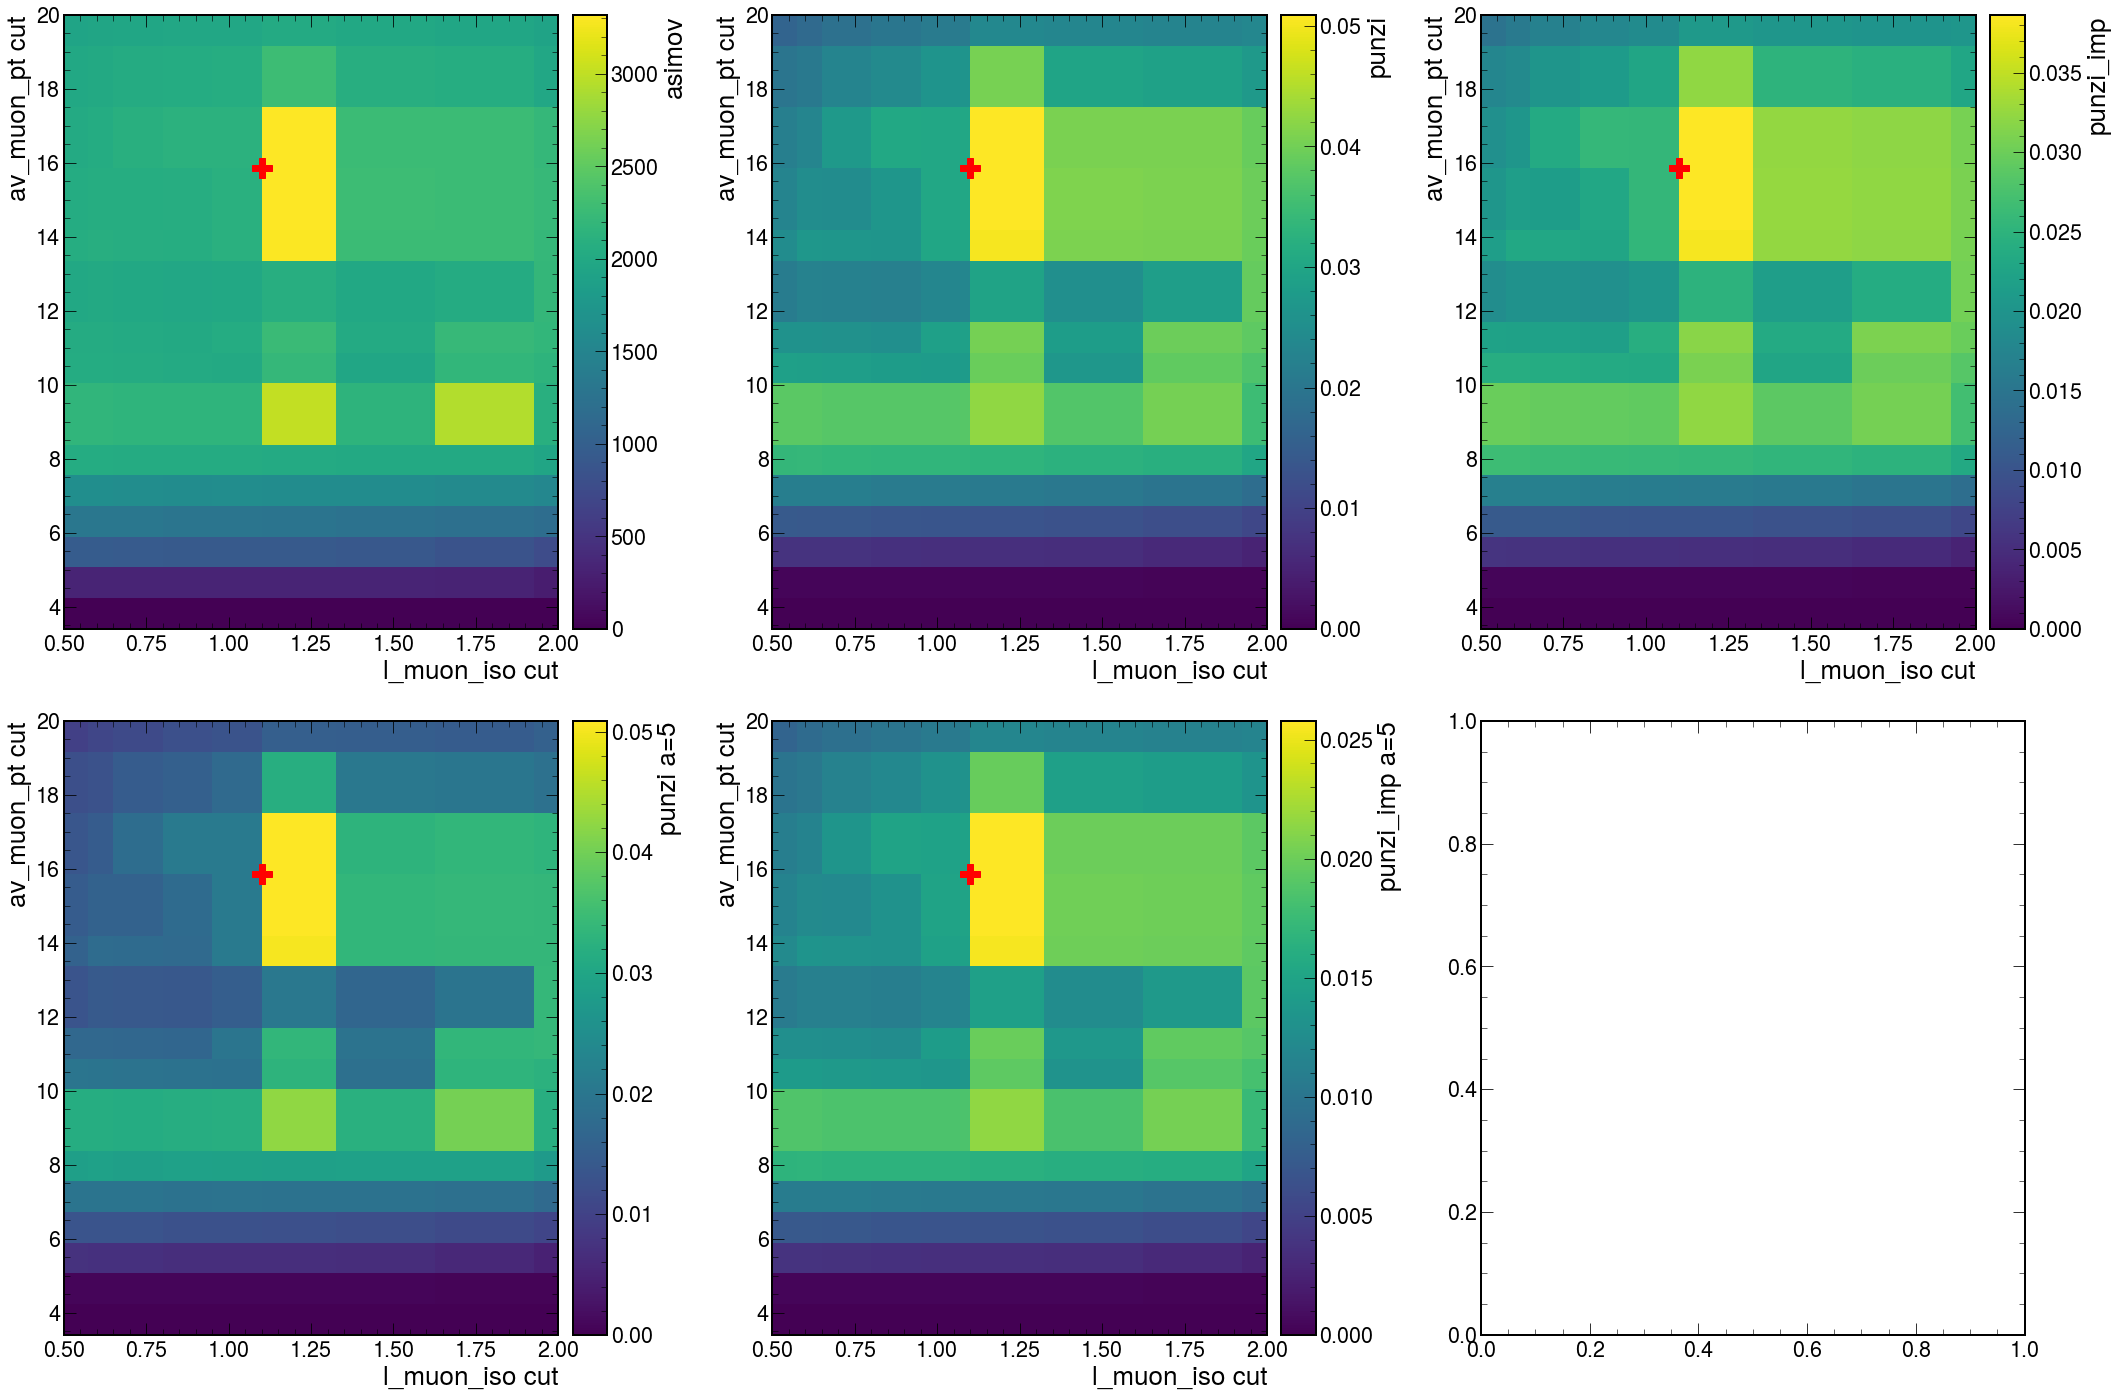

Results for SUEP-m400-darkPho_2018


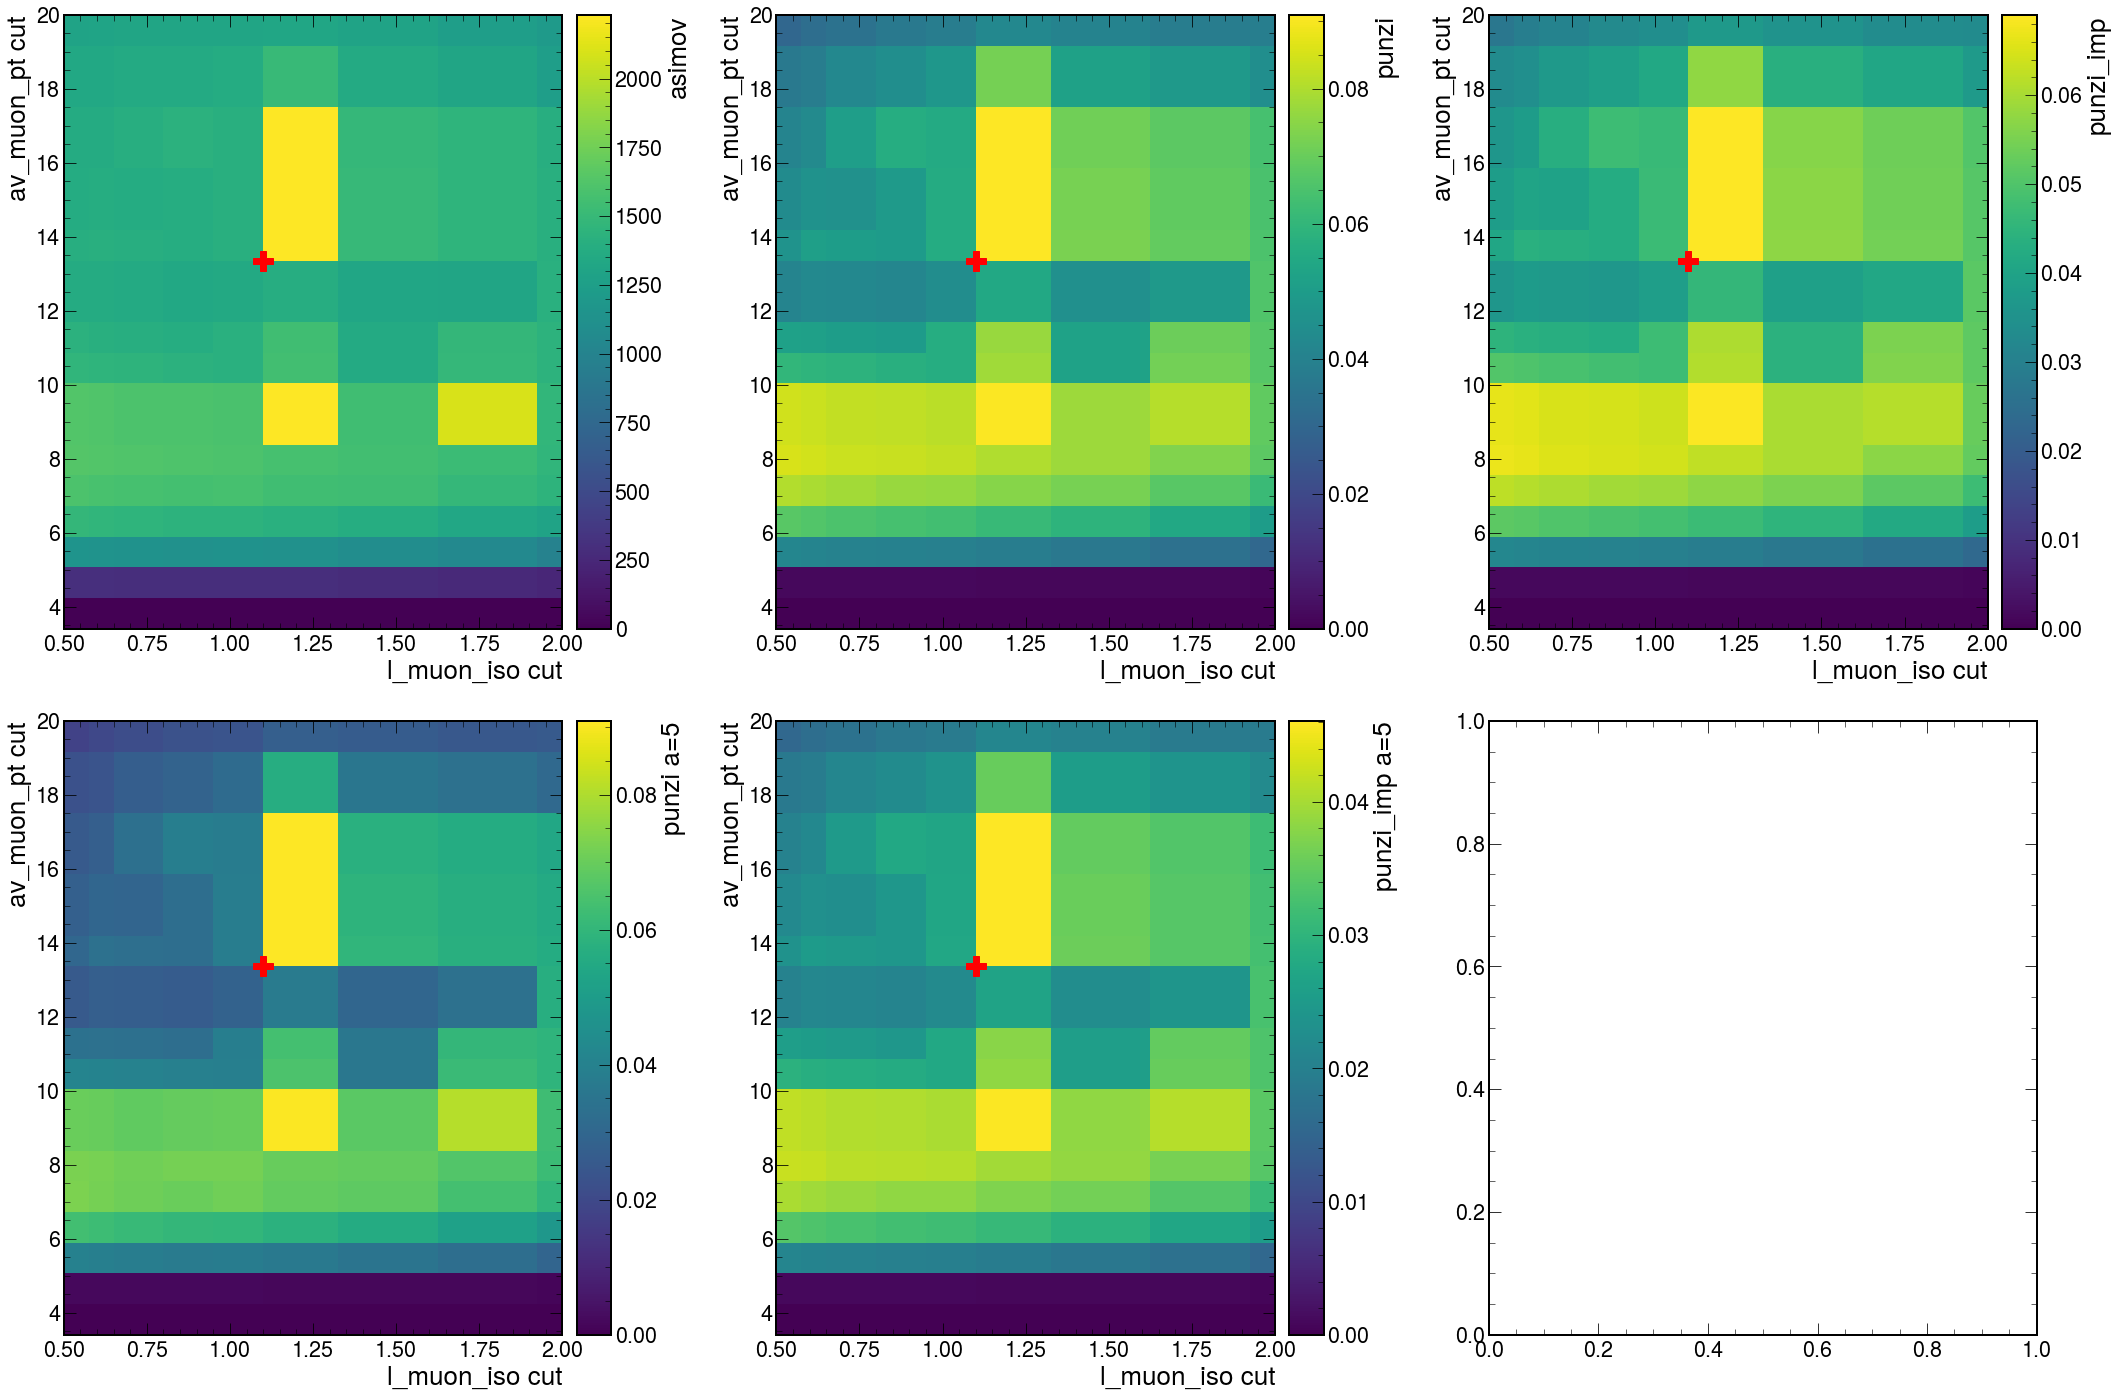

Results for SUEP_mMed-125_mDark-8_temp-32_decay-darkPho_2018


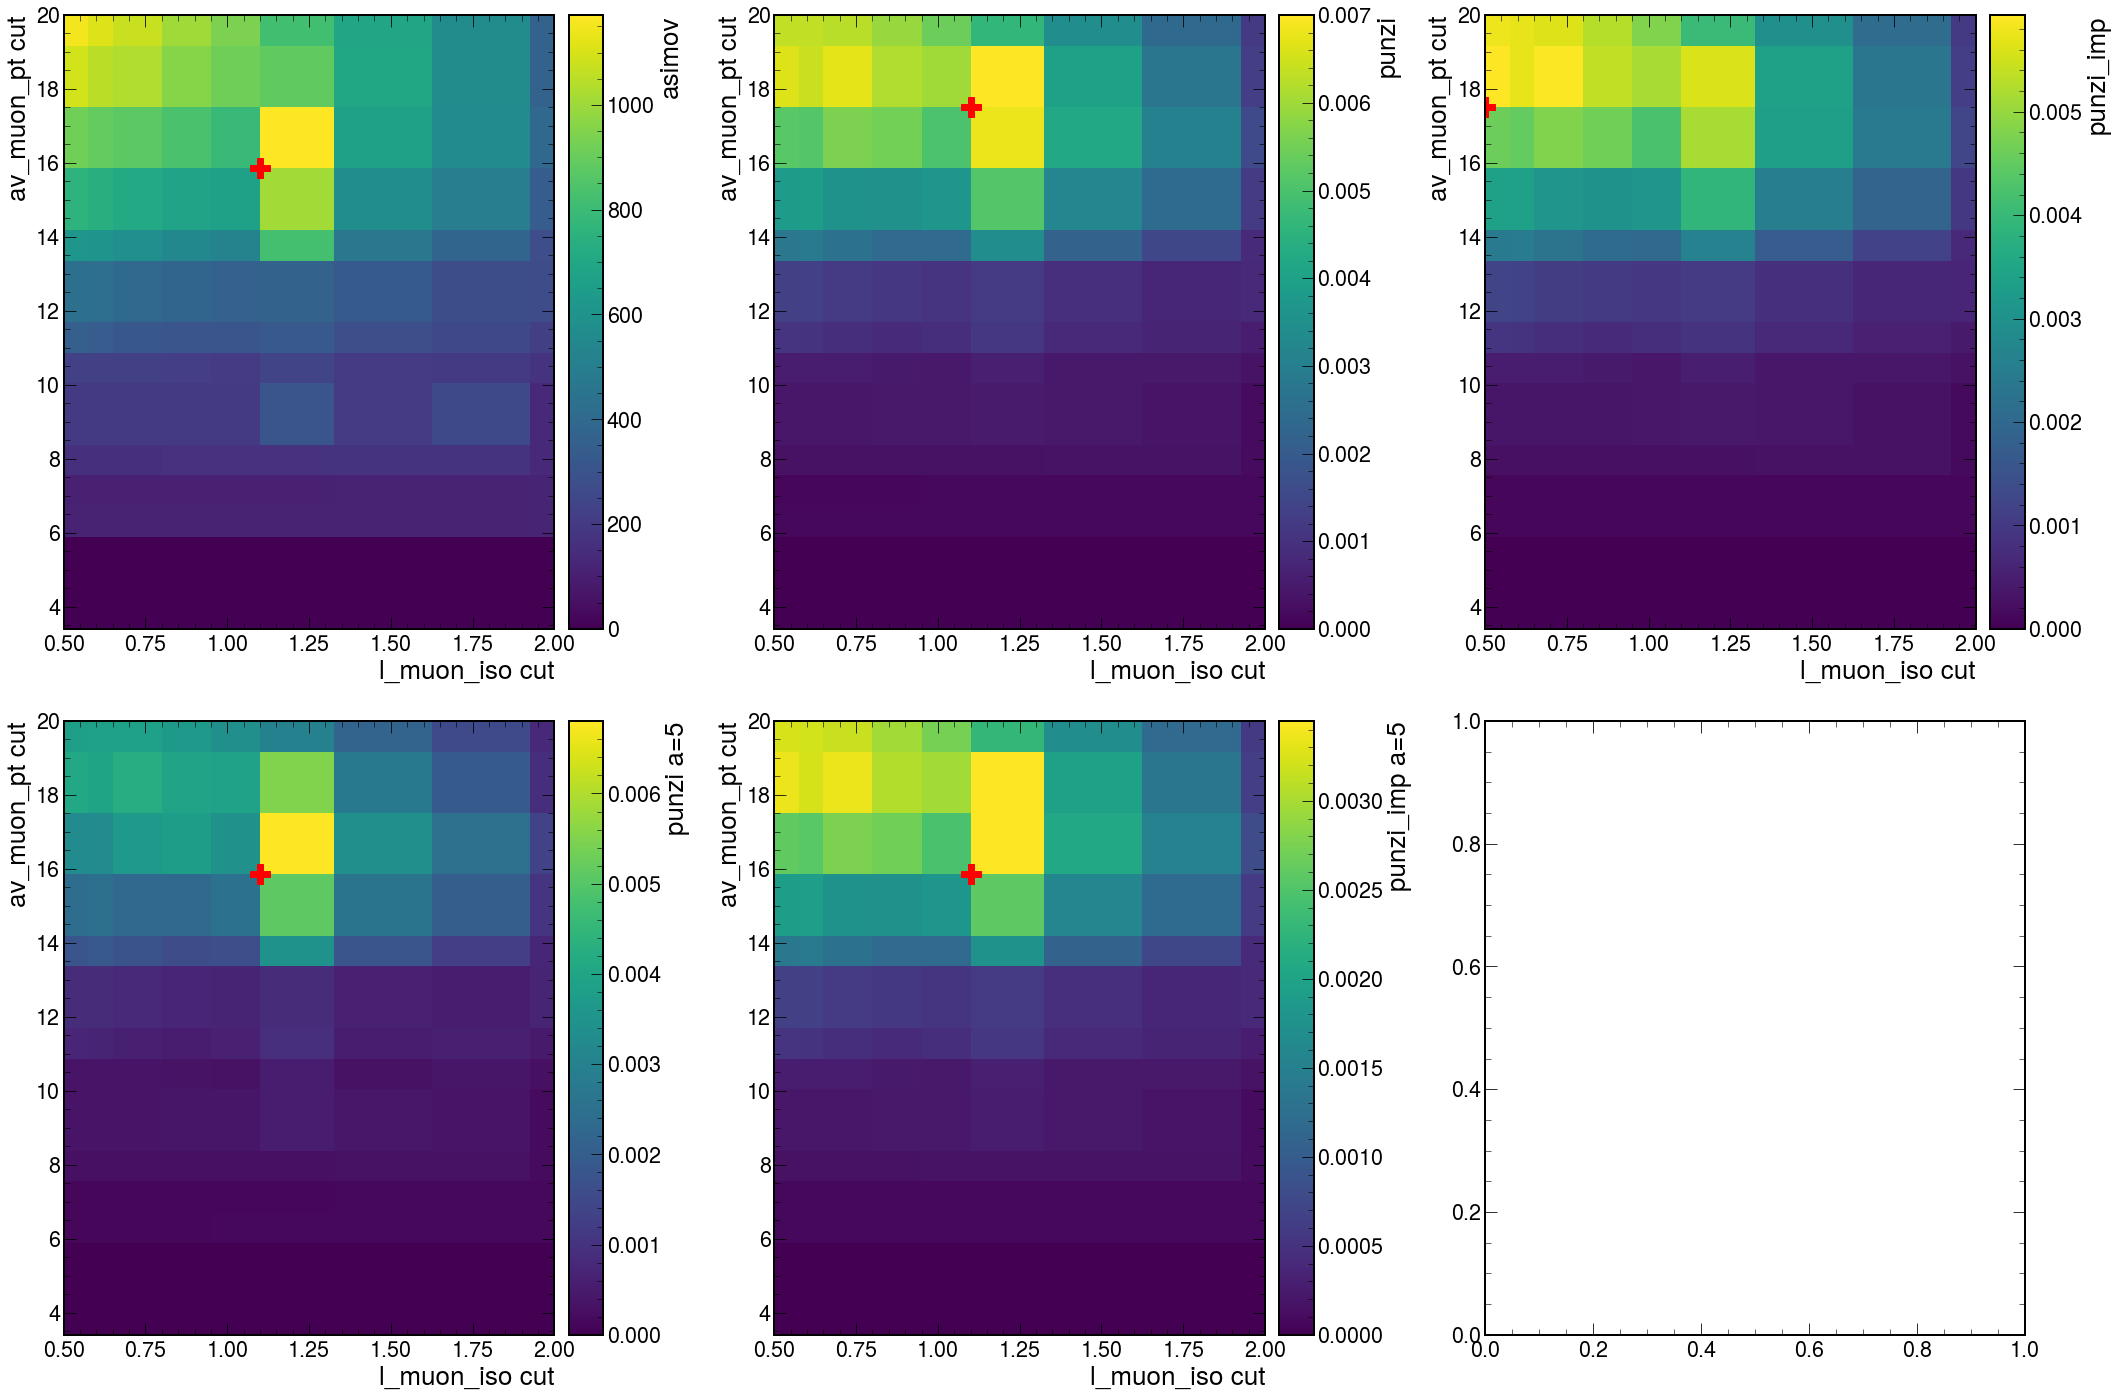

Results for SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018


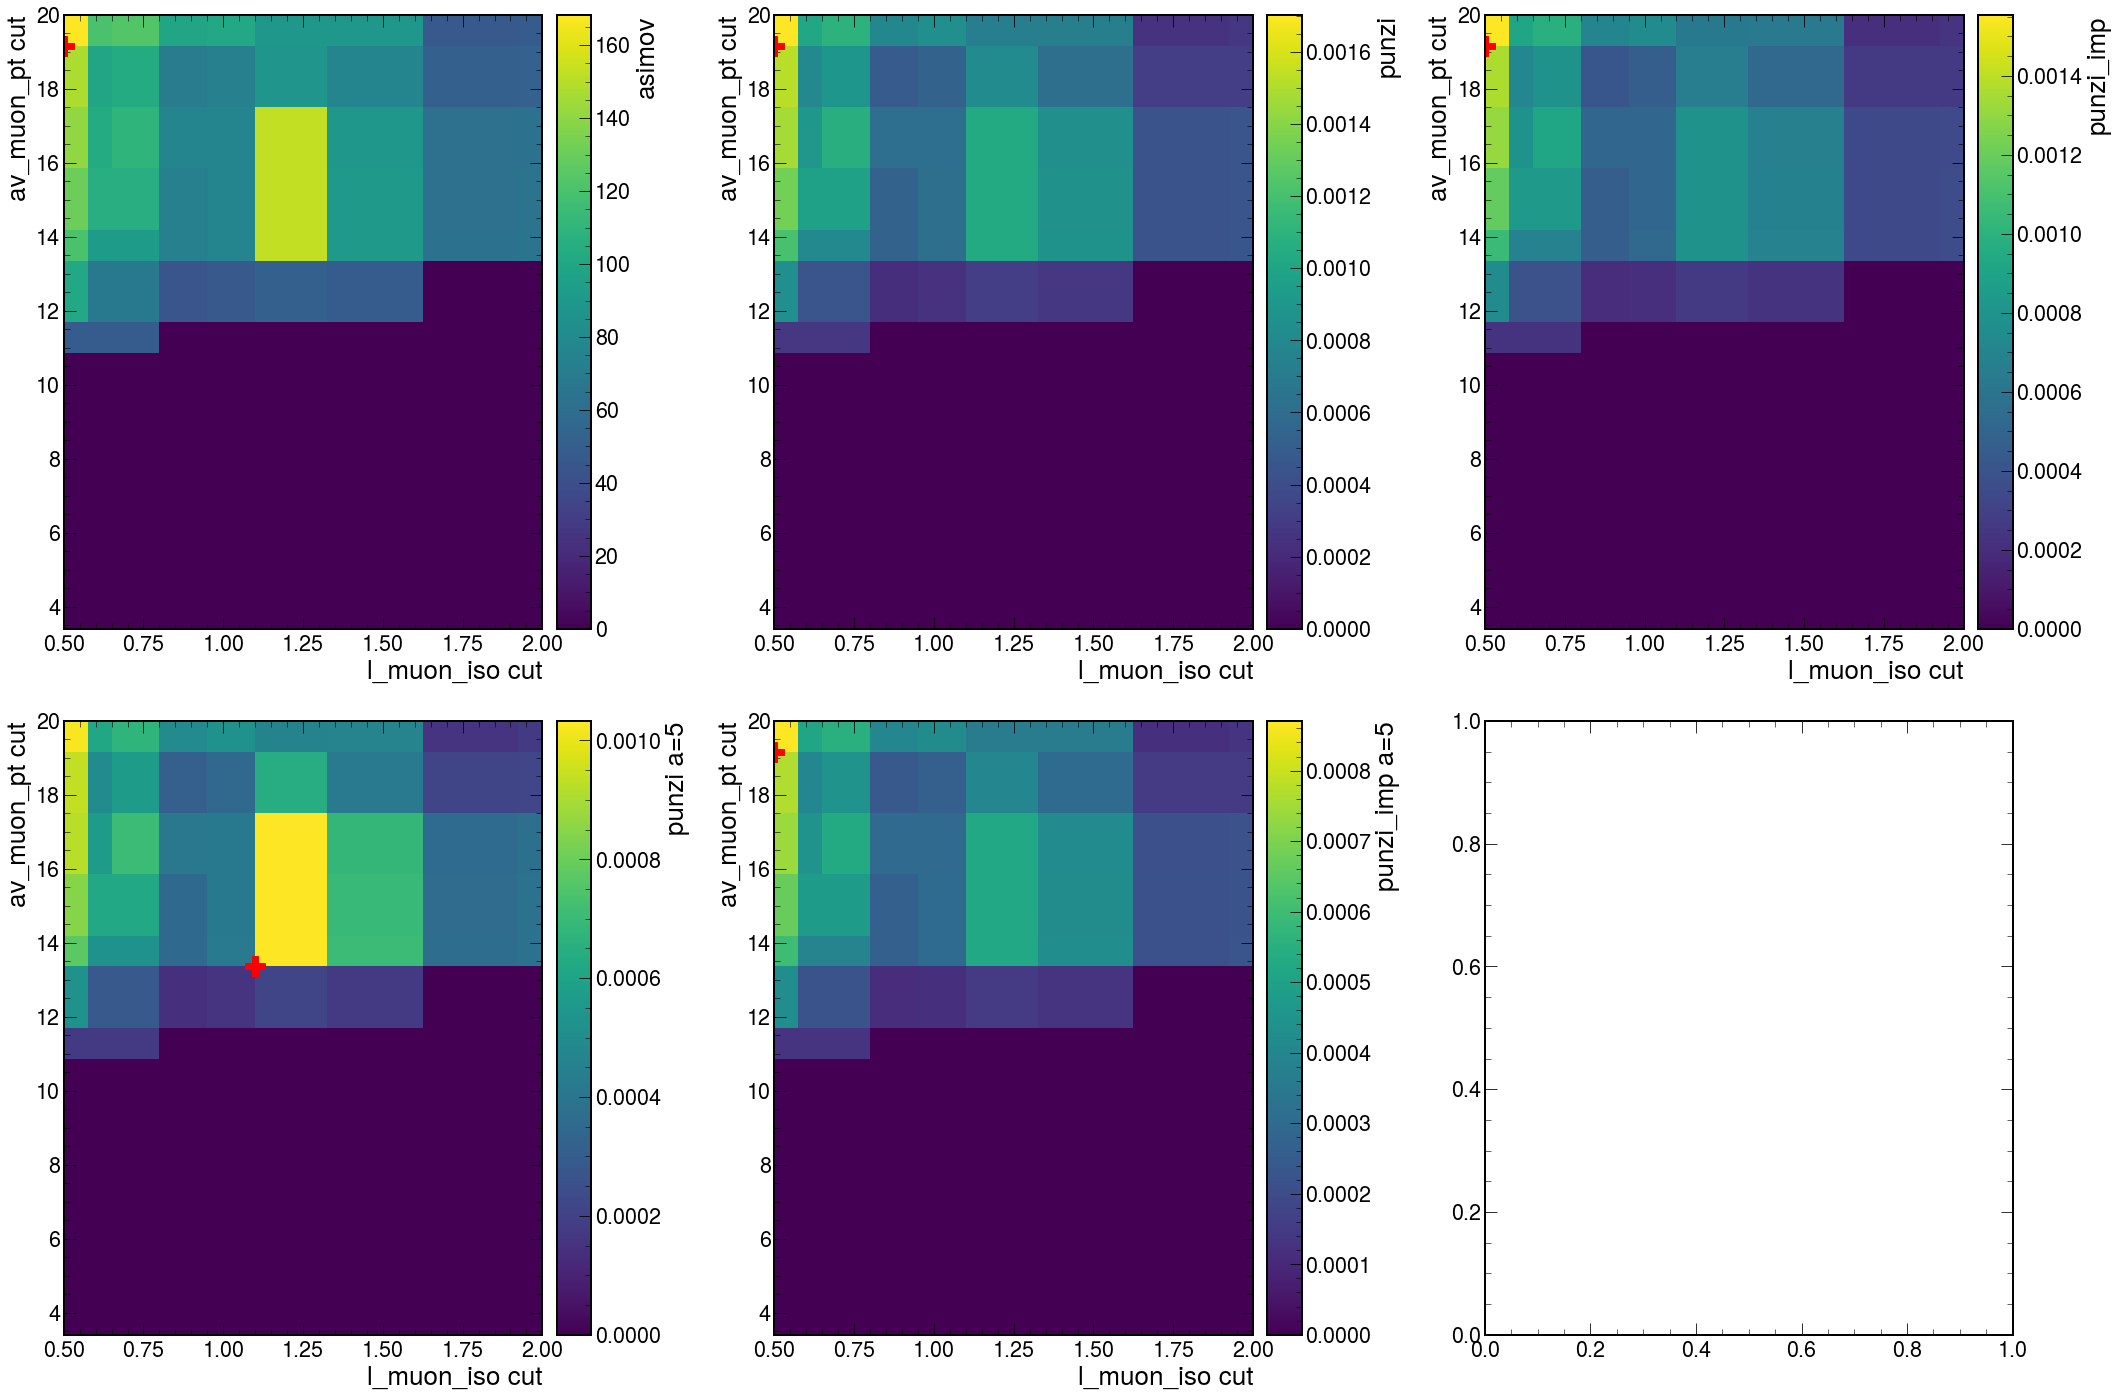

In [29]:
# Significance scans using all
for signal in signals:
    print(f"Results for {signal}")
    s_i = S[signal]
    eff_i = S[signal]/S_tot[signal]
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))
    
    #sig = S_over_SB(s_i, B)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[0, 0])
    #axs[0, 0].set_xlabel('l_muon_iso cut')
    #axs[0, 0].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_over_SB")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    #sig = S_12(s_i, B)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[0, 1])
    #axs[0, 1].set_xlabel('l_muon_iso cut')
    #axs[0, 1].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_12")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 0)
    sig = asimov_sig(s_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("asimov")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    #sig = S_over_BdB(s_i, B, deltaB2)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[1, 0])
    #axs[1, 0].set_xlabel('l_muon_iso cut')
    #axs[1, 0].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_over_BdB")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 1)
    sig = punzi(eff_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 2)
    sig = punzi_imp(eff_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi_imp")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (1, 0)
    sig = punzi(eff_i, B, a=5)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi a=5")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (1, 1)
    sig = punzi_imp(eff_i, B, a=5)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi_imp a=5")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    plt.tight_layout()
    plt.show()

Results for SUEP-m125-darkPho_2018


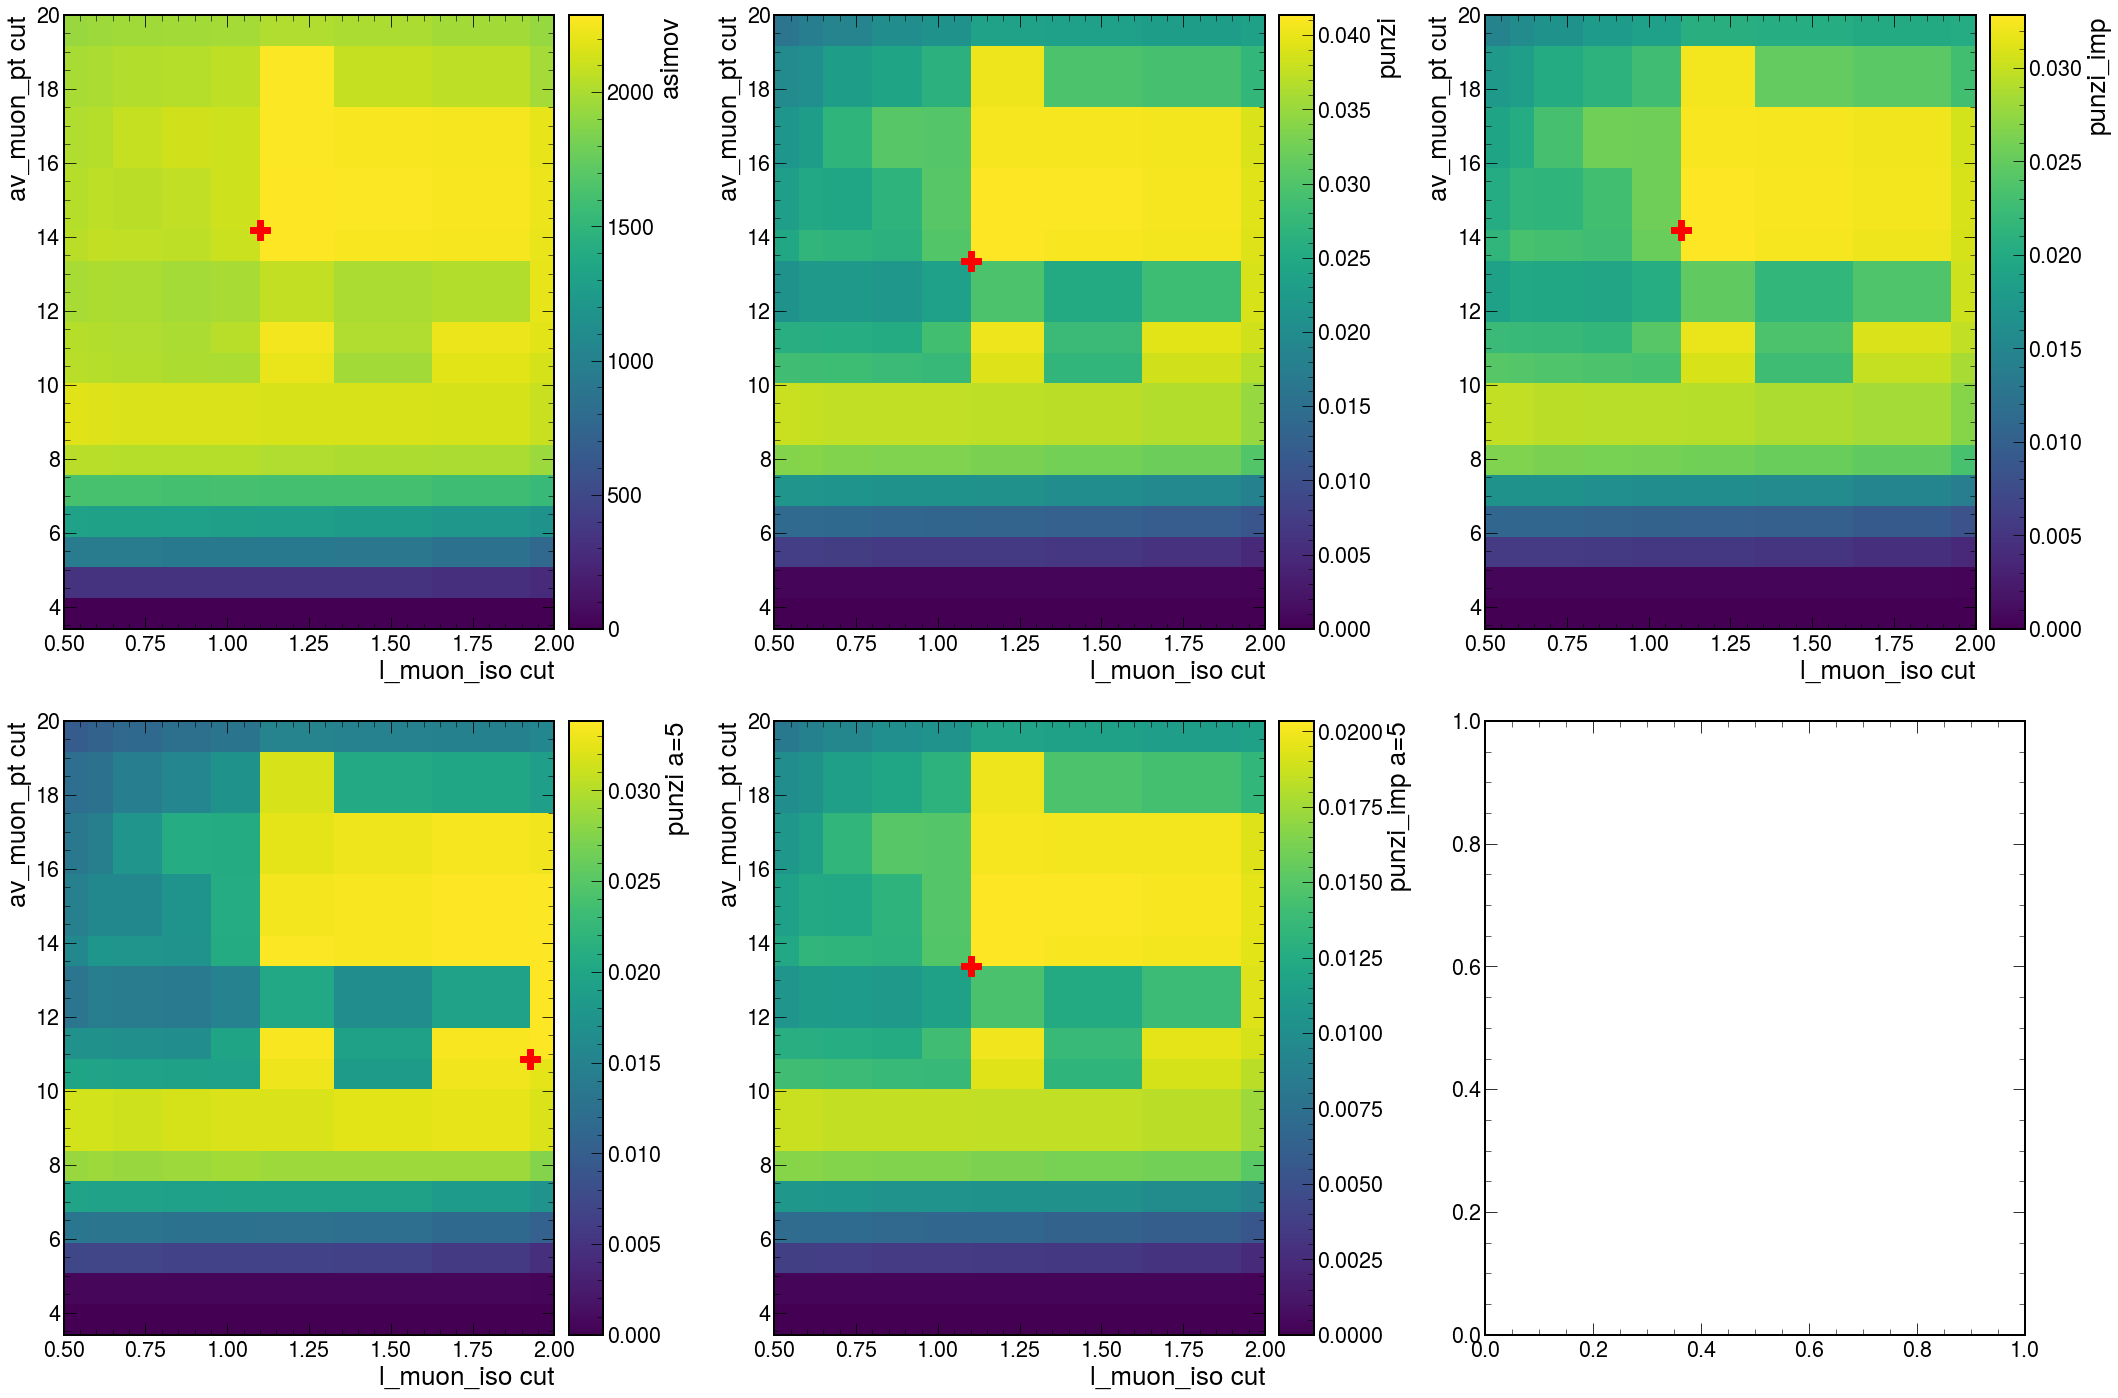

Results for SUEP-m400-darkPho_2018


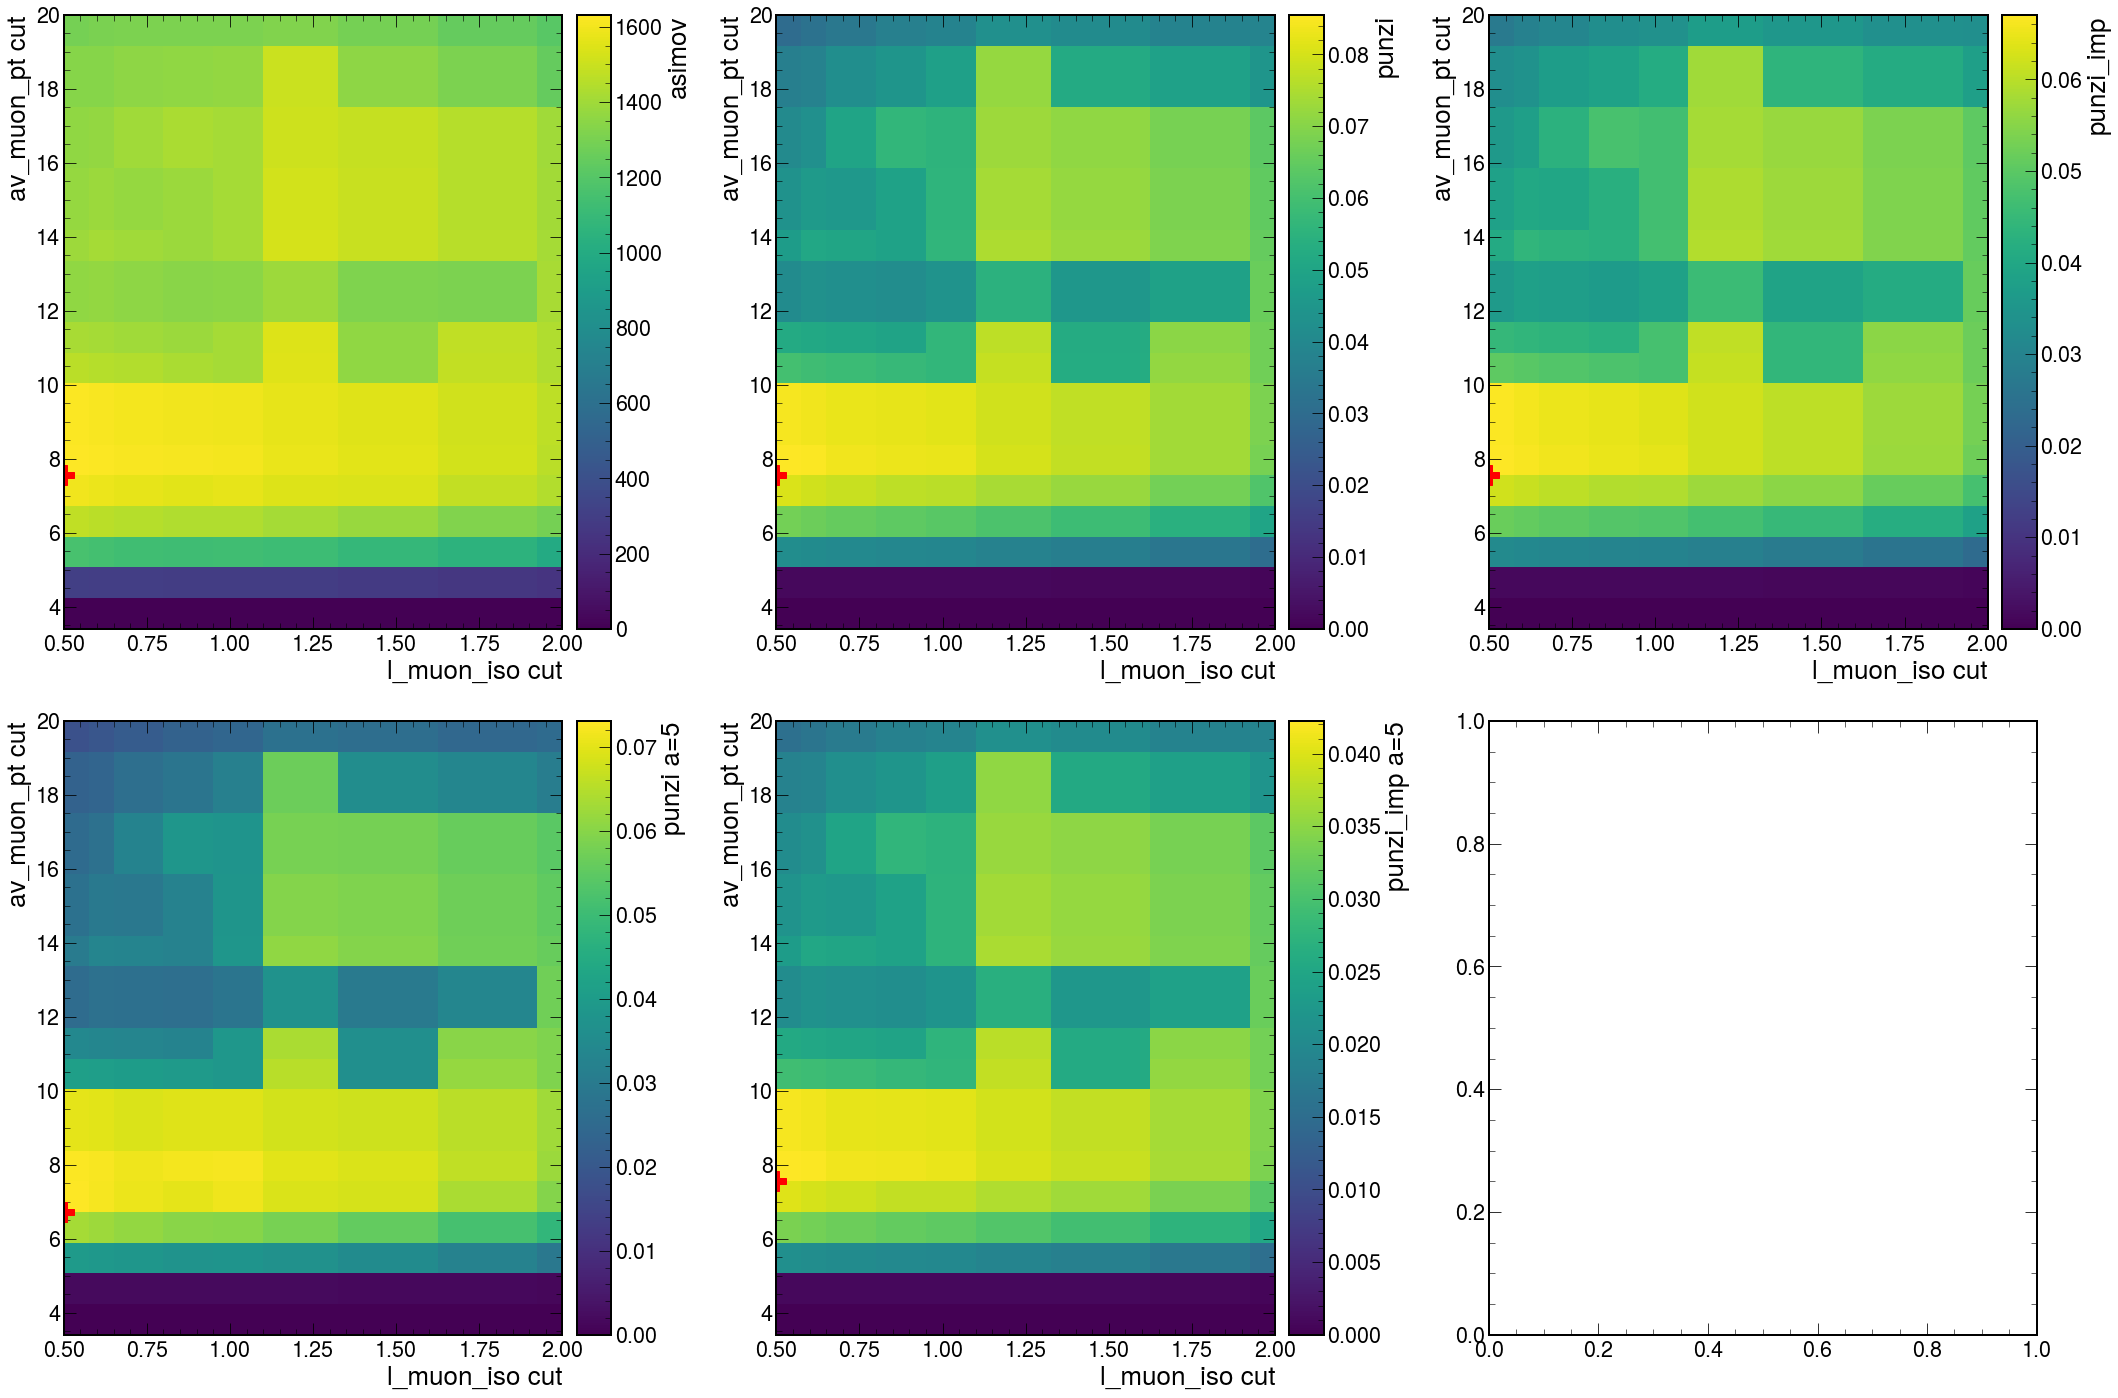

Results for SUEP_mMed-125_mDark-8_temp-32_decay-darkPho_2018


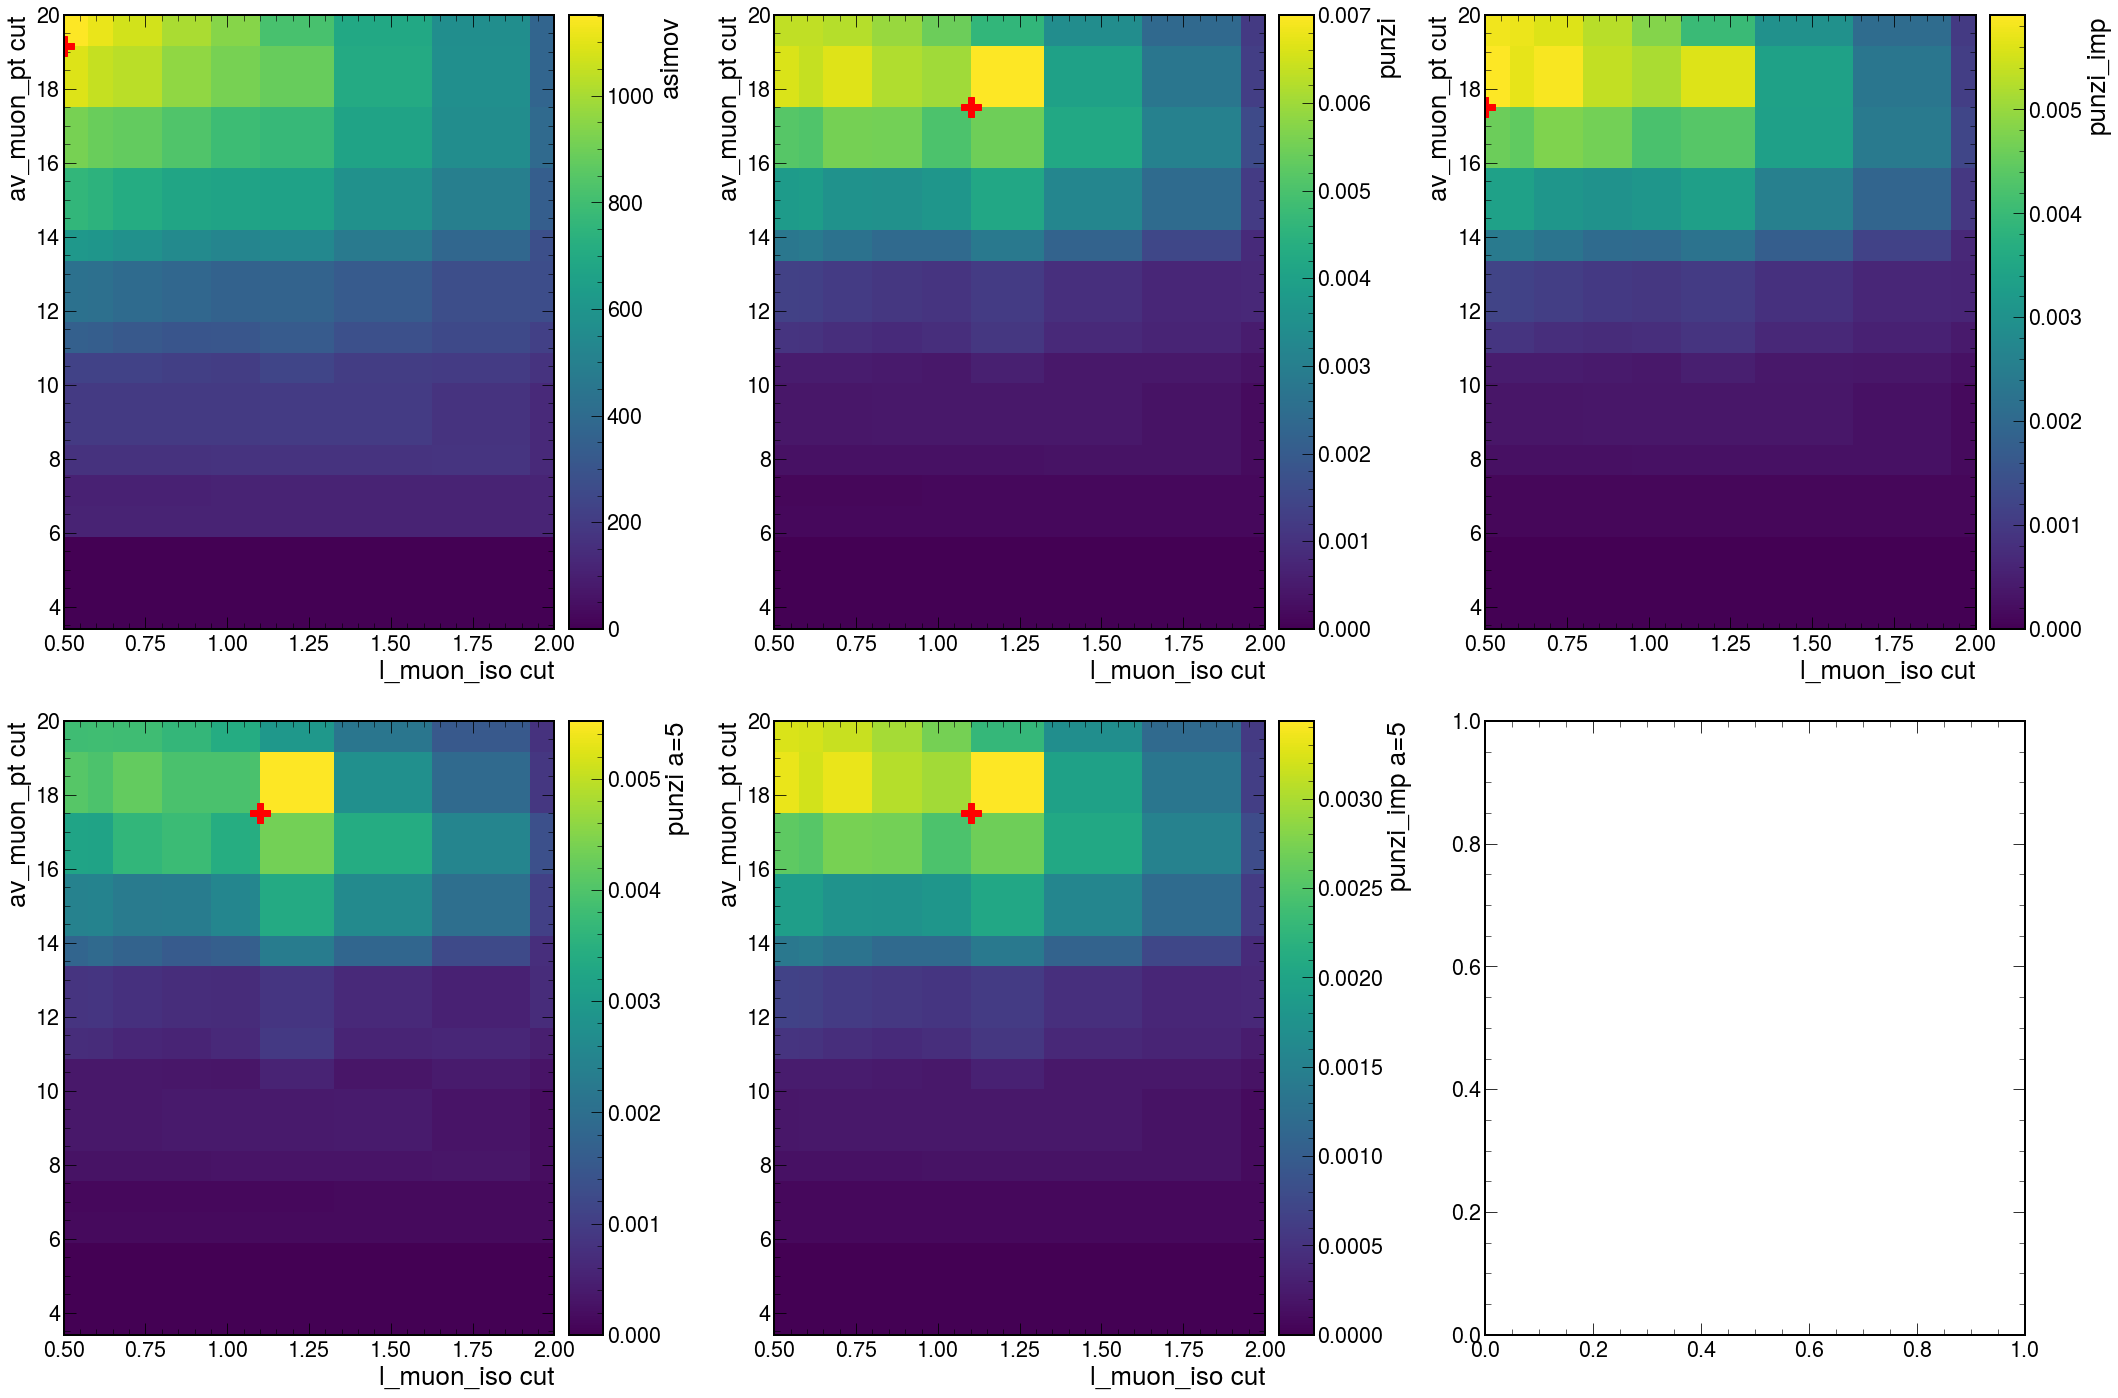

Results for SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018


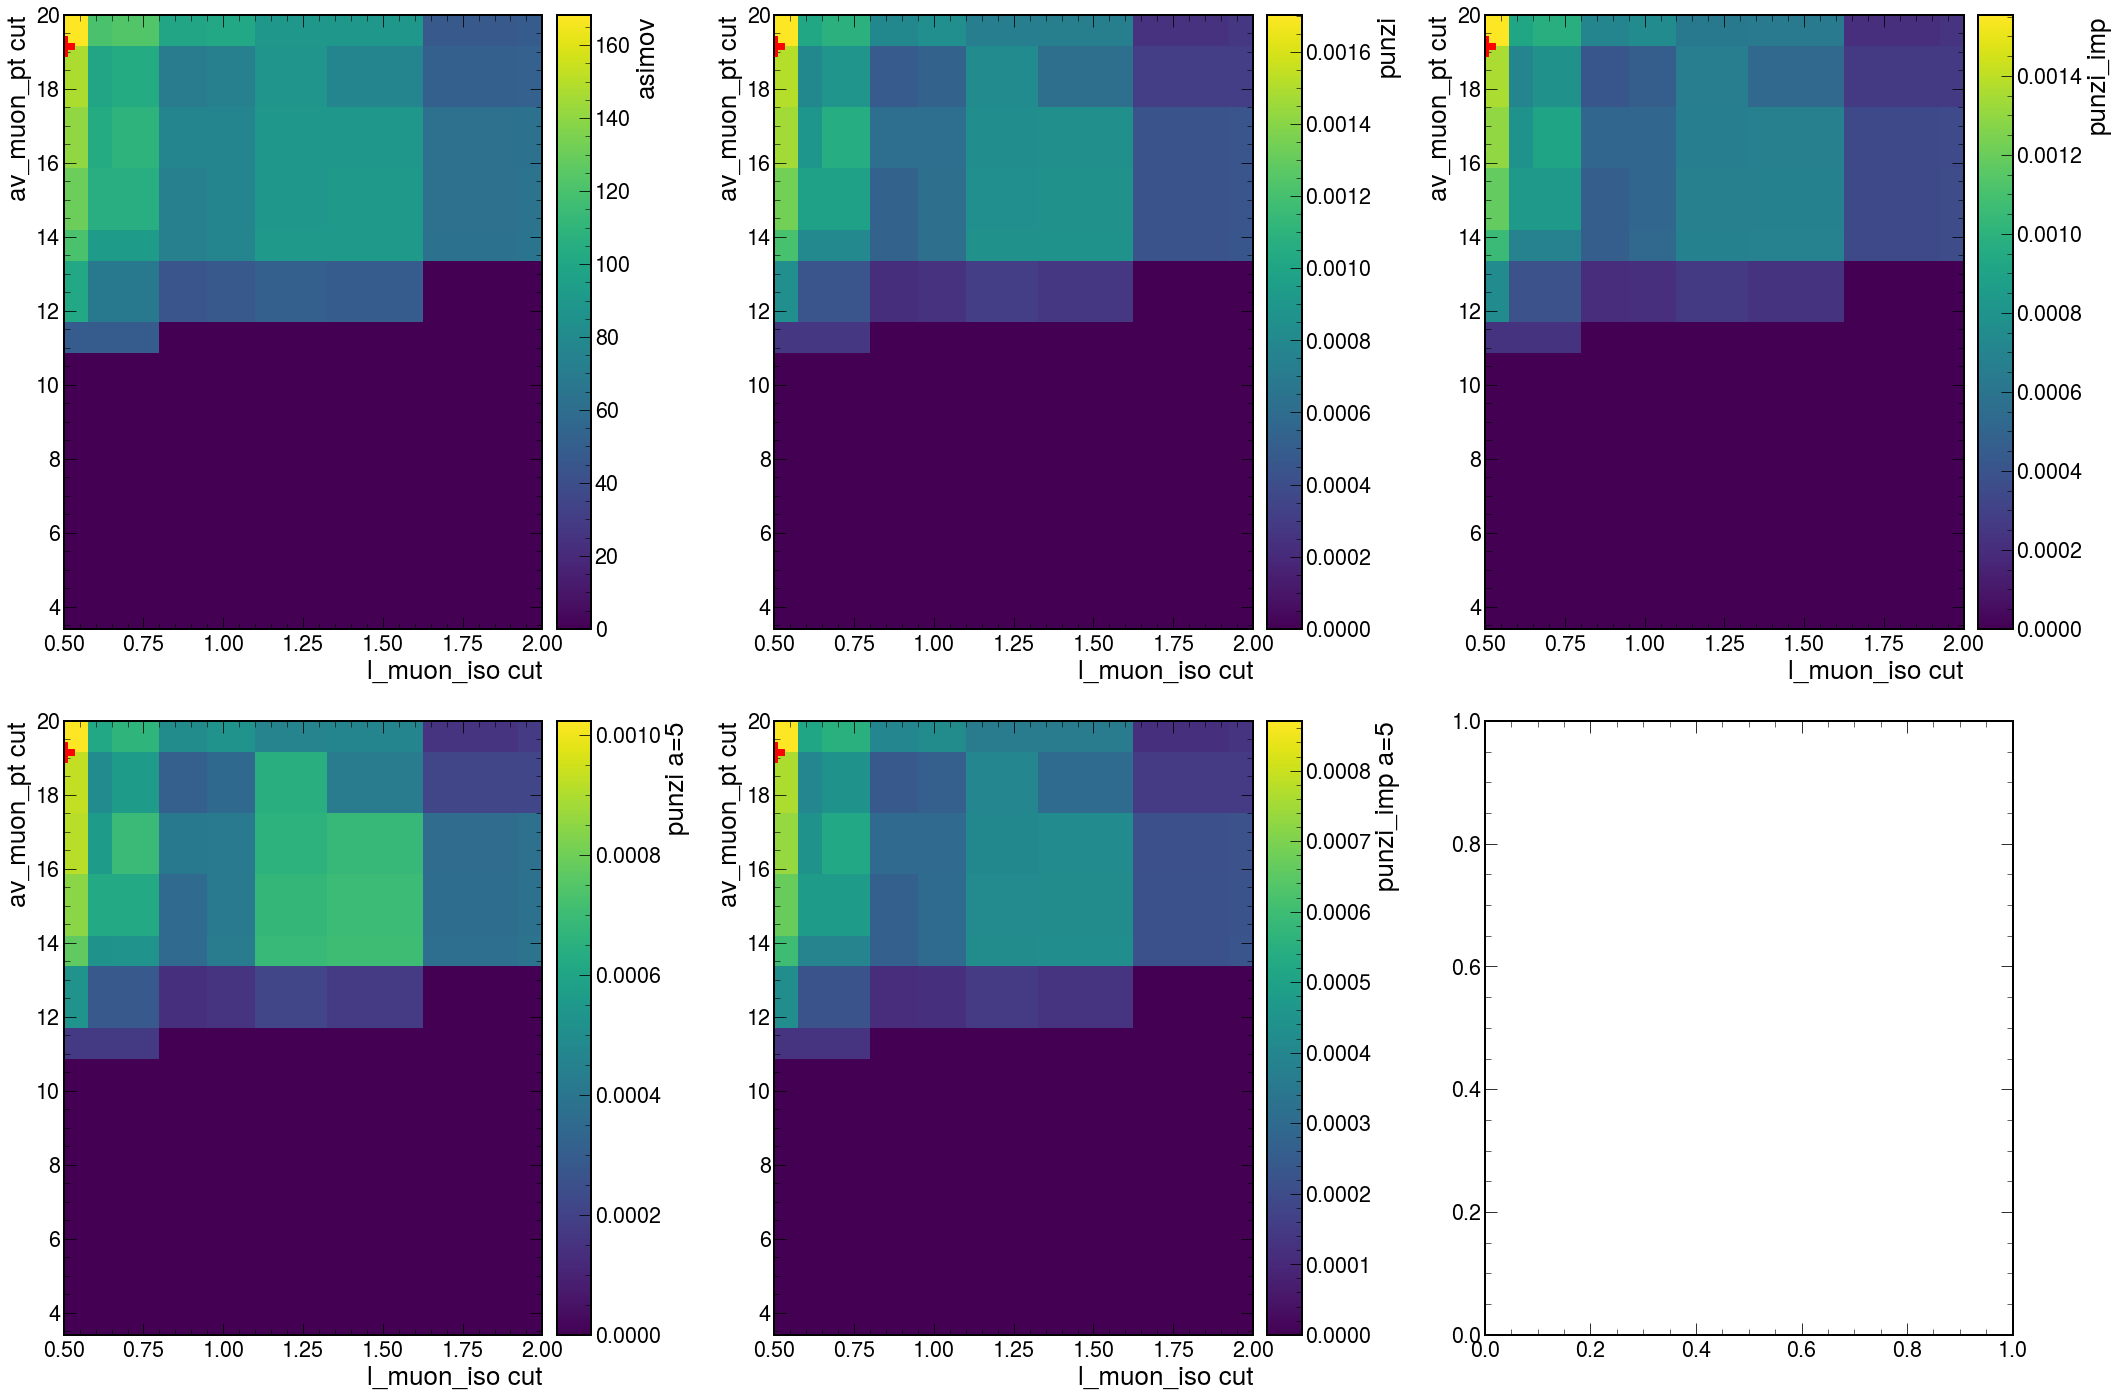

In [31]:
# Significance scans using only non-negative B
for signal in signals:
    print(f"Results for {signal}")
    s_i = S[signal]
    eff_i = S[signal]/S_tot[signal]
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))
    
    #sig = S_over_SB(s_i, B)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[0, 0])
    #axs[0, 0].set_xlabel('l_muon_iso cut')
    #axs[0, 0].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_over_SB")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    #sig = S_12(s_i, B)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[0, 1])
    #axs[0, 1].set_xlabel('l_muon_iso cut')
    #axs[0, 1].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_12")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 0)
    sig = asimov_sig(s_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("asimov")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    #sig = S_over_BdB(s_i, B, deltaB2)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[1, 0])
    #axs[1, 0].set_xlabel('l_muon_iso cut')
    #axs[1, 0].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_over_BdB")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 1)
    sig = punzi(eff_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 2)
    sig = punzi_imp(eff_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi_imp")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (1, 0)
    sig = punzi(eff_i, B, a=5)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi a=5")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (1, 1)
    sig = punzi_imp(eff_i, B, a=5)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi_imp a=5")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    plt.tight_layout()
    plt.show()

Results for SUEP-m125-darkPho_2018


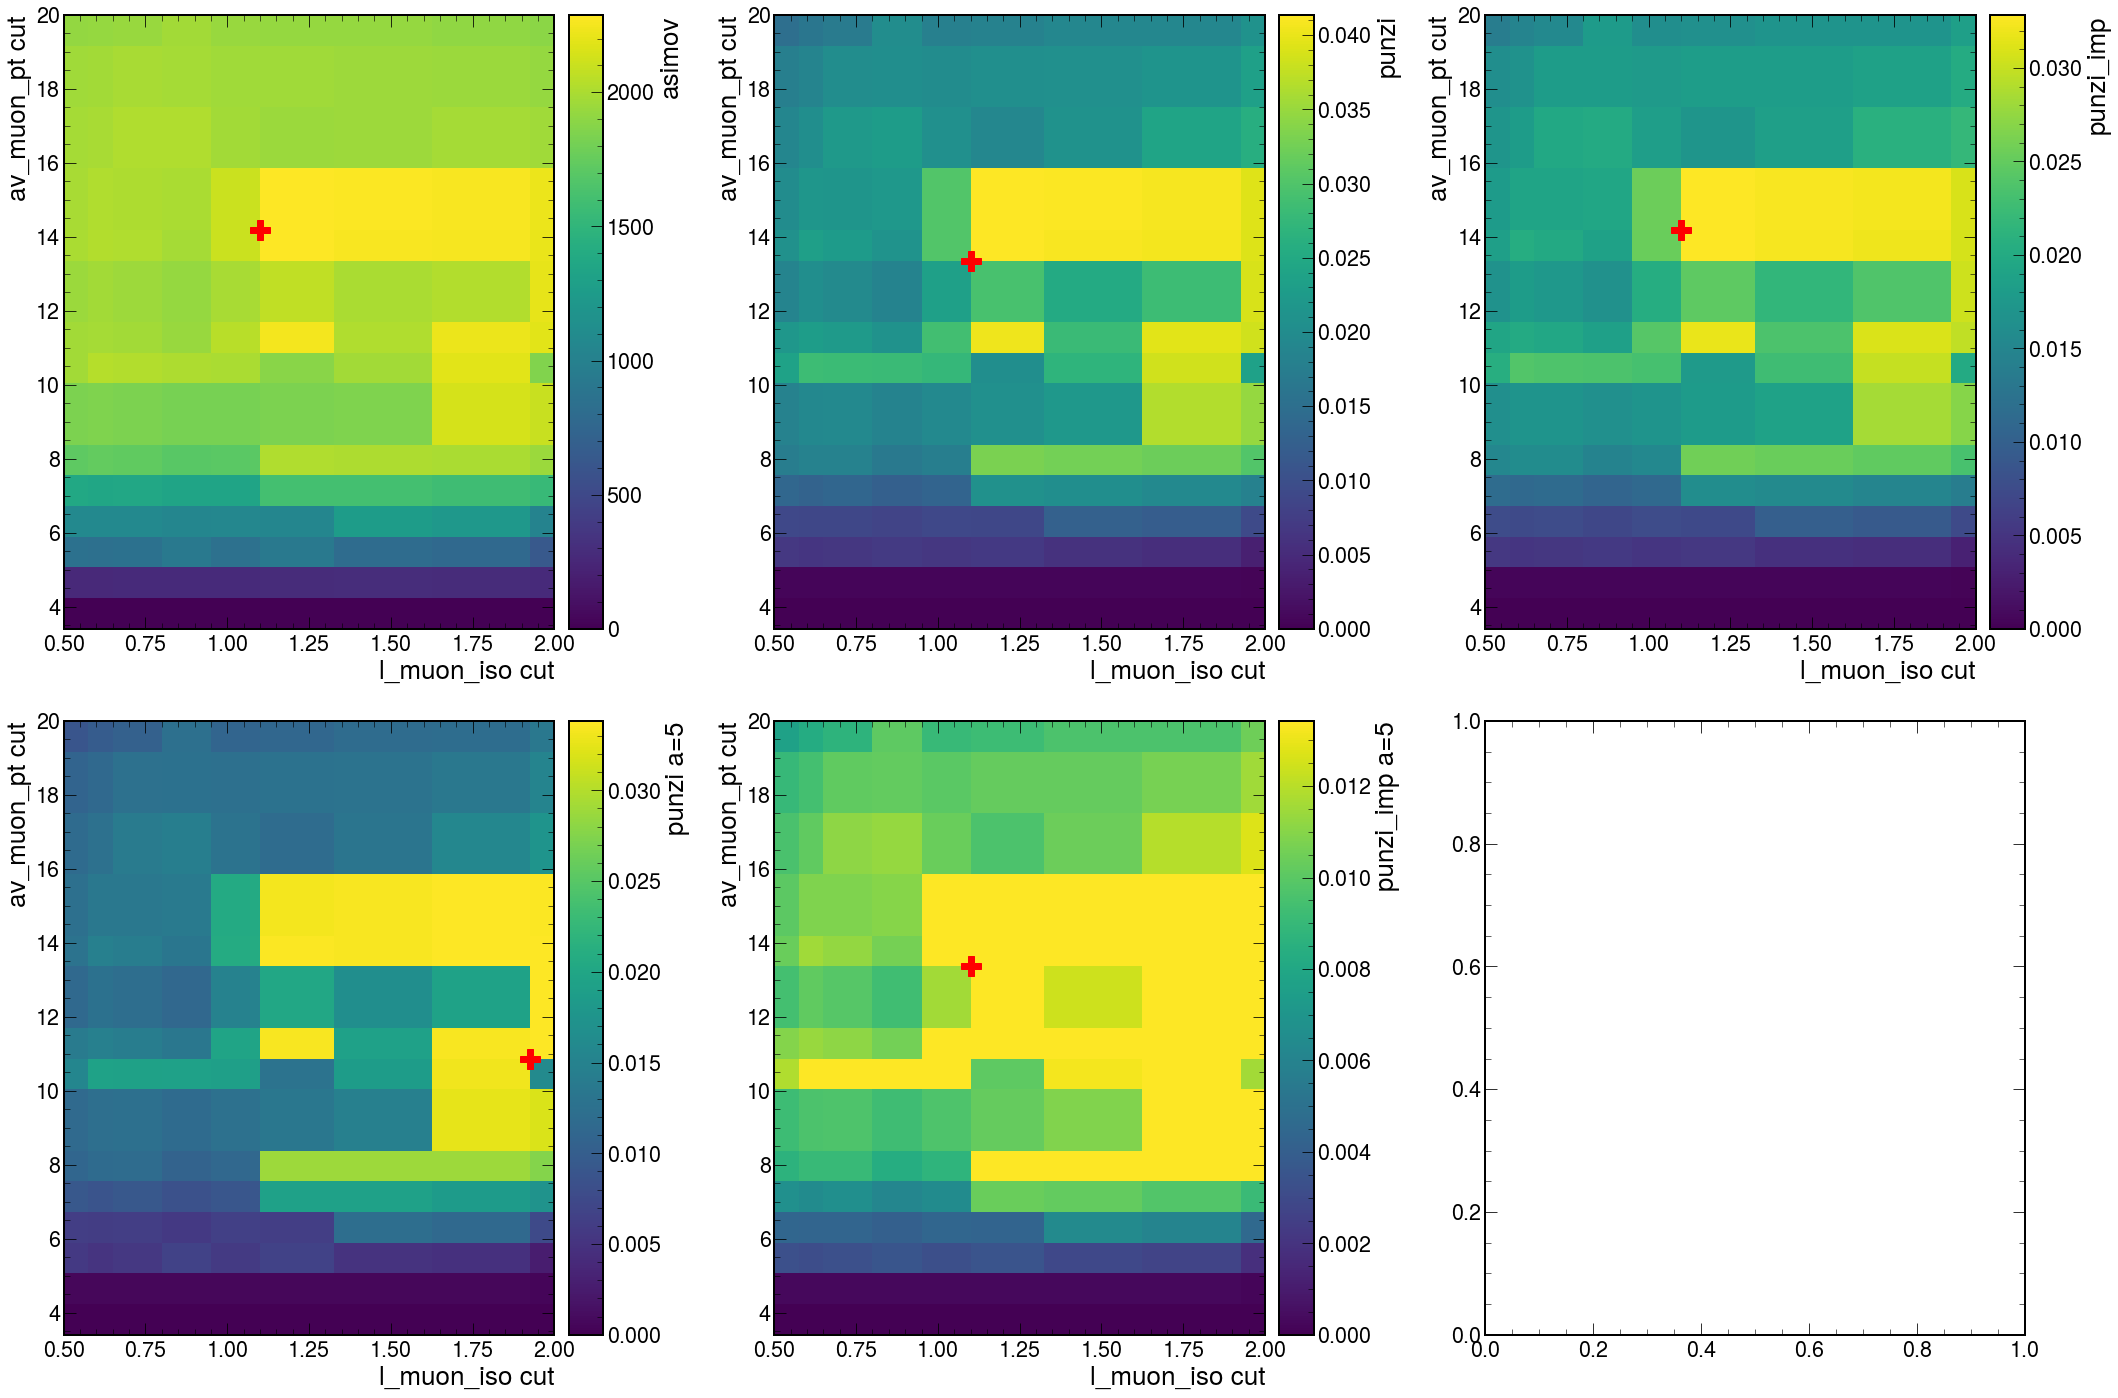

Results for SUEP-m400-darkPho_2018


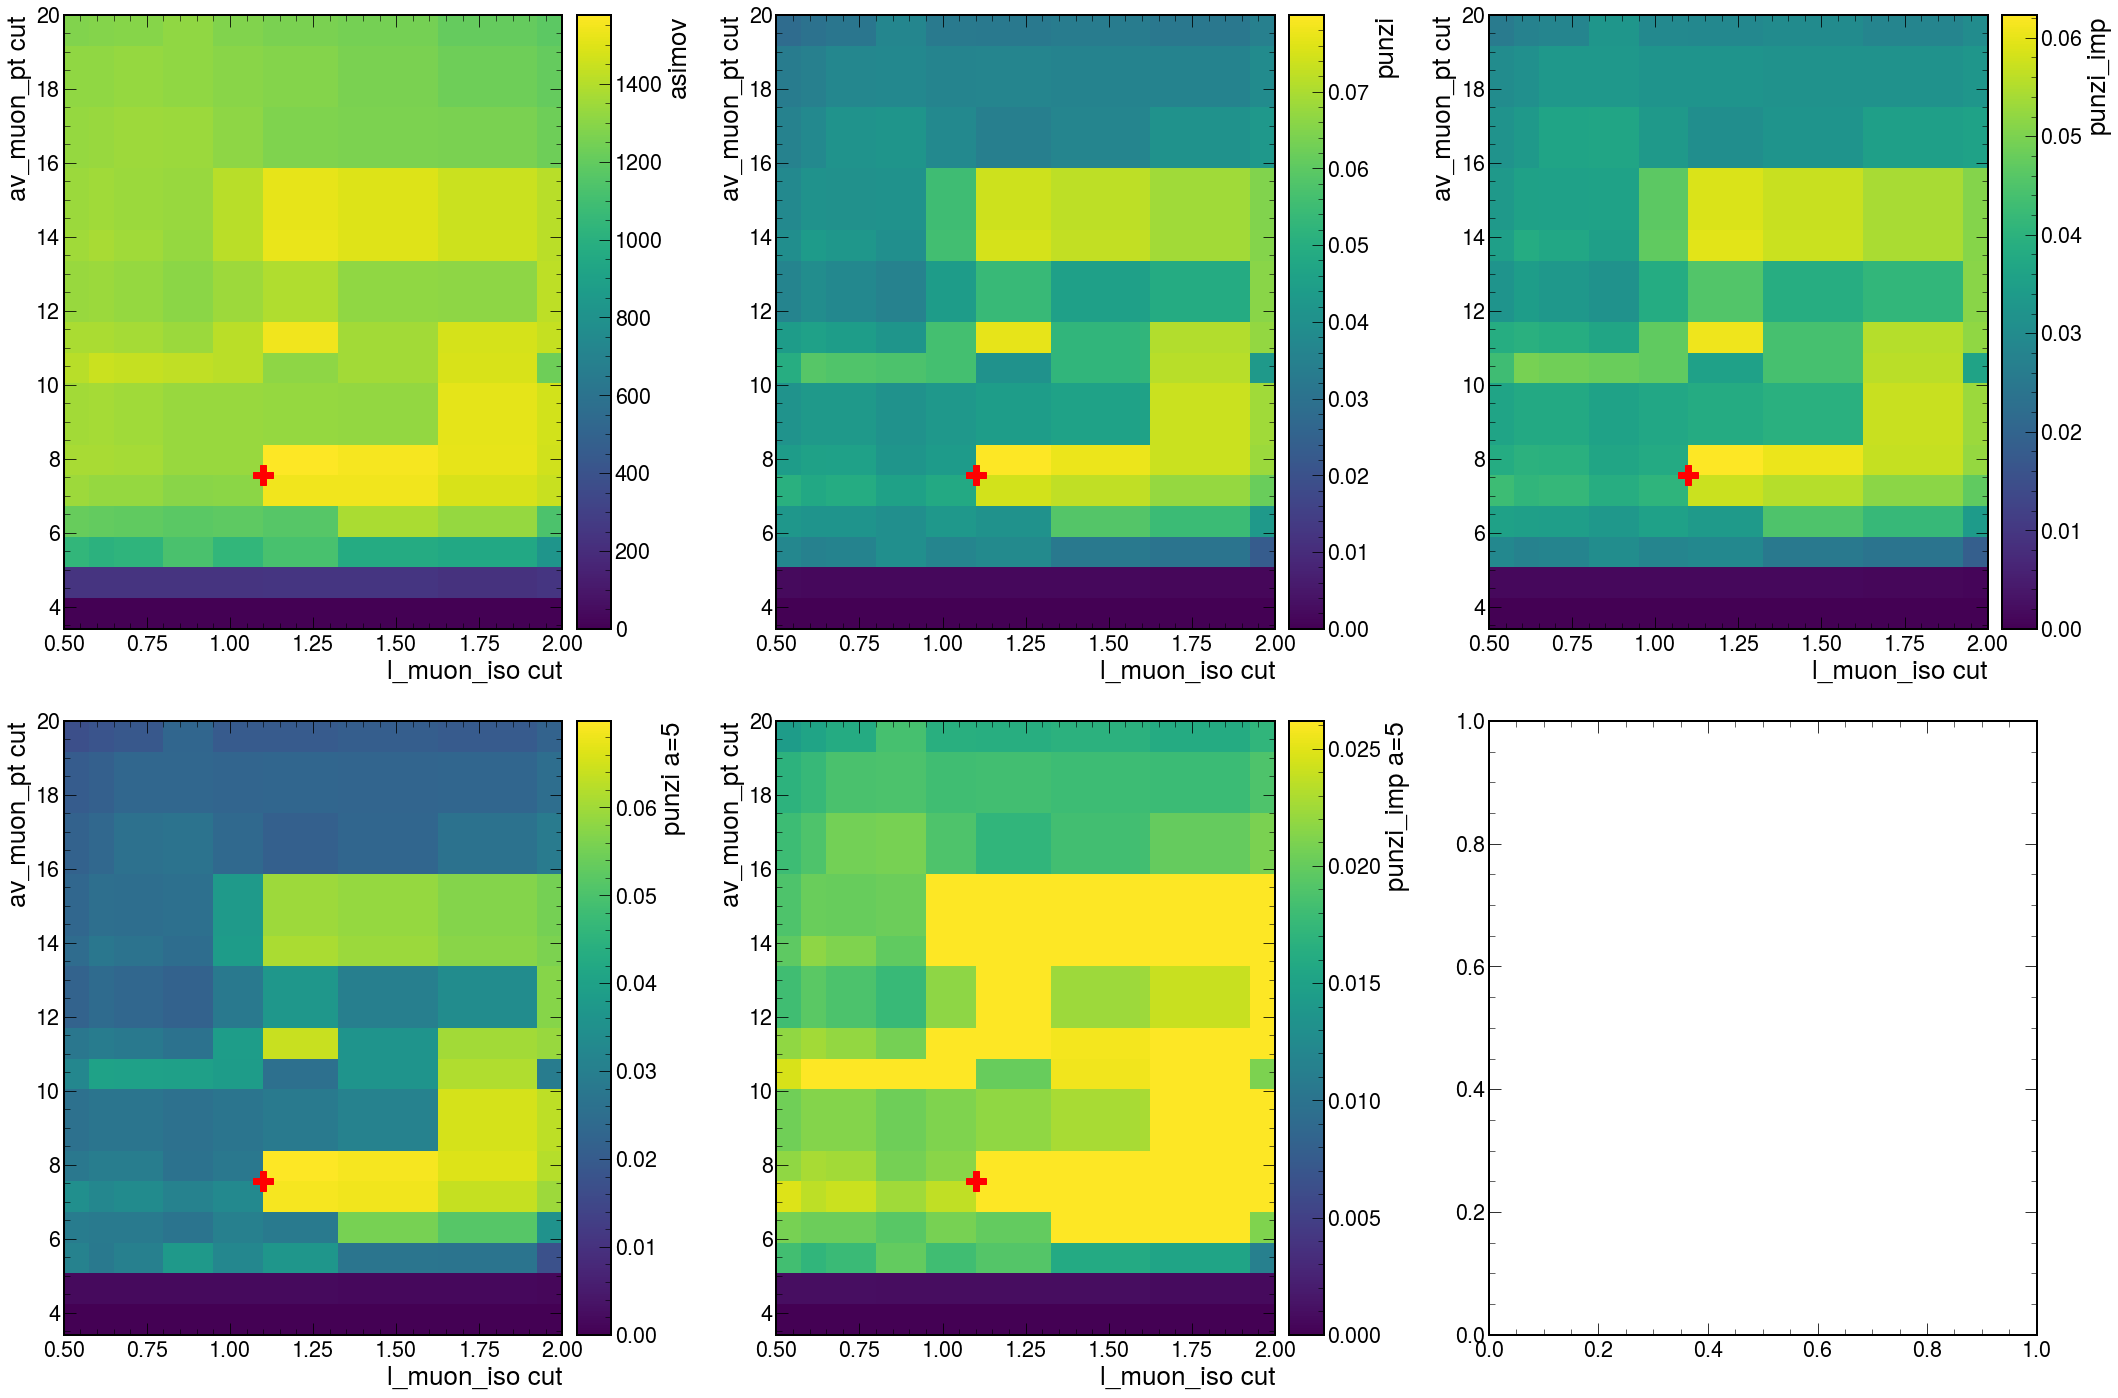

Results for SUEP_mMed-125_mDark-8_temp-32_decay-darkPho_2018


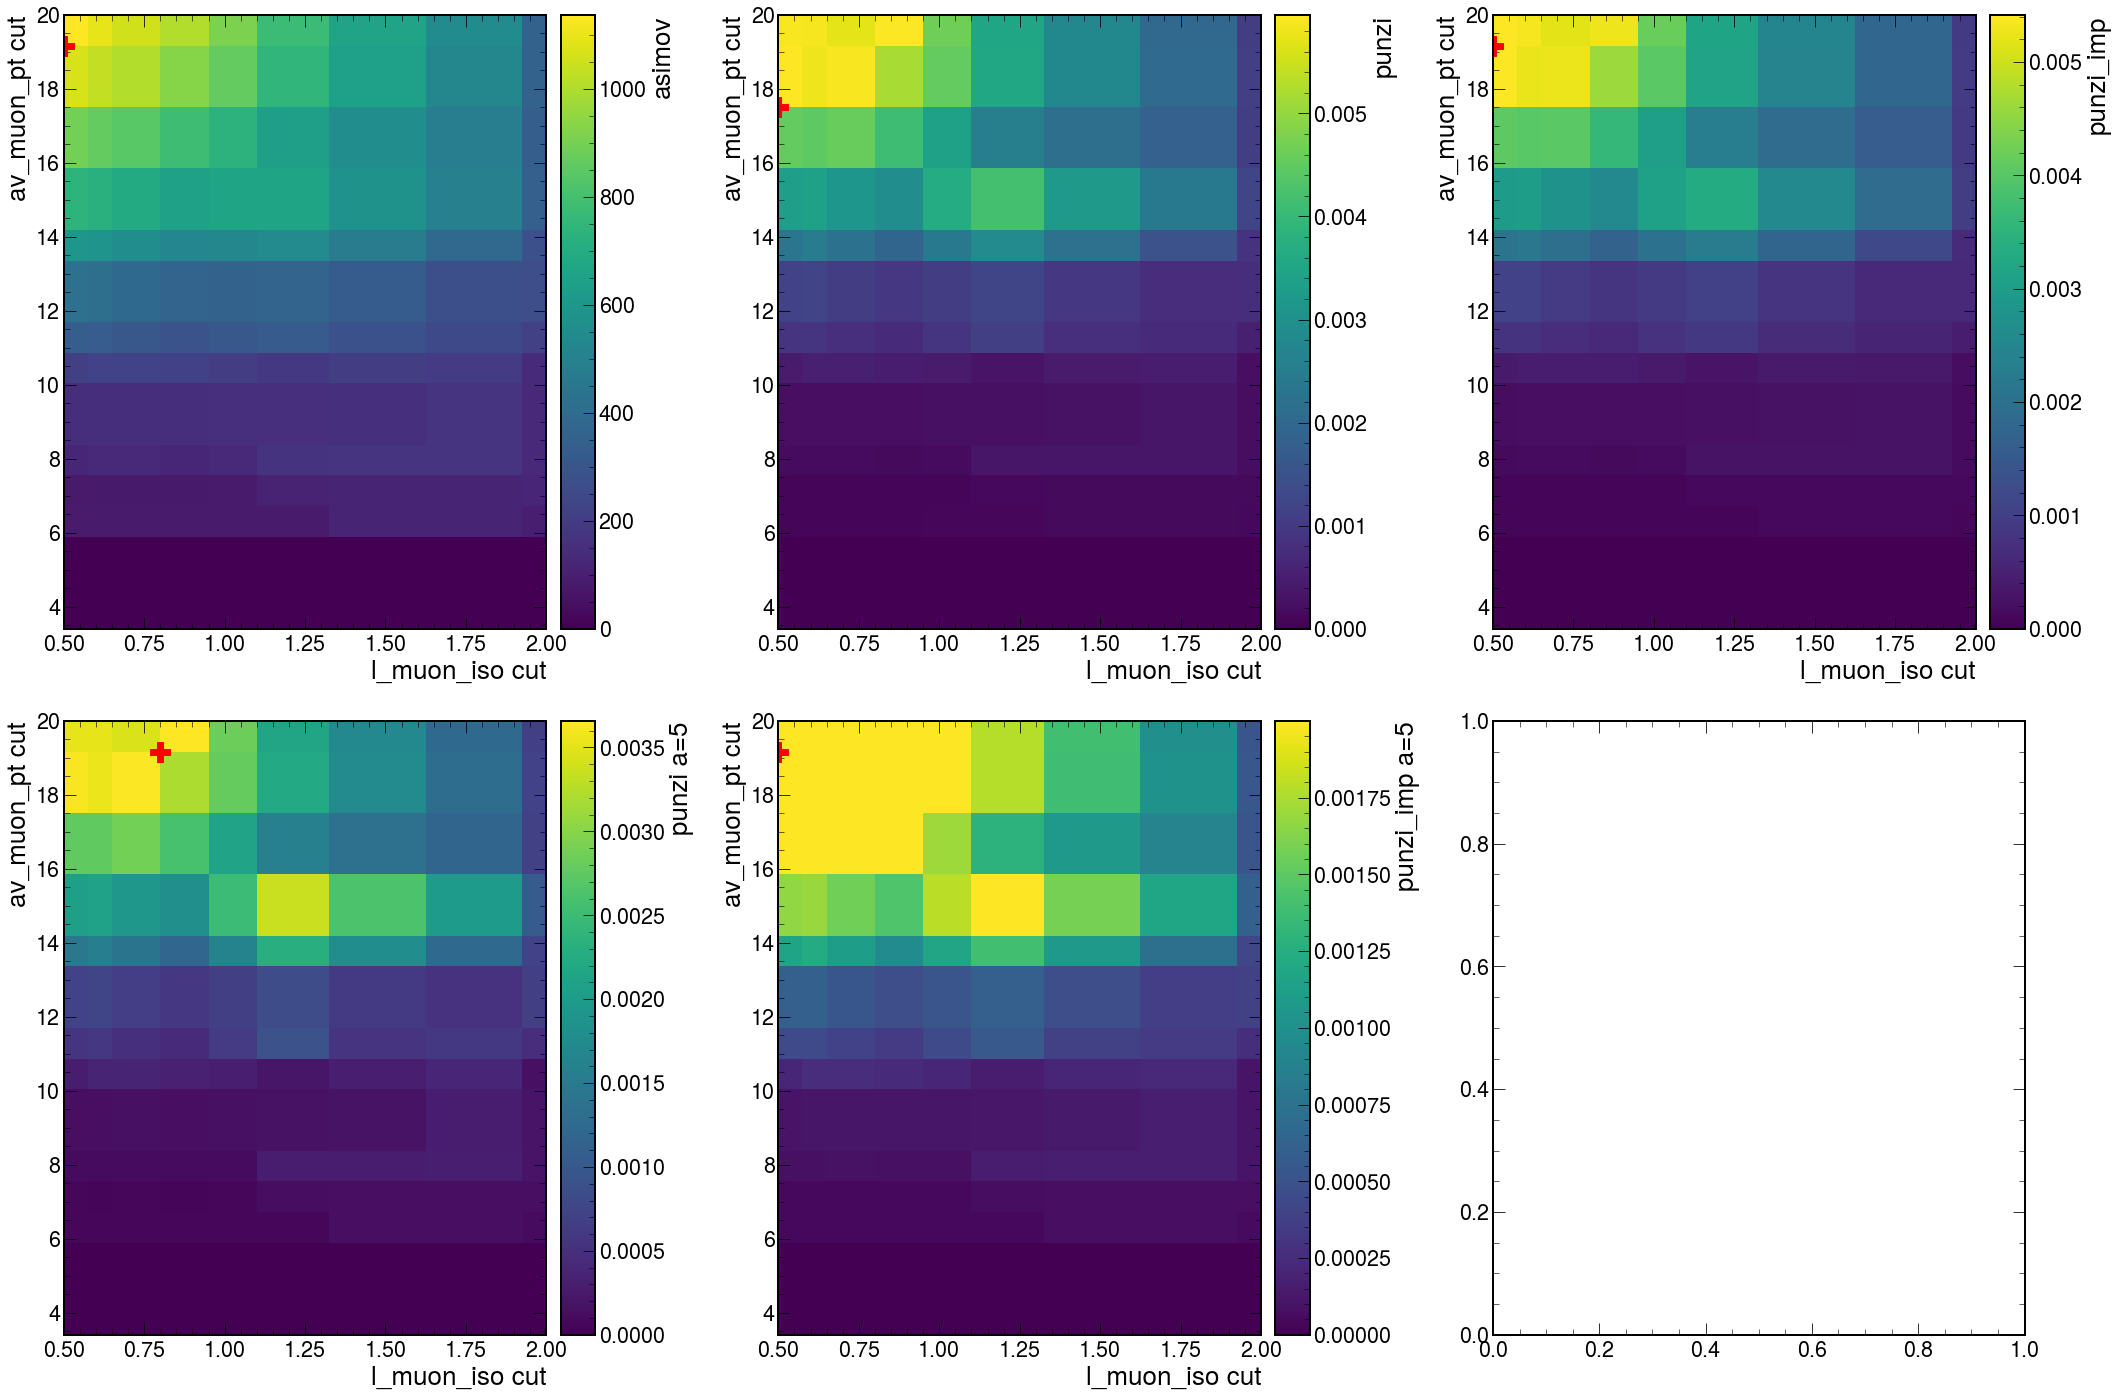

Results for SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018


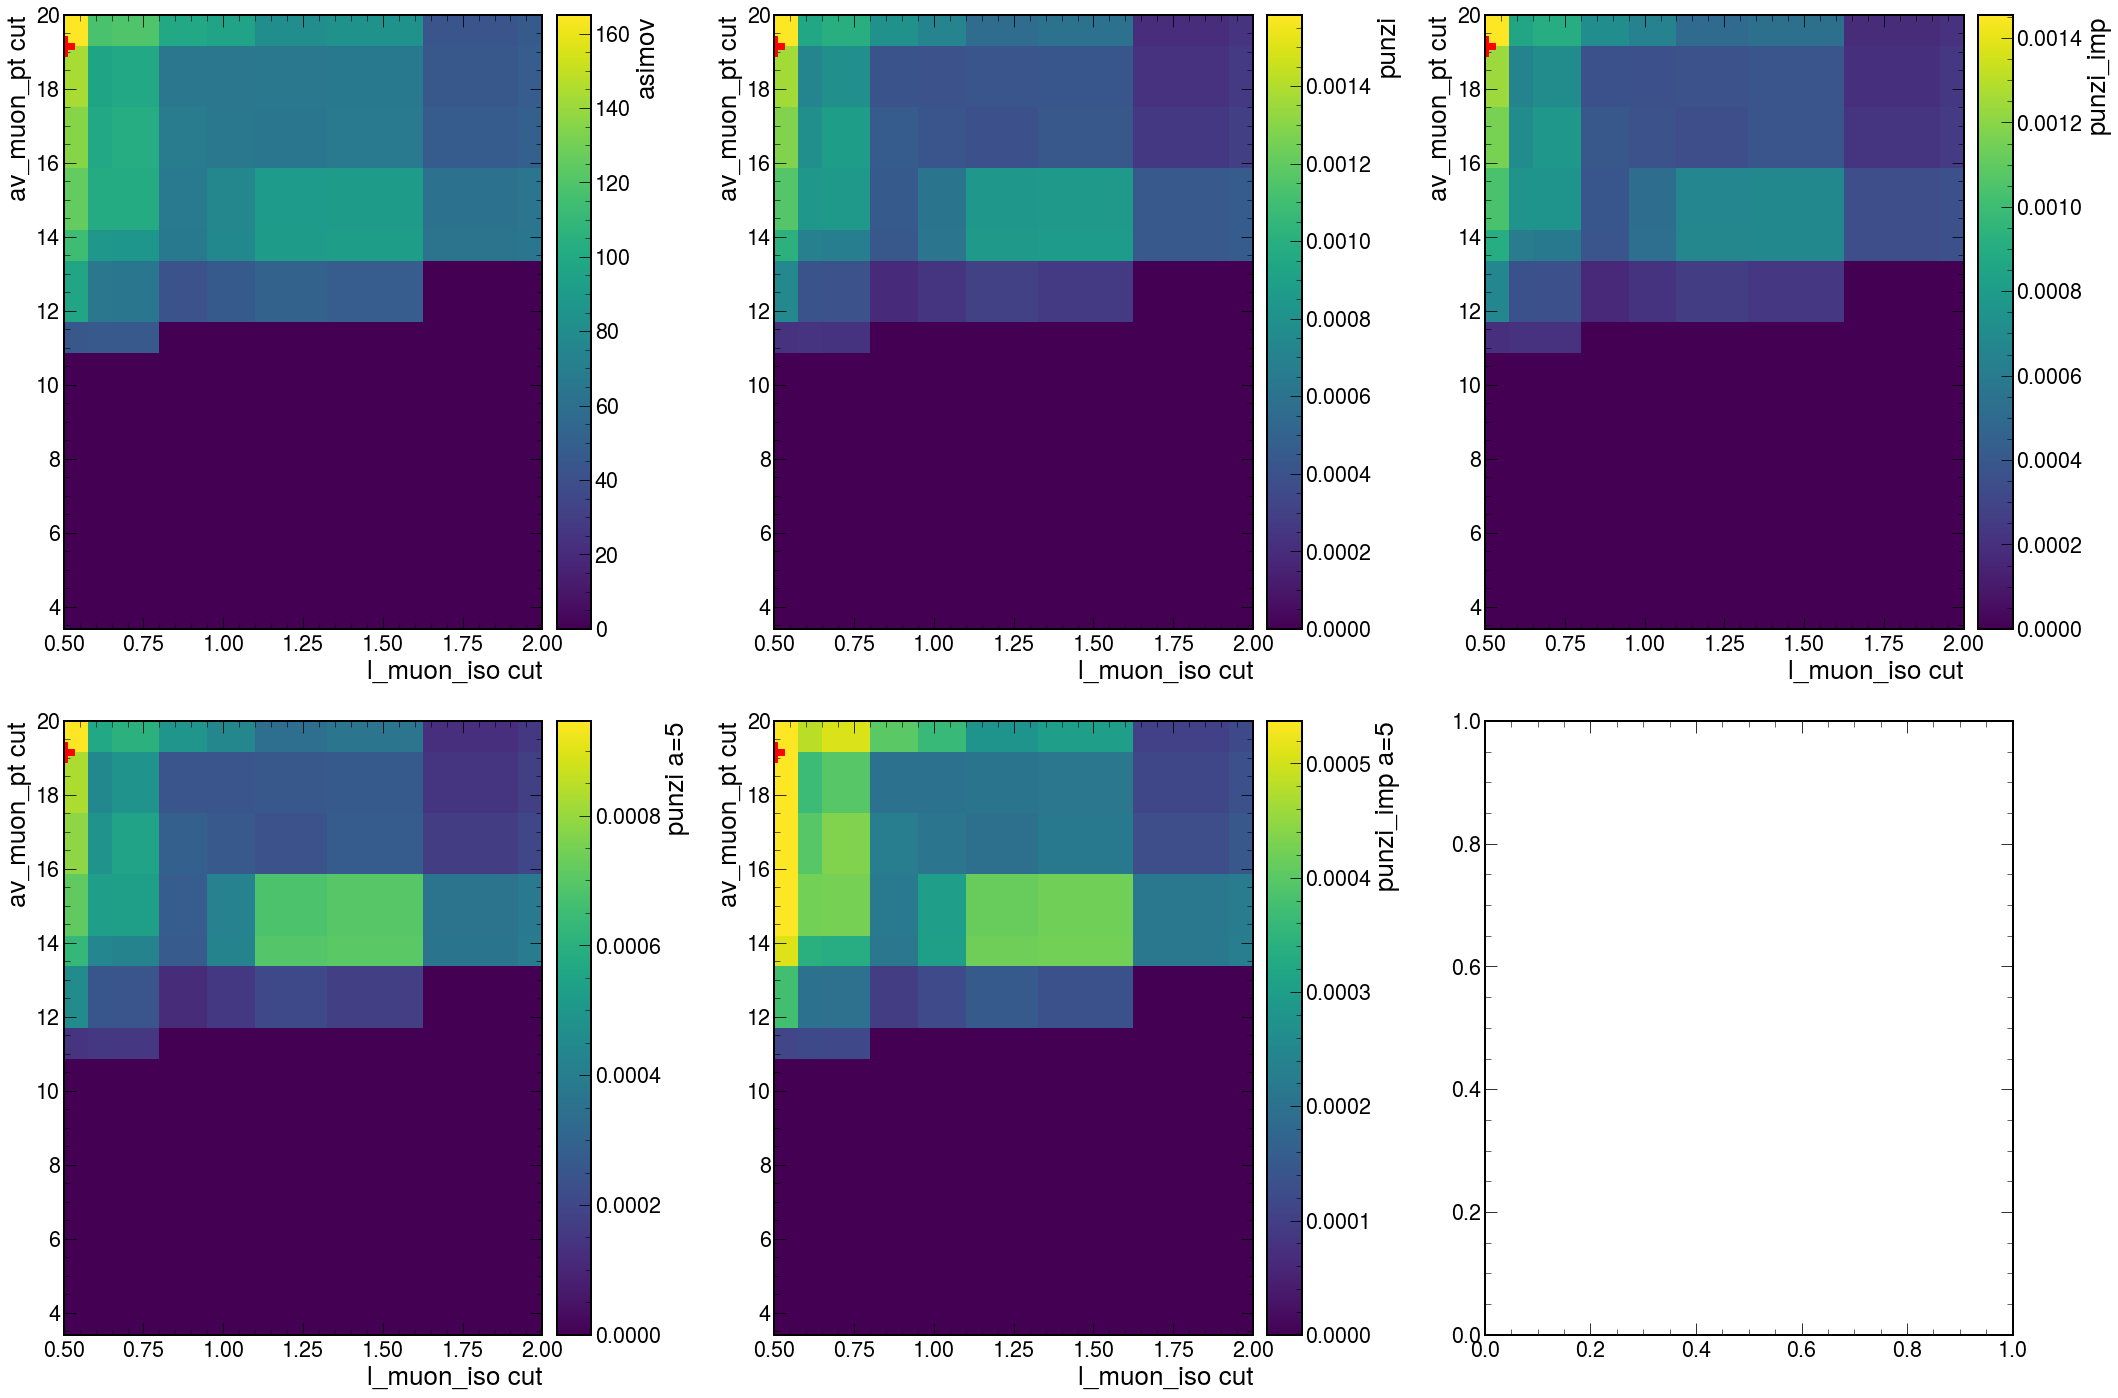

In [55]:
# Significance scans using fit extrapolations
for signal in signals:
    print(f"Results for {signal}")
    s_i = S[signal]
    eff_i = S[signal]/S_tot[signal]
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))
    
    #sig = S_over_SB(s_i, B)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[0, 0])
    #axs[0, 0].set_xlabel('l_muon_iso cut')
    #axs[0, 0].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_over_SB")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    #sig = S_12(s_i, B)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[0, 1])
    #axs[0, 1].set_xlabel('l_muon_iso cut')
    #axs[0, 1].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_12")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 0)
    sig = asimov_sig(s_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("asimov")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    #sig = S_over_BdB(s_i, B, deltaB2)
    #cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[1, 0])
    #axs[1, 0].set_xlabel('l_muon_iso cut')
    #axs[1, 0].set_ylabel('av_muon_pt cut')
    #cbar.cbar.set_label("S_over_BdB")
    #max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    #plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 1)
    sig = punzi(eff_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (0, 2)
    sig = punzi_imp(eff_i, B)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi_imp")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (1, 0)
    sig = punzi(eff_i, B, a=5)
    cbar = hep.hist2dplot(sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx])
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi a=5")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    idx = (1, 1)
    sig = punzi_imp(eff_i, B, a=5)
    cbar = hep.hist2dplot(
        sig, xbins=lead_interiso_cut, ybins=av_muon_pt_cut, ax=axs[idx], vmin=0.0, vmax=0.66*np.max(sig, axis=None)
    )
    axs[idx].set_xlabel('l_muon_iso cut')
    axs[idx].set_ylabel('av_muon_pt cut')
    cbar.cbar.set_label("punzi_imp a=5")
    max_i, max_j = np.unravel_index(np.argmax(sig, axis=None), sig.shape)
    plt.plot(lead_interiso_cut[max_i], av_muon_pt_cut[max_j], color='r', marker='P', markersize=20)
    
    plt.tight_layout()
    plt.show()

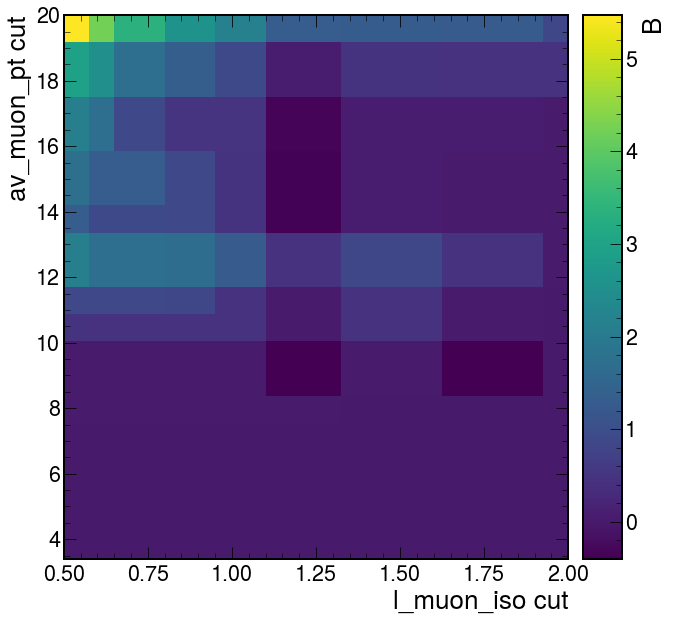

In [28]:
# Total B after cuts
cbar = hep.hist2dplot(B, xbins=lead_interiso_cut, ybins=av_muon_pt_cut)#, norm=matplotlib.colors.LogNorm())
plt.xlabel('l_muon_iso cut')
plt.ylabel('av_muon_pt cut')
cbar.cbar.set_label("B")

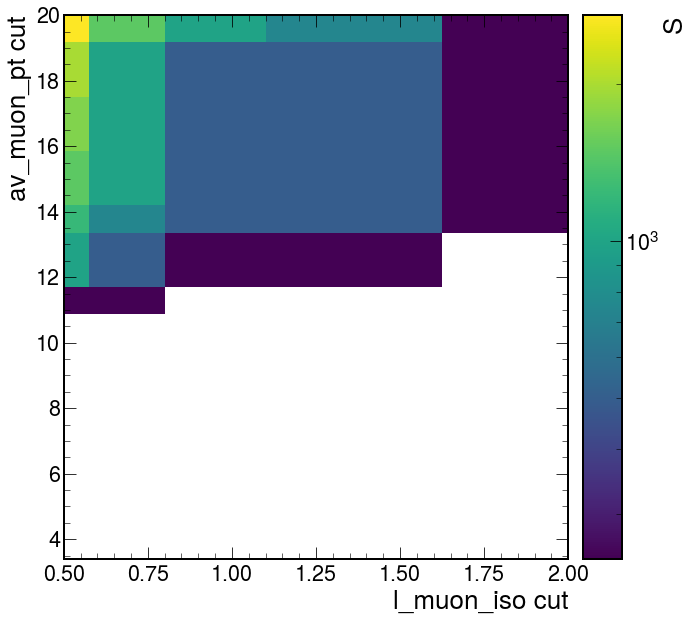

In [251]:
cbar = hep.hist2dplot(
    S['SUEP_mMed-125_mDark-8_temp-32_decay-darkPhoHad_2018'], 
    xbins=lead_interiso_cut, 
    ybins=av_muon_pt_cut,
    norm=matplotlib.colors.LogNorm()
)
plt.xlabel('l_muon_iso cut')
plt.ylabel('av_muon_pt cut')
cbar.cbar.set_label("S")

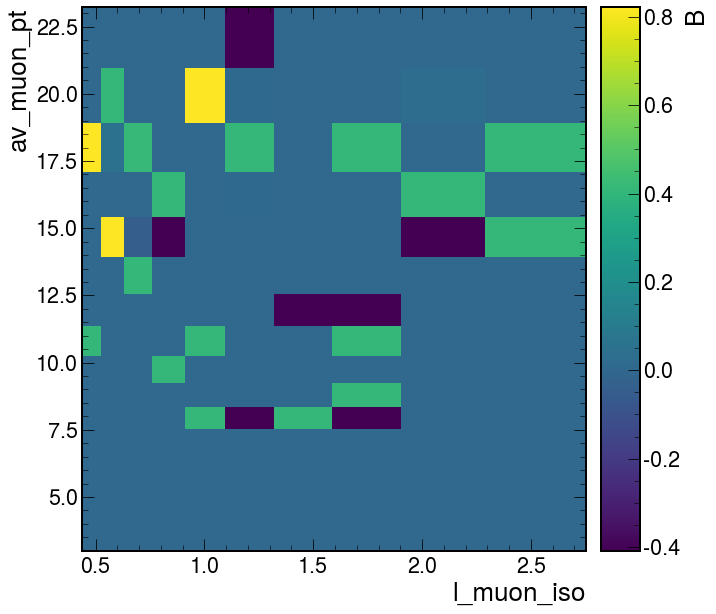

In [247]:
cbar = hep.hist2dplot(
    h_tot[0.5j:3j, :25j, ::sum, 6j::sum],
    #norm=matplotlib.colors.LogNorm()
)
plt.xlabel('l_muon_iso')
plt.ylabel('av_muon_pt')
#plt.xscale('log')
#plt.yscale('log')
cbar.cbar.set_label("B")

In [ ]:
# Best seems to be (1.1, 16) ??? <–––– this is it for now

In [ ]:
# or maybe (1.0, 15) after the extrapolations...

Slightly different best outcomes according to the used method. The optimum should be in the following ranges:
- av_pt in (15,16)
- interiso in (1.0, 1.25) 

In [56]:
1

1